# Experimentation with XGB Model

### This work is based on a paper by Xin Liu and Zhonghua Gou
Their publication: Occupant-centric HVAC and window control: A reinforcement learning model for enhancing indoor thermal comfort and energy efficiency. Building and Environment (2024): 111197.

And their code serves as a basis for this notebook: https://github.com/WHU-LX/Hvac-Window-based-XGB-DQN

In [2]:
import pandas as pd 
import numpy as np
from numpy import loadtxt
import random
import tensorflow as tf
import xgboost as xgb # 1.5.0
from skopt import BayesSearchCV 
from skopt.space import Integer
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

/Users/user/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-09-29 13:30:07.411503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Read Data

In [170]:
# 1. Read the processed CSV file, modify the file paths based on your actual file locations
# 1.读取处理后的csv文件，根据您的文件保存路径进行修改
xgb_file = "Cleaned_data.csv"
xgb_encode_file = "Cleaned_data_encode.csv"

# 2. Read the data 3. Set the timestamp format # 4. Remove missing values
# 2. 读取数据  3. 设定时间戳格式  4. 删除缺失值
data = pd.read_csv(xgb_file,encoding='gbk')
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
data = data.dropna()
data = data[data != -999].dropna()
# data.head()

# 5. Encode non-numeric variables
# 5. 将非数值类型的变量进行编码 
dtypes_list=data.dtypes.values
columns_list=data.columns
for i in range(len(columns_list)):
    if dtypes_list[i]=='object':
        lb=LabelEncoder()
        lb.fit(data[columns_list[i]])
        data[columns_list[i]]=lb.transform(data[columns_list[i]])
data.head()

ID           Date_Time  AC_Status  Window_Status  CLast_Time  CLast_Time_T  \
0   1 2019-03-05 00:00:00          0            0.0           0             0   
1   2 2019-03-05 01:00:00          0            0.0           0             0   
2   3 2019-03-05 02:00:00          0            0.0           0             0   
3   4 2019-03-05 03:00:00          0            0.0           0             0   
4   5 2019-03-05 04:00:00          0            0.0           0             0   

   WLast_Time  WLast_Time_T  Indoor_Temp  Indoor_RH  ...  Room_ID  Study_ID  \
0         0.0           0.0        25.12      70.84  ...        0         6   
1         0.0           0.0        25.09      71.22  ...        0         6   
2         0.0           0.0        25.05      71.66  ...        0         6   
3         0.0           0.0        25.02      71.84  ...        0         6   
4         0.0           0.0        24.97      72.11  ...        0         6   

   City  Next_Indoor_Temp  Next_Indoor_RH  Next_Outdoor_Temp  Next_Outdoor_RH  \
0     0             25.09           71.22               26.0             84.0   
1     0             25.05           71.66               26.0             89.0   
2     0             25.02           71.84               26.0             89.0   
3     0             24.97           72.11               25.0             89.0   
4     0             24.92           72.12               25.0             89.0   

   Differ_Outdoor_Temp  Differ_Indoor_Temp  Target_Temp  
0                  0.0               -0.03          0.0  
1                  0.0               -0.04          0.0  
2                  0.0               -0.03          0.0  
3                 -1.0               -0.05          0.0  
4                  0.0               -0.05          0.0  

[5 rows x 27 columns]

In [4]:
num_studies = set(data['Room_ID'])
num_studies

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [172]:
# 7. 'x' represents independent variables, 'y' represents the feature to be predicted
x = data.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
y = data['Differ_Indoor_Temp']


In [173]:
# 8. Split the dataset into training and testing sets
x_train_paper, x_test_paper, y_train_paper, y_test_paper = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022)

## 2. Reproduce XGBoost from the paper

In [210]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train_paper, y_train_paper)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.23474256920511388), ('max_depth', 5), ('n_estimators', 500)])


In [174]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_original = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.2347, 
                            n_estimators=500)
model_XGB_original.fit(x_train_paper, y_train_paper)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2347, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(y_test, y_test_pred, evaluation_title):
    # Create a scatter plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_test_pred, color='blue', alpha=0.5)

    # Plot a diagonal line representing perfect predictions
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    # Add labels and title
    plt.xlabel('Test True Values')
    plt.ylabel('Test Predicted Values')
    plt.title(f'{evaluation_title}: True vs Predicted Values')

    # Show the plot
    plt.show()


def eval_model(model, x_train, x_test, y_train, y_test, evaluation_title):
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    mse =  mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse) 
    mae =  mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    mse_train =  mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train) 
    mae_train =  mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    print("Evaluating Model")
    print(evaluation_title)
    print(f"TEST -  mse: {mse:.5f} | rmse: {rmse:.5f} | mae: {mae:.5f} | r2: {r2:.5f}")
    print(f"TRAIN -  mse: {mse_train:.4f} | rmse: {rmse_train:.4f} | mae: {mae_train:.4f} | r2: {r2_train:.4f}")
    plot_results(y_test, y_test_pred, evaluation_title)

Evaluating Model
Paper Model
TEST -  mse: 0.12432 | rmse: 0.35260 | mae: 0.18190 | r2: 0.46648
TRAIN -  mse: 0.0429 | rmse: 0.2072 | mae: 0.1220 | r2: 0.8467


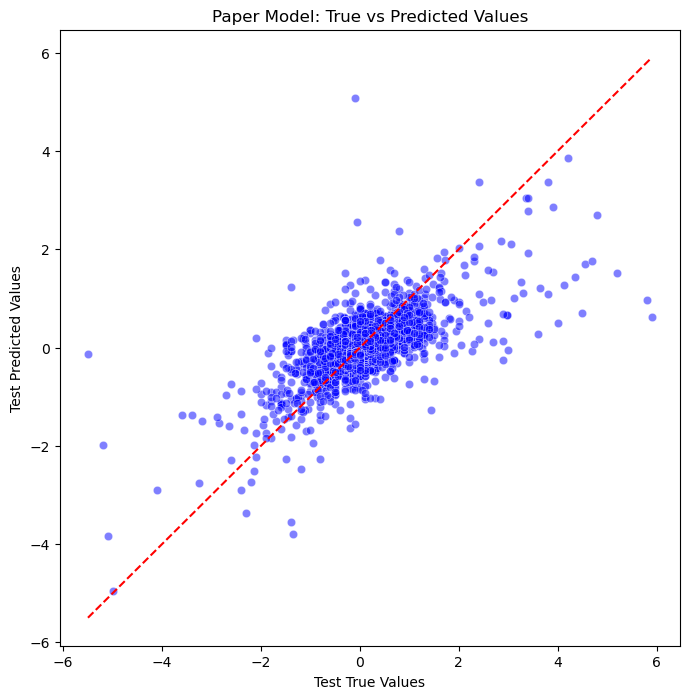

In [267]:
eval_model(model_XGB_original, x_train_paper, x_test_paper, y_train_paper, y_test_paper, "Paper Model")

## 2. Stratify on City, as a preparation for next steps

In [9]:
# 8. Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022, stratify=x['City'])

### Note:
This is not exactly a reproduce, because I wanted to stratify on city for better evaluation and comparison of the next models. If we remove the stratification in the train test split, the results obtained are exactly those reported in the paper. Now lets see the results of the same model with stratification

In [217]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.336503142776649), ('max_depth', 5), ('n_estimators', 500)])


In [219]:
model_XGB_stratified = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.3365, 
                            n_estimators=500)
model_XGB_stratified.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2347, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Paper Model, with Stratified Data Split
TEST -  mse: 0.16046313133987558 | rmse: 0.4005784958530295 | mae: 0.19097021085710922 | r2: 0.4546911162846945
TRAIN -  mse: 0.04086661631122002 | rmse: 0.20215493145412017 | mae: 0.11988112793325922 | r2: 0.8456532923539214


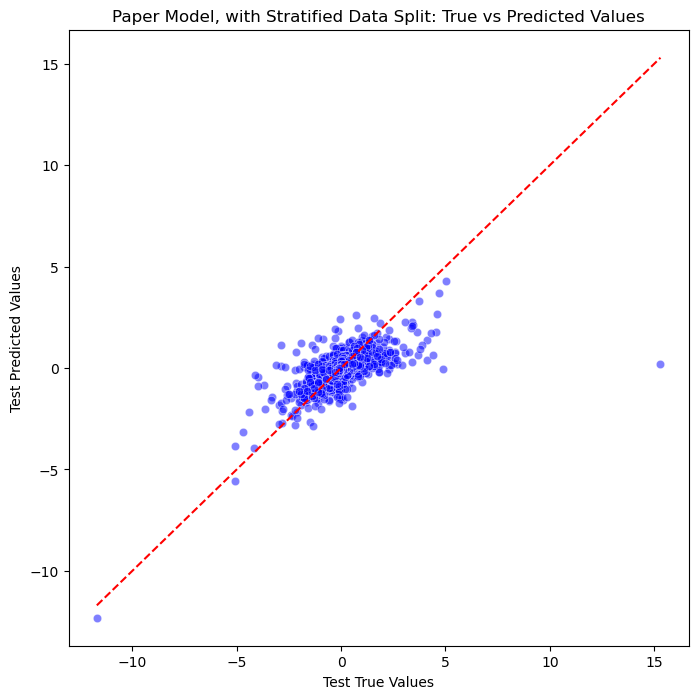

In [220]:
eval_model(model_XGB_stratified, x_train, x_test, y_train, y_test, "Paper Model, with Stratified Data Split")

### Conclusions:

1. The unique datapoint with 15 change in the temperature, wasn't in the test set without stratification (by chance). This drove me into looking into the data, and exploring its patters. Does it have outliers? Will it benefit from transformation?
2. There are signs of overfitting. Those can potentially be reduced with higher num of regressors, or smaller depth of each regressor.



## 3. Data exploration

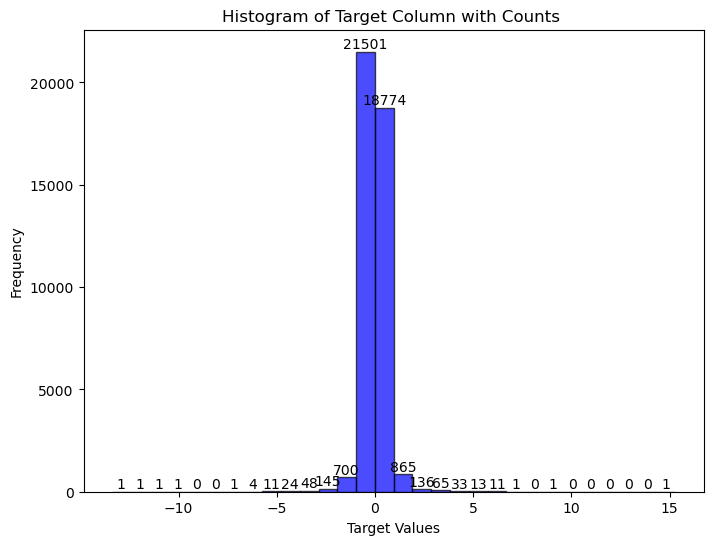

In [216]:
import matplotlib.pyplot as plt

def plot_target_col_hist(target, addition_to_title=""):
    # Assuming 'target_column' is your target variable in the dataframe
    plt.figure(figsize=(8, 6))

    # Plot the histogram and capture the counts and bin edges
    counts, bins, patches = plt.hist(target, bins=30, color='blue', edgecolor='black', alpha=0.7)
    # Annotate each bar with the count above it
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Compute the center of each bin
    for count, x in zip(counts, bin_centers):
        plt.text(x, count, int(count), ha='center', va='bottom')  # Place the text

    # Adding labels and title
    plt.xlabel('Target Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Target Column with Counts {addition_to_title}')

    # Show the plot
    plt.show()

plot_target_col_hist(y)


## 3.1 Investigate Outliars

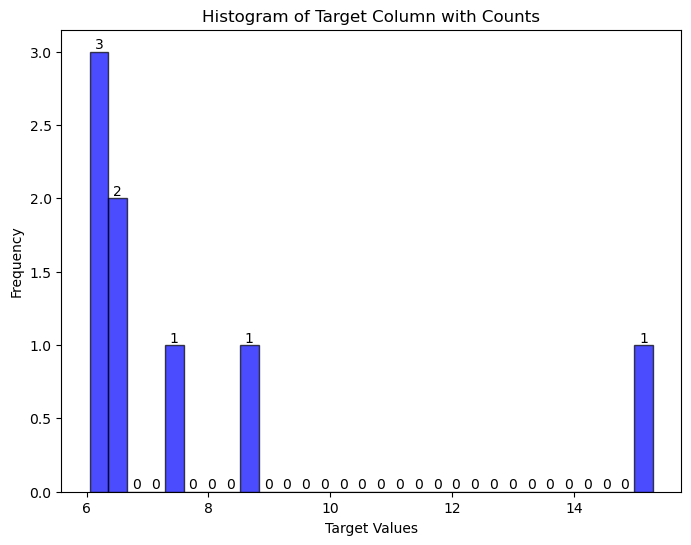

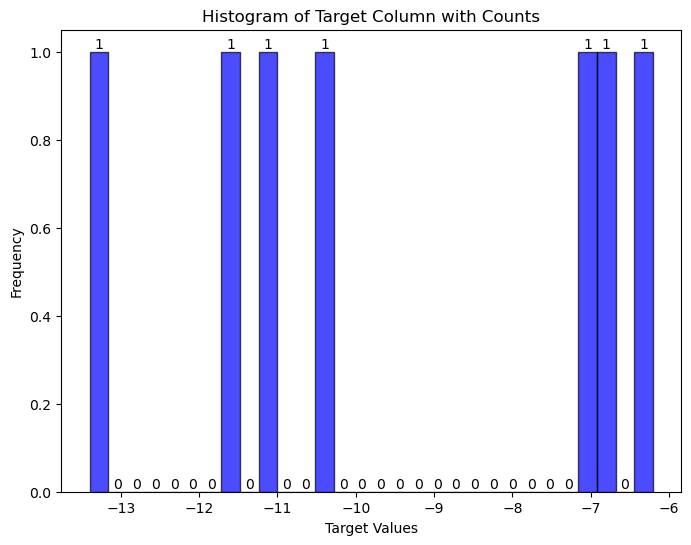

0.9569181350087392

In [177]:
above_6 = y[y > 6]
below_neg_6 = y[y < -6]
plot_target_col_hist(above_6)
plot_target_col_hist(below_neg_6)
close_to_zeroes = y[(y <= 1) & (y >= -1)]
len(close_to_zeroes) / len(y)

### 3.1.1 Eyeball examination of outliars

In [179]:
outliars = data[(data["Differ_Indoor_Temp"] >6) | (data["Differ_Indoor_Temp"] < -6)]

outliars = outliars[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp", "City","Room_ID", "Study_ID", "ID"]]

outliars.to_csv("outliars.csv")
outliars.head(20)

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
6712  2016-12-20 10:00:00          1            0.0        17.80   
7270  2017-01-12 16:00:00          1            0.0        19.30   
7383  2017-01-17 09:00:00          1            0.0        16.65   
23025 2018-05-09 15:00:00          0            0.0        23.80   
23026 2018-05-09 16:00:00          0            1.0        39.10   
23744 2018-10-09 15:00:00          0            0.0        33.30   
23745 2018-10-09 16:00:00          0            1.0        42.10   
23891 2018-11-09 15:00:00          0            0.0        30.70   
23892 2018-11-09 16:00:00          0            1.0        38.00   
29942 2018-08-12 23:00:00          0            1.0        24.30   
31007 2018-11-08 23:00:00          0            1.0        17.80   
32508 2018-08-12 23:00:00          0            1.0        24.70   
36487 2018-03-08 23:00:00          0            1.0        18.70   
37263 2018-09-24 15:00:00          1            1.0        34.00   
39384 2018-11-09 15:00:00          1            1.0        25.70   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
6712              24.30            16               16.0                6.50   
7270              25.35            12               11.0                6.05   
7383              22.90             9               10.0                6.25   
23025             39.10            24               23.0               15.30   
23026             27.40            23               20.0              -11.70   
23744             42.10            27               27.0                8.80   
23745             31.00            27               27.0              -11.10   
23891             38.00            21               20.0                7.30   
23892             24.60            20               20.0              -13.40   
29942             17.30            12               11.0               -7.00   
31007             24.00            17               17.0                6.20   
32508             18.00            12               11.0               -6.70   
36487             25.10            20               20.0                6.40   
37263             23.70            29               21.0              -10.30   
39384             19.50            21               20.0               -6.20   

       City  Room_ID  Study_ID     ID  
6712      2        1        10   6713  
7270      2        1        10   7271  
7383      2        1        10   7384  
23025     3        8        16  23026  
23026     3        8        16  23027  
23744     3        8        16  23745  
23745     3        8        16  23746  
23891     3        8        16  23892  
23892     3        8        16  23893  
29942     3       11        16  29943  
31007     3       11        16  31008  
32508     3       12        16  32509  
36487     3       14        16  36488  
37263     3       14        16  37264  
39384     3       15        16  39385

In [256]:
look = data[(data["ID"] > 23023) & (data["ID"] < 23029)]
look[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp","City", "Room_ID", "Study_ID", "ID"]].head()

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
23023 2018-05-09 13:00:00          0            1.0         20.8   
23024 2018-05-09 14:00:00          0            0.0         21.6   
23025 2018-05-09 15:00:00          0            0.0         23.8   
23026 2018-05-09 16:00:00          0            1.0         39.1   
23027 2018-05-09 17:00:00          0            1.0         27.4   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
23023              21.6            23               24.0                 0.8   
23024              23.8            24               24.0                 2.2   
23025              39.1            24               23.0                15.3   
23026              27.4            23               20.0               -11.7   
23027              23.6            20               19.0                -3.8   

       City  Room_ID  Study_ID     ID  
23023     3        8        16  23024  
23024     3        8        16  23025  
23025     3        8        16  23026  
23026     3        8        16  23027  
23027     3        8        16  23028

In [257]:
look = data[(data["ID"] > 36485) & (data["ID"] < 36490)]
look[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp","City", "Room_ID", "Study_ID", "ID"]].head()

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
36485 2018-03-08 21:00:00          0            1.0         18.7   
36486 2018-03-08 22:00:00          0            1.0         18.7   
36487 2018-03-08 23:00:00          0            1.0         18.7   
36488 2018-03-09 00:00:00          1            1.0         25.1   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
36485              18.7            20               20.0                 0.0   
36486              18.7            20               20.0                 0.0   
36487              25.1            20               20.0                 6.4   
36488              24.9            20               19.0                -0.2   

       City  Room_ID  Study_ID     ID  
36485     3       14        16  36486  
36486     3       14        16  36487  
36487     3       14        16  36488  
36488     3       14        16  36489

In [244]:
look = data[(data["ID"] == 23744) | (data["ID"] == 23745) | (data["ID"] == 23746)]
look[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp","City", "Room_ID", "Study_ID", "ID"]].head()

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
23743 2018-10-09 14:00:00          0            0.0         27.4   
23744 2018-10-09 15:00:00          0            0.0         33.3   
23745 2018-10-09 16:00:00          0            1.0         42.1   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
23743              33.3            27               27.0                 5.9   
23744              42.1            27               27.0                 8.8   
23745              31.0            27               27.0               -11.1   

       City  Room_ID  Study_ID     ID  
23743     3        8        16  23744  
23744     3        8        16  23745  
23745     3        8        16  23746

In [245]:
look = data[(data["ID"] == 23744) | (data["ID"] == 23745) | (data["ID"] == 23746)]
look[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp","City", "Room_ID", "Study_ID", "ID"]].head()

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
23743 2018-10-09 14:00:00          0            0.0         27.4   
23744 2018-10-09 15:00:00          0            0.0         33.3   
23745 2018-10-09 16:00:00          0            1.0         42.1   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
23743              33.3            27               27.0                 5.9   
23744              42.1            27               27.0                 8.8   
23745              31.0            27               27.0               -11.1   

       City  Room_ID  Study_ID     ID  
23743     3        8        16  23744  
23744     3        8        16  23745  
23745     3        8        16  23746

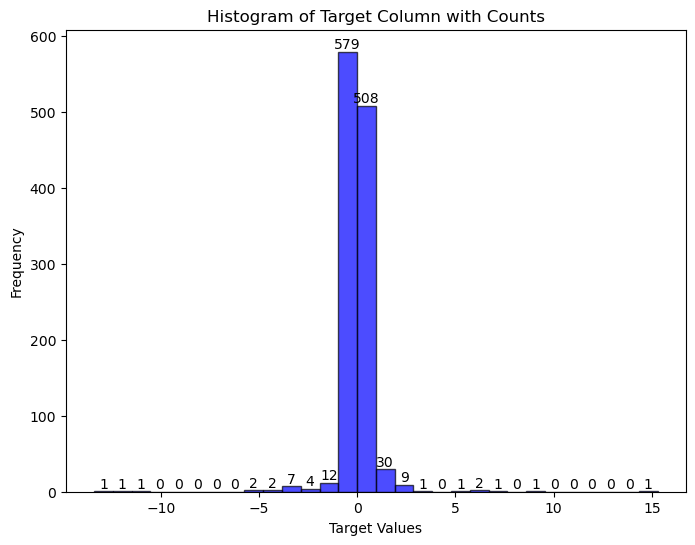

In [270]:
room_8_rende = data[(data["Room_ID"] == 8) & (data["City"] == 3)].copy()
len(room_8_rende)
plot_target_col_hist(room_8_rende["Differ_Indoor_Temp"])

In [271]:
testing = data[(data["Room_ID"] == 8)]
len(testing)

1163

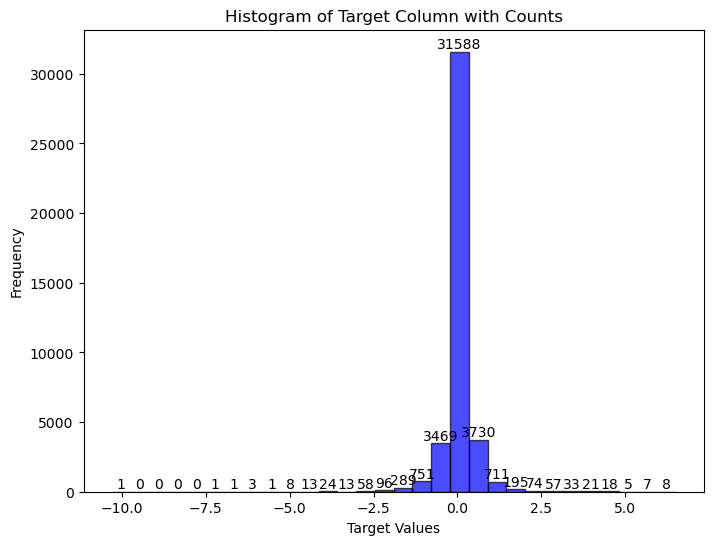

In [272]:
filtered_data = data[(data["Room_ID"] != 8)]
plot_target_col_hist(filtered_data["Differ_Indoor_Temp"])

### 3.1.2 Plot timeseries of different rooms

In [182]:
import matplotlib.pyplot as plt

def plot_temp_series_with_status(data_to_plot, title):
    # Ensure 'Date_Time' is the index for time series plotting
    # data_to_plot.set_index('Date_Time', inplace=True)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})
    ax1.tick_params(axis='x', rotation=0)

    # Show grid
    ax1.grid(True)


    # Plot the 'Indoor_Temp' column
    ax1.plot(data_to_plot.index, data_to_plot['Indoor_Temp'], color='blue', marker='o', linestyle='-', markersize=4, label='Indoor Temperature')
    ax1.plot(data_to_plot.index, data_to_plot['Outdoor_Temp'], color='red', marker='s', linestyle='--', markersize=4, label='Outdoor Temperature')
    # Adding labels and title
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Indoor Temperature')

    ax2.step(data_to_plot.index, data_to_plot['AC_Status'], where='post', linestyle='-', linewidth=4, label='AC_Status', color='Orange', alpha=1)
    ax2.set_ylabel('AC Status')

    ax3.step(data_to_plot.index, data_to_plot['Window_Status'], where='post', linestyle='-', linewidth=4, label='Window_Status', color='Orange', alpha=1)
    ax3.set_ylabel('Window Status')


    plt.title(f"{title}: Indoor Temperature Over Time")
    plt.legend()


    # Show the plot
    plt.tight_layout()
    plt.show()

In [203]:
import matplotlib.pyplot as plt

def plot_temp_series(data_to_plot, plot_outdoor_temp, title):
    # Ensure 'Date_Time' is the index for time series plotting
    # data_to_plot.set_index('Date_Time', inplace=True)

    plt.figure(figsize=(12, 6))

    # Plot the 'Indoor_Temp' column
    plt.plot(data_to_plot.index, data_to_plot['Indoor_Temp'], color='blue', marker='o', linestyle='-', markersize=4, label='Indoor Temperature')
    if plot_outdoor_temp:
        plt.plot(data_to_plot.index, data_to_plot['Outdoor_Temp'], color='violet', marker='s', linestyle='--', markersize=4, label='Outdoor Temperature')
    # Adding labels and title
        
    title_outdoor = "and Outdoor" if plot_outdoor_temp else ""
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature')
    plt.title(f"{title}: Indoor {title_outdoor} Temperature Over Time")
    plt.legend()

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

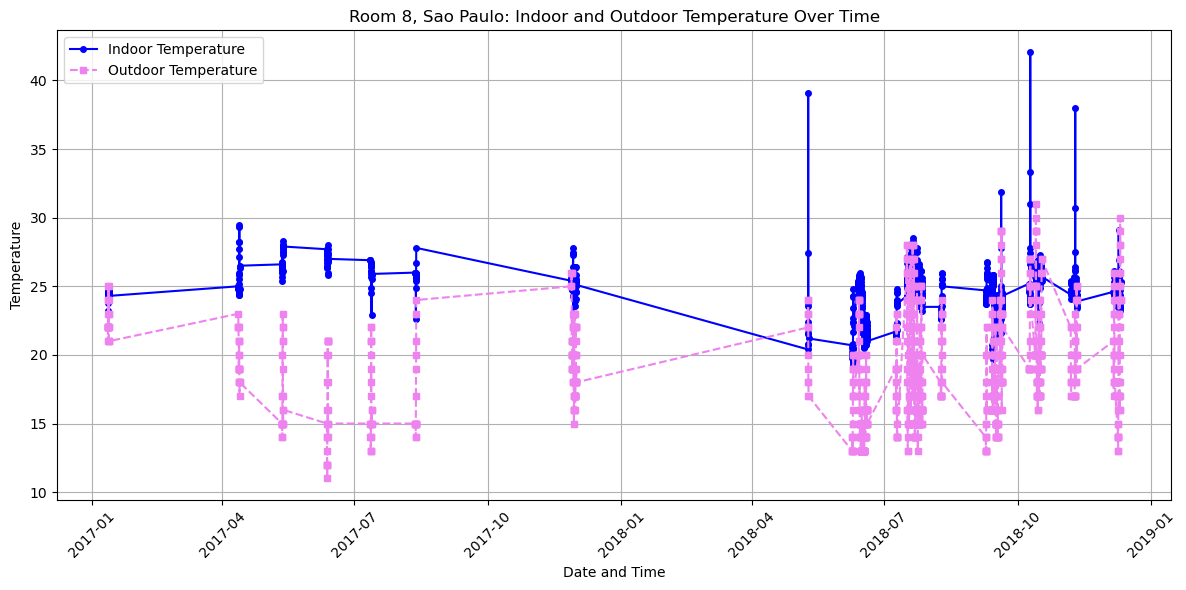

In [204]:
data_to_plot = data[(data["Room_ID"] == 8) & (data["City"] == 3)]

# start_date = '2018-10-09'
# end_date = '2018-10-10'

data_to_plot.set_index('Date_Time', inplace=True)
# Filter the DataFrame
# data_to_plot = data_to_plot[start_date:end_date]
# plot_temp_series_with_status(data_to_plot, "Room 8")
plot_temp_series(data_to_plot, True, "Room 8, Sao Paulo")

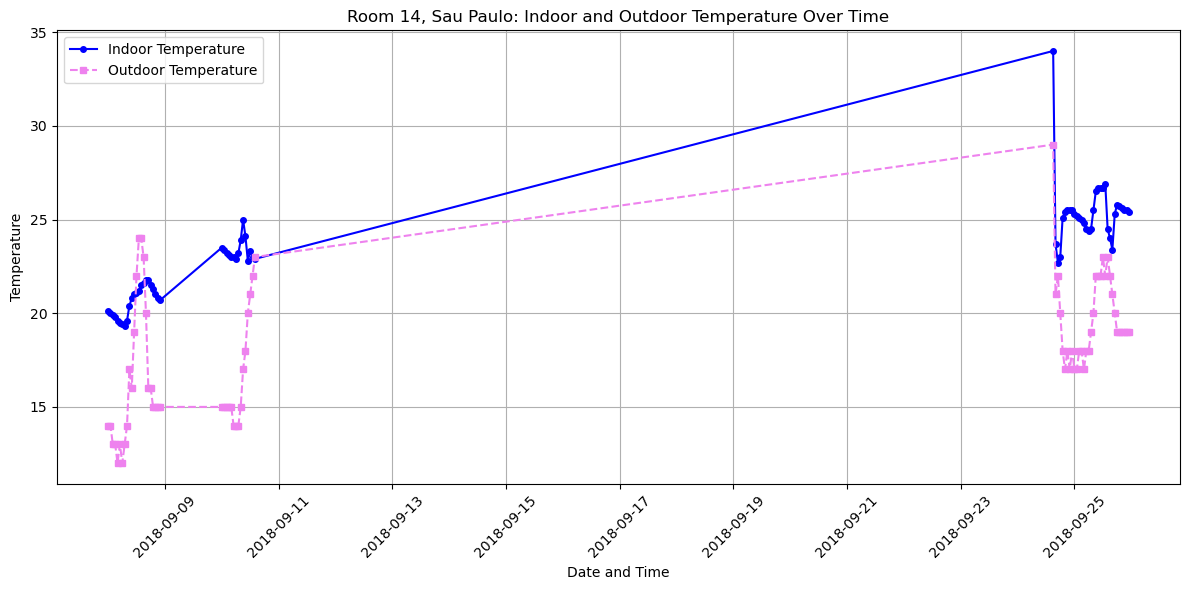

In [207]:
data_to_plot = data[(data["Room_ID"] == 14)]
data_to_plot.set_index('Date_Time', inplace=True)

start_date = '2018-09-01'
end_date = '2018-09-25'

# Filter the DataFrame
data_to_plot = data_to_plot[start_date:end_date]
plot_temp_series(data_to_plot, True, "Room 14, Sau Paulo")


Note: ALL outliars for which AC status was OFF, are from study number 16. This is suspicious, let's examine each row separately

1. First 3 rows, from Study 10 in Sao Paulo: They do make sense. It is cold outside and inside. The occupants turned on AC to warm the room, and the room turned warmer in about 6 degree.
2. Let's inspect study 16 to gain better understanding of what's happening there

In [247]:
rende_data = data[data["City"] == 3]

print(rende_data["Study_ID"].unique())
print(rende_data["Room_ID"].unique())

[23 16]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [252]:
len(rende_data)

30562

0.5183523076196325 of the data is from Study 16


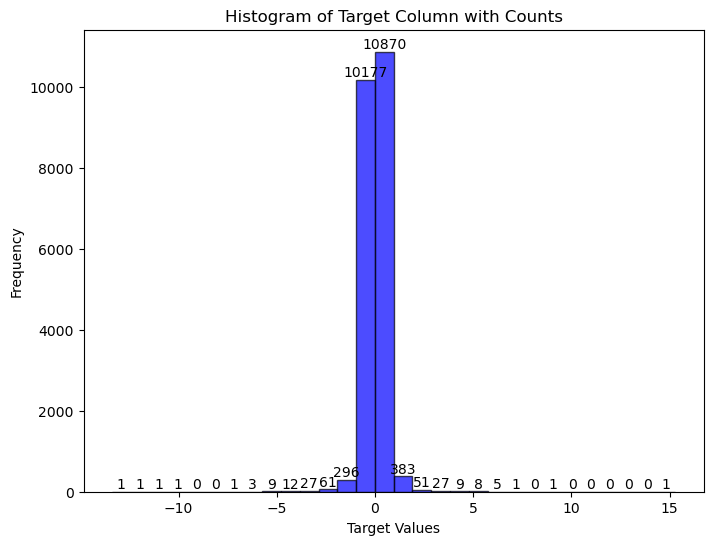

In [253]:
study_16 = rende_data[rende_data["Study_ID"] == 16]

frequency_study_16 = len(study_16) / len(data)

print(f"{frequency_study_16} of the data is from Study 16")

plot_target_col_hist(study_16["Differ_Indoor_Temp"])

Changes: 
1. Increase CV to 4 (as we have 33870 examples in training set)
2. Identifiy the selected values for num estimator and max depth were the ones in the top of the range. Adjust range to enable truly selecting the best option

In [ ]:
#TODO continue here:

#0. Compare study 16 room 8 to other studies, and justify why I want to remove it - DONE
#1. Filter data: remove study 8 as it has those weird layouts - Done
#2. Split again to train, test sets with stratification - WIP
#3. Consider transformation of log modulu for making the numbers more meaningfull!!!
#4. Then run again the code for each country individually

## 3. Clean Data!
### Remove Room 8, Sao Paulo, Study 16 from the data, for the year 2018 and onwards

In [208]:
data['Date_Time'] = pd.to_datetime(data['Date_Time'])

# Filter the DataFrame for 'Room_ID' = 8 and 'Date_Time' from 2018 onwards
to_filter_out = data[(data['Room_ID'] == 8) & (data['Date_Time'] >= '2018-01-01')]
print(f"Room 8 has {len(to_filter_out)} rows for the year of 2018 and onwards. Preparing to filter those out")
filtered_data = data[~data['ID'].isin(to_filter_out['ID'])]
print(f"Data had {len(data)} rows. After filtering, it has {len(filtered_data)} rows")

Room 8 has 949 rows for the year of 2018 and onwards. Preparing to filter those out
Data had 42338 rows. After filtering, it has 41389 rows


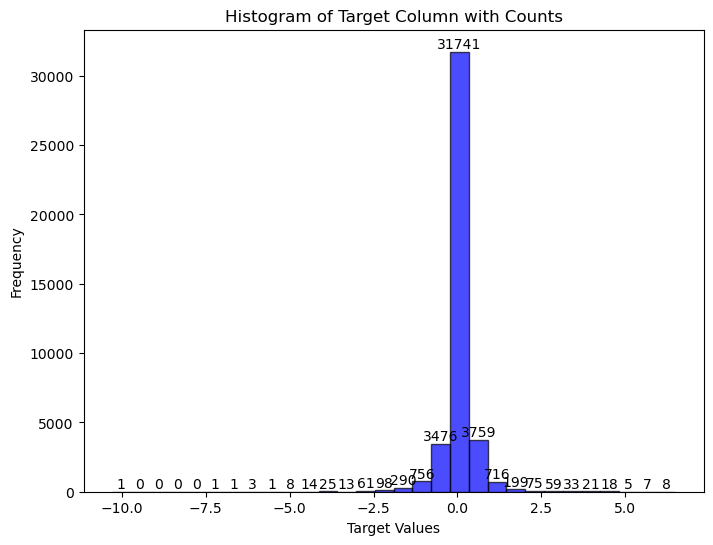

In [209]:
plot_target_col_hist(filtered_data["Differ_Indoor_Temp"])

In [210]:
outliars = filtered_data[(filtered_data["Differ_Indoor_Temp"] >7) | (filtered_data["Differ_Indoor_Temp"] < -7)]

outliars = outliars[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp", "City","Room_ID", "Study_ID", "ID"]]

outliars.head(20)

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
37263 2018-09-24 15:00:00          1            1.0         34.0   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
37263              23.7            29               21.0               -10.3   

       City  Room_ID  Study_ID     ID  
37263     3       14        16  37264

In [213]:
look = filtered_data[(filtered_data["ID"] > 37261) & (filtered_data["ID"] < 37267)]
look[["Date_Time","AC_Status", "Window_Status", "Indoor_Temp", "Next_Indoor_Temp", "Outdoor_Temp", "Next_Outdoor_Temp", "Differ_Indoor_Temp","City", "Room_ID", "Study_ID", "ID"]].head()

Date_Time  AC_Status  Window_Status  Indoor_Temp  \
37261 2018-09-10 14:00:00          1            1.0         22.9   
37264 2018-09-24 16:00:00          1            1.0         23.7   
37265 2018-09-24 17:00:00          1            1.0         22.7   

       Next_Indoor_Temp  Outdoor_Temp  Next_Outdoor_Temp  Differ_Indoor_Temp  \
37261              22.0            23               22.0                -0.9   
37264              22.7            21               22.0                -1.0   
37265              23.0            22               20.0                 0.3   

       City  Room_ID  Study_ID     ID  
37261     3       14        16  37262  
37264     3       14        16  37265  
37265     3       14        16  37266

In [214]:
filtered_data = filtered_data[filtered_data["ID"] != 37264]
len(filtered_data)

41388

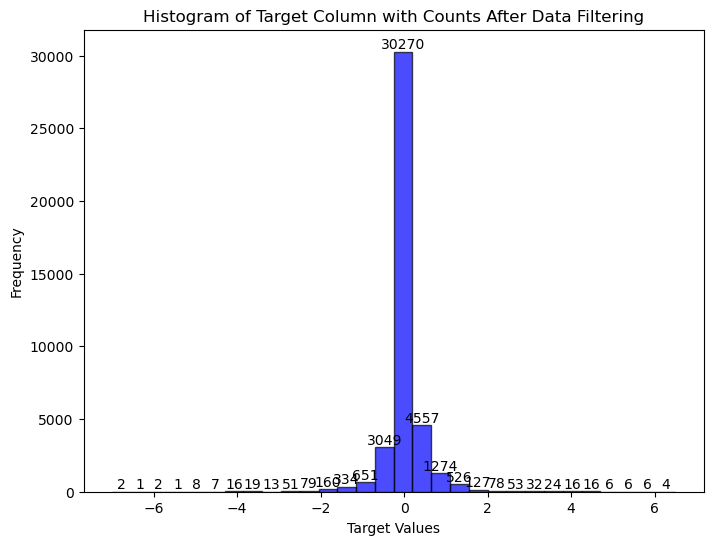

In [217]:
plot_target_col_hist(filtered_data["Differ_Indoor_Temp"], "After Data Filtering")

In [218]:
filtered_data["Differ_Indoor_Temp"].min()

-7.0

In [219]:
filtered_data["Differ_Indoor_Temp"].max()

6.5

## 4. Paper Baseline + Clean data + stratification

In [220]:
filtered_data.columns

Index(['ID', 'Date_Time', 'AC_Status', 'Window_Status', 'CLast_Time',
       'CLast_Time_T', 'WLast_Time', 'WLast_Time_T', 'Indoor_Temp',
       'Indoor_RH', 'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed',
       'Month', 'Hour', 'Room_ID', 'Study_ID', 'City', 'Next_Indoor_Temp',
       'Next_Indoor_RH', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Differ_Indoor_Temp', 'Target_Temp'],
      dtype='object')

In [280]:
# 8. Split the dataset into training and testing sets, stratifying on City
x = filtered_data.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
y = filtered_data['Differ_Indoor_Temp']

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022, stratify=x['City'])

In [222]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.20167667792255314), ('max_depth', 5), ('n_estimators', 479)])


In [223]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_stratified_clean = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.2017, 
                            n_estimators=479)
model_XGB_stratified_clean.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2017, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=479, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Paper Model + Stratified + Clean
TEST -  mse: 0.12617723596053163 | rmse: 0.355214352131965 | mae: 0.18573162567438647 | r2: 0.48871493097477103
TRAIN -  mse: 0.045481772893816094 | rmse: 0.21326456080140482 | mae: 0.12561852996497277 | r2: 0.8151120155809306


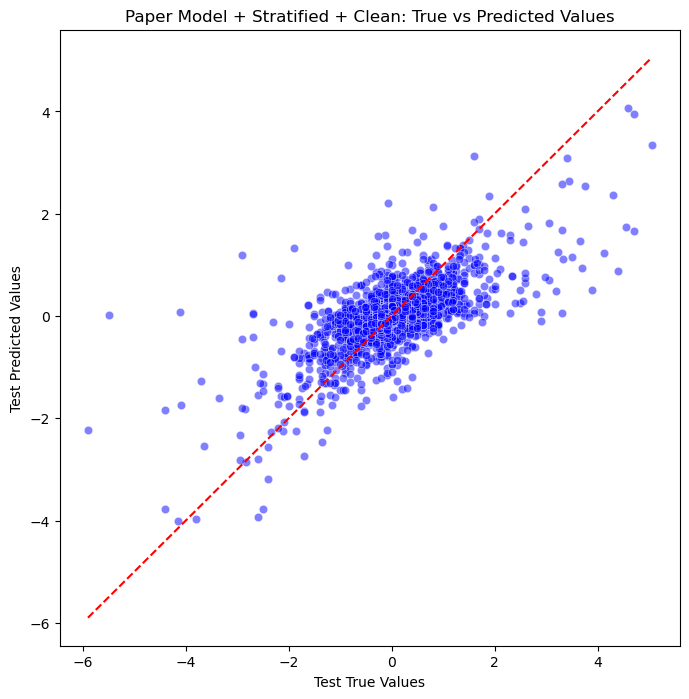

In [374]:
eval_model(model_XGB_stratified_clean, x_train, x_test, y_train, y_test, "Paper Model + Stratified + Clean")

### Orig model with 1 hot encoding

In [281]:
x_train_enc_1 = onehot_encode_city_room(x_train)
x_test_enc_1 = onehot_encode_city_room(x_test)

In [282]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train_enc_1, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.21034274470064665), ('max_depth', 5), ('n_estimators', 500)])


In [283]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_original_clean_enc = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.2103, 
                            n_estimators=500)
model_XGB_original_clean_enc.fit(x_train_enc_1, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2103, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Original model, with clean, stratified data and 1 hot encoding
TEST -  mse: 0.11921 | rmse: 0.34527 | mae: 0.18120 | r2: 0.51695
TRAIN -  mse: 0.0402 | rmse: 0.2004 | mae: 0.1197 | r2: 0.8367


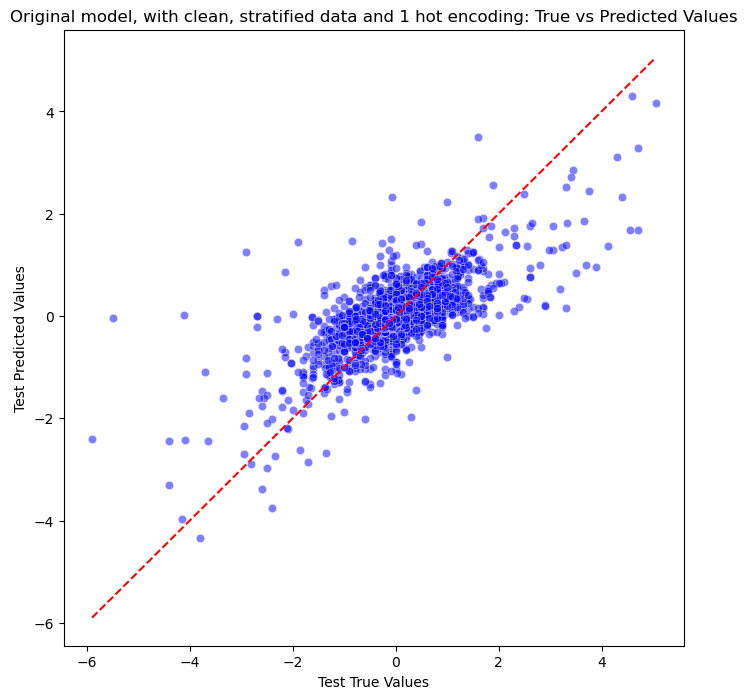

In [294]:
eval_model(model_XGB_original_clean_enc, x_train_enc_1, x_test_enc_1, y_train, y_test, "Original model, with clean, stratified data and 1 hot encoding")

In [288]:
columns_full = [
    'Model', 
    'Florianopolis-Train', 
    'Florianopolis-Test',
    'Nanjing-Train', 
    'Nanjing-Test', 
    'Rende-Train', 
    'Rende-Test', 
    'Sao Paulo-Train', 
    'Sao Paulo-Test', 
    'All-Train', 
    'All-Test', 
    'Description'
]

results_df_original_method_enc = pd.DataFrame(columns=columns_full)

stratified_2022_enc_model_data_dict = get_per_city_model_data_dict(x_train, x_test, y_train, y_test)

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'City', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Target_Temp', 'Room__0', 'Room__1', 'Room__2',
       'Room__3', 'Room__4', 'Room__5', 'Room__6', 'Room__7', 'Room__8',
       'Room__9', 'Room__10', 'Room__11', 'Room__12', 'Room__13', 'Room__14',
       'Room__15', 'Room__16', 'Room__17'],
      dtype='object')


In [224]:
columns_full = [
    'Model', 
    'Florianopolis-Train', 
    'Florianopolis-Test',
    'Nanjing-Train', 
    'Nanjing-Test', 
    'Rende-Train', 
    'Rende-Test', 
    'Sao Paulo-Train', 
    'Sao Paulo-Test', 
    'All-Train', 
    'All-Test', 
    'Description'
]


In [227]:
results_df_original_method = pd.DataFrame(columns=columns_full)


In [284]:
stratified_2022_model_data_dict = get_data_dict(x_train, x_test, y_train, y_test)

In [228]:
# add_model_results(results_df_original_method, model_XGB_stratified_clean, stratified_2022_model_data_dict, "Original Method, Clean Data", "Reproduce model 1) Clean Data, 2) Stratify on City 3) Random seed = 2022")

Evaluating MAE of Original Method, Clean Data: Rende-Train
metric: 0.135
Evaluating MAE of Original Method, Clean Data: Rende-Test
metric: 0.204
Evaluating MAE of Original Method, Clean Data: Sao Paulo-Train
metric: 0.123
Evaluating MAE of Original Method, Clean Data: Sao Paulo-Test
metric: 0.172
Evaluating MAE of Original Method, Clean Data: Florianopolis-Train
metric: 0.106
Evaluating MAE of Original Method, Clean Data: Florianopolis-Test
metric: 0.222
Evaluating MAE of Original Method, Clean Data: Nanjing-Train
metric: 0.133
Evaluating MAE of Original Method, Clean Data: Nanjing-Test
metric: 0.291
Evaluating MAE of Original Method, Clean Data: All-Train
metric: 0.126
Evaluating MAE of Original Method, Clean Data: All-Test
metric: 0.186
Evaluating R2 of Original Method, Clean Data: Rende-Train
metric: 0.860
Evaluating R2 of Original Method, Clean Data: Rende-Test
metric: 0.588
Evaluating R2 of Original Method, Clean Data: Sao Paulo-Train
metric: 0.783
Evaluating R2 of Original Method

### With different random seeds

#### Rand seed = 2000

In [245]:
random_seed = 13

In [246]:

x_train_rand13, x_test_rand13, y_train_rand13, y_test_rand13 = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=random_seed, stratify=x['City'])

In [247]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train_rand13, y_train_rand13)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.2447346649678872), ('max_depth', 5), ('n_estimators', 500)])


In [248]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_stratified_clean_13 = xgb.XGBRegressor(random_state=random_seed,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.2447, 
                            n_estimators=500)
model_XGB_stratified_clean_13.fit(x_train_rand13, y_train_rand13)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2447, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=12, ...)

In [249]:
stratified_13_model_data_dict = get_data_dict(x_train_rand13, x_test_rand13, y_train_rand13, y_test_rand13)

In [250]:
add_model_results(results_df_original_method, model_XGB_stratified_clean_13, stratified_13_model_data_dict, "Original Method, Clean Data", "Reproduce model 1) Clean Data, 2) Stratify on City 3) Random seed = 12")

Evaluating MAE of Original Method, Clean Data: Rende-Train
metric: 0.130
Evaluating MAE of Original Method, Clean Data: Rende-Test
metric: 0.189
Evaluating MAE of Original Method, Clean Data: Sao Paulo-Train
metric: 0.115
Evaluating MAE of Original Method, Clean Data: Sao Paulo-Test
metric: 0.175
Evaluating MAE of Original Method, Clean Data: Florianopolis-Train
metric: 0.096
Evaluating MAE of Original Method, Clean Data: Florianopolis-Test
metric: 0.205
Evaluating MAE of Original Method, Clean Data: Nanjing-Train
metric: 0.118
Evaluating MAE of Original Method, Clean Data: Nanjing-Test
metric: 0.286


Evaluating MAE of Original Method, Clean Data: All-Train
metric: 0.117
Evaluating MAE of Original Method, Clean Data: All-Test
metric: 0.184
Evaluating R2 of Original Method, Clean Data: Rende-Train
metric: 0.879
Evaluating R2 of Original Method, Clean Data: Rende-Test
metric: 0.630
Evaluating R2 of Original Method, Clean Data: Sao Paulo-Train
metric: 0.816
Evaluating R2 of Original Method, Clean Data: Sao Paulo-Test
metric: 0.449
Evaluating R2 of Original Method, Clean Data: Florianopolis-Train
metric: 0.885
Evaluating R2 of Original Method, Clean Data: Florianopolis-Test
metric: -0.077
Evaluating R2 of Original Method, Clean Data: Nanjing-Train
metric: 0.897
Evaluating R2 of Original Method, Clean Data: Nanjing-Test
metric: 0.495
Evaluating R2 of Original Method, Clean Data: All-Train
metric: 0.843
Evaluating R2 of Original Method, Clean Data: All-Test
metric: 0.496


In [251]:
results_df_original_method.head(8)

Model Florianopolis-Train Florianopolis-Test  \
0  Original Method, Clean Data - MAE               0.106              0.222   
1   Original Method, Clean Data - R2               0.851             -0.218   
2  Original Method, Clean Data - MAE               0.092              0.217   
3   Original Method, Clean Data - R2               0.896              0.163   
4  Original Method, Clean Data - MAE               0.136              0.192   
5   Original Method, Clean Data - R2               0.729               0.14   
6  Original Method, Clean Data - MAE               0.096              0.205   
7   Original Method, Clean Data - R2               0.885             -0.077   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.133        0.291       0.135      0.204           0.123   
1         0.876        0.452        0.86      0.588           0.783   
2         0.123        0.275       0.132      0.195            0.12   
3         0.903          0.5       0.869      0.594           0.809   
4         0.165         0.28       0.156        0.2           0.147   
5         0.822        0.348       0.805      0.592           0.675   
6         0.118        0.286        0.13      0.189           0.115   
7         0.897        0.495       0.879       0.63           0.816   

  Sao Paulo-Test All-Train All-Test  \
0          0.172     0.126    0.186   
1          0.469     0.815    0.489   
2          0.172     0.122    0.183   
3          0.441     0.836    0.483   
4          0.173     0.149    0.184   
5          0.433     0.726    0.472   
6          0.175     0.117    0.184   
7          0.449     0.843    0.496   

                                         Description  
0  Reproduce model 1) Clean Data, 2) Stratify on ...  
1  Reproduce model 1) Clean Data, 2) Stratify on ...  
2  Reproduce model 1) Clean Data, 2) Stratify on ...  
3  Reproduce model 1) Clean Data, 2) Stratify on ...  
4  Reproduce model 1) Clean Data, 2) Stratify on ...  
5  Reproduce model 1) Clean Data, 2) Stratify on ...  
6  Reproduce model 1) Clean Data, 2) Stratify on ...  
7  Reproduce model 1) Clean Data, 2) Stratify on ...

In [252]:
results_df_original_method.to_csv("original_methodology_results.csv")

Evaluating Model
Eval on Florianopolis Test Data
TEST -  mse: 0.13864 | rmse: 0.37235 | mae: 0.20534 | r2: -0.07710
TRAIN -  mse: 0.0259 | rmse: 0.1609 | mae: 0.0962 | r2: 0.8849


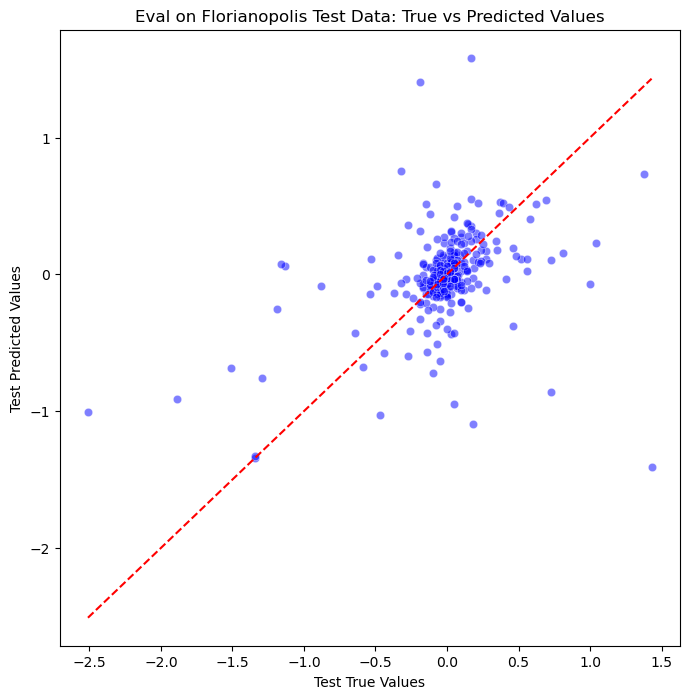

In [275]:
flori_x_train_for_plot, flori_x_test_for_plot, flori_y_train_for_plot, flori_y_test_for_plot = get_train_test_sets_for_city("Florianopolis", x_train_rand13, x_test_rand13, y_train_rand13, y_test_rand13)
eval_model(model_XGB_stratified_clean_13, flori_x_train_for_plot, flori_x_test_for_plot, flori_y_train_for_plot, flori_y_test_for_plot, "Eval on Florianopolis Test Data")

In [278]:
city_encode_mapping = {"Florianopolis":0, "Nanjing": 1 , "Rende": 2 , "Sao Paulo": 3 }

def get_train_test_sets_without_city(city, x_train, x_test, y_train, y_test):
    city_x_train = x_train[x_train['City'] != city_encode_mapping[city]]
    city_x_test = x_test[x_test['City'] != city_encode_mapping[city]]
    city_y_train = y_train[x_train['City'] != city_encode_mapping[city]]
    city_y_test = y_test[x_test['City'] != city_encode_mapping[city]]
    return city_x_train, city_x_test, city_y_train, city_y_test

Evaluating Model
Eval on 3 Cities Test Data (Without Florianopolis)
TEST -  mse: 0.12671 | rmse: 0.35596 | mae: 0.18321 | r2: 0.50675
TRAIN -  mse: 0.0388 | rmse: 0.1970 | mae: 0.1182 | r2: 0.8419


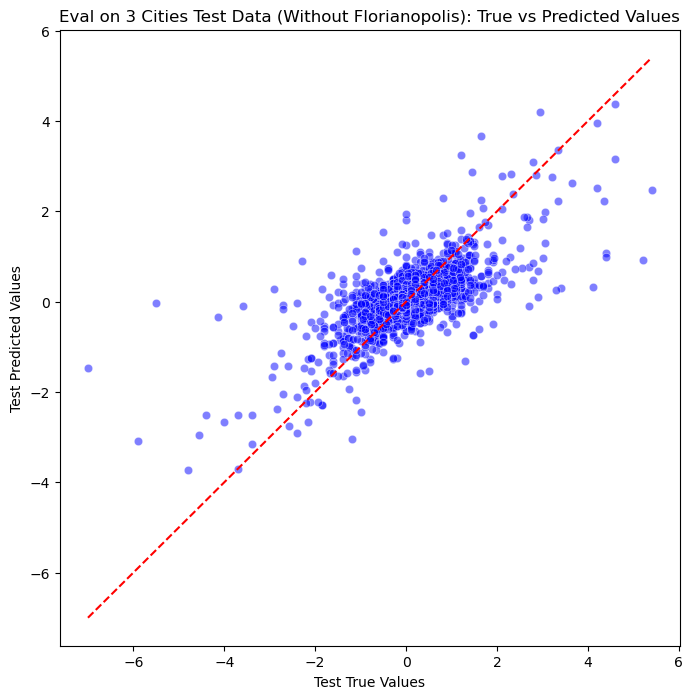

In [279]:
no_flori_x_train_for_plot, no_flori_x_test_for_plot, no_flori_y_train_for_plot, no_flori_y_test_for_plot = get_train_test_sets_without_city("Florianopolis", x_train_rand13, x_test_rand13, y_train_rand13, y_test_rand13)

eval_model(model_XGB_stratified_clean_13, no_flori_x_train_for_plot, no_flori_x_test_for_plot, no_flori_y_train_for_plot, no_flori_y_test_for_plot, "Eval on 3 Cities Test Data (Without Florianopolis)")

### Model that predicts no change

In [258]:
y.mean()
pred_0 = [0] * len(y)
mae_pred_0 = mean_absolute_error(y, pred_0)
r2_pred_0 = r2_score(y, pred_0)

print(f"mae pred 0: {mae_pred_0}")
print(f"r2_pred_0: {r2_pred_0:.3f}")

mae pred 0: 0.2558326084855514
r2_pred_0: -0.000


In [263]:
class ZeroModel:
    def predict(self, x):
        return [0] * len(x)
    
zero_model = ZeroModel()



In [264]:
add_model_results(results_df_original_method, zero_model, stratified_2022_model_data_dict, "Always predict no change, Clean Data", "Null model that always predict 0 change. Clean data stratified on City. Random seed = 2022")


Evaluating MAE of Always predict no change, Clean Data: Rende-Train
metric: 0.289
Evaluating MAE of Always predict no change, Clean Data: Rende-Test
metric: 0.302
Evaluating MAE of Always predict no change, Clean Data: Sao Paulo-Train
metric: 0.241
Evaluating MAE of Always predict no change, Clean Data: Sao Paulo-Test
metric: 0.242
Evaluating MAE of Always predict no change, Clean Data: Florianopolis-Train
metric: 0.215
Evaluating MAE of Always predict no change, Clean Data: Florianopolis-Test
metric: 0.195
Evaluating MAE of Always predict no change, Clean Data: Nanjing-Train
metric: 0.360
Evaluating MAE of Always predict no change, Clean Data: Nanjing-Test
metric: 0.356
Evaluating MAE of Always predict no change, Clean Data: All-Train
metric: 0.255
Evaluating MAE of Always predict no change, Clean Data: All-Test
metric: 0.258
Evaluating R2 of Always predict no change, Clean Data: Rende-Train
metric: -0.000
Evaluating R2 of Always predict no change, Clean Data: Rende-Test
metric: -0.00

In [266]:
results_df_original_method.to_csv("Original model results including null model.csv")

In [265]:
results_df_original_method.head(10)

Model Florianopolis-Train  \
0           Original Method, Clean Data - MAE               0.106   
1            Original Method, Clean Data - R2               0.851   
2           Original Method, Clean Data - MAE               0.092   
3            Original Method, Clean Data - R2               0.896   
4           Original Method, Clean Data - MAE               0.136   
5            Original Method, Clean Data - R2               0.729   
6           Original Method, Clean Data - MAE               0.096   
7            Original Method, Clean Data - R2               0.885   
8  Always predict no change, Clean Data - MAE               0.215   
9   Always predict no change, Clean Data - R2              -0.001   

  Florianopolis-Test Nanjing-Train Nanjing-Test Rende-Train Rende-Test  \
0              0.222         0.133        0.291       0.135      0.204   
1             -0.218         0.876        0.452        0.86      0.588   
2              0.217         0.123        0.275       0.132      0.195   
3              0.163         0.903          0.5       0.869      0.594   
4              0.192         0.165         0.28       0.156        0.2   
5               0.14         0.822        0.348       0.805      0.592   
6              0.205         0.118        0.286        0.13      0.189   
7             -0.077         0.897        0.495       0.879       0.63   
8              0.195          0.36        0.356       0.289      0.302   
9             -0.003          -0.0         -0.0        -0.0     -0.001   

  Sao Paulo-Train Sao Paulo-Test All-Train All-Test  \
0           0.123          0.172     0.126    0.186   
1           0.783          0.469     0.815    0.489   
2            0.12          0.172     0.122    0.183   
3           0.809          0.441     0.836    0.483   
4           0.147          0.173     0.149    0.184   
5           0.675          0.433     0.726    0.472   
6           0.115          0.175     0.117    0.184   
7           0.816          0.449     0.843    0.496   
8           0.241          0.242     0.255    0.258   
9            -0.0           -0.0      -0.0     -0.0   

                                         Description  
0  Reproduce model 1) Clean Data, 2) Stratify on ...  
1  Reproduce model 1) Clean Data, 2) Stratify on ...  
2  Reproduce model 1) Clean Data, 2) Stratify on ...  
3  Reproduce model 1) Clean Data, 2) Stratify on ...  
4  Reproduce model 1) Clean Data, 2) Stratify on ...  
5  Reproduce model 1) Clean Data, 2) Stratify on ...  
6  Reproduce model 1) Clean Data, 2) Stratify on ...  
7  Reproduce model 1) Clean Data, 2) Stratify on ...  
8  Null model that always predict 0 change. Clean...  
9  Null model that always predict 0 change. Clean...

## 4. Improving on Baseline - General model
Extend range of hyper params when the extreme value was selected

In [375]:
len(x_train)

33110

In [382]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 11), 
                    'n_estimators': Integer(100, 1200), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.026044666114062615), ('max_depth', 10), ('n_estimators', 1200), ('subsample', 0.6668096339544526)])


In [1064]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_V1 = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.02604, 
                            n_estimators=1200,
                            subsample=0.667,
                            colsample_bytree=1.0
                            )
model_XGB_V1.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02604, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Improved general model
TEST -  mse: 0.10901 | rmse: 0.33016 | mae: 0.16090 | r2: 0.55828
TRAIN -  mse: 0.0047 | rmse: 0.0682 | mae: 0.0446 | r2: 0.9811


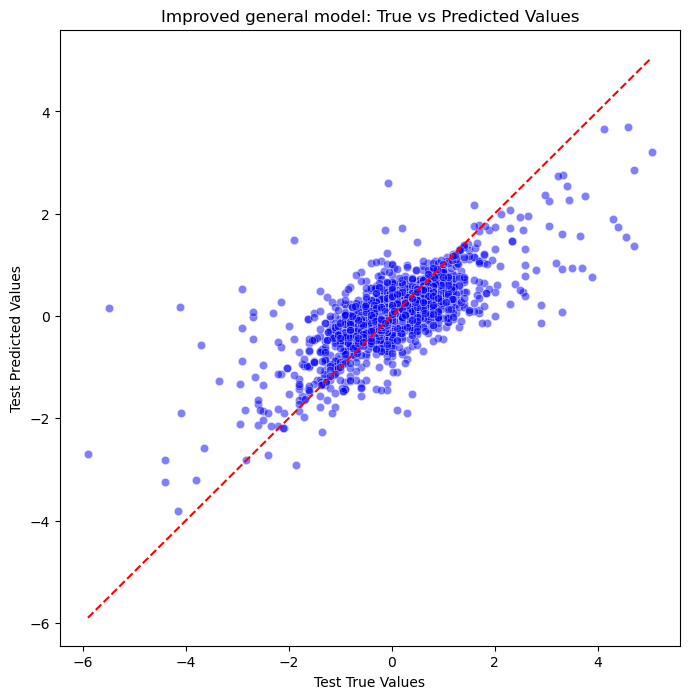

In [1472]:
eval_model(model_XGB_V1, x_train, x_test, y_train, y_test, "Improved general model")

In [1113]:
# 8. Split the dataset into training and testing sets
x_train_no_val, x_val, y_train_no_val, y_val = train_test_split(x_train, 
                                                    y_train,
                                                    test_size=0.2,
                                                    random_state=2024, stratify=x_train['City'])

In [389]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model

model_XGB_V2 = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.02604, 
                            n_estimators=1200,
                            subsample=0.667,
                            colsample_bytree=1.0,
                            early_stopping_rounds=10)
model_XGB_V2.fit(x_train_no_val,y_train_no_val, eval_set=[(x_val, y_val)])

[0]	validation_0-rmse:0.67039


[1]	validation_0-rmse:0.65902
[2]	validation_0-rmse:0.64800
[3]	validation_0-rmse:0.63713
[4]	validation_0-rmse:0.62654
[5]	validation_0-rmse:0.61635
[6]	validation_0-rmse:0.60692
[7]	validation_0-rmse:0.59752
[8]	validation_0-rmse:0.58846
[9]	validation_0-rmse:0.57982
[10]	validation_0-rmse:0.57121
[11]	validation_0-rmse:0.56269
[12]	validation_0-rmse:0.55498
[13]	validation_0-rmse:0.54709
[14]	validation_0-rmse:0.53961
[15]	validation_0-rmse:0.53256
[16]	validation_0-rmse:0.52584
[17]	validation_0-rmse:0.51936
[18]	validation_0-rmse:0.51318
[19]	validation_0-rmse:0.50687
[20]	validation_0-rmse:0.50053
[21]	validation_0-rmse:0.49485
[22]	validation_0-rmse:0.48942
[23]	validation_0-rmse:0.48412
[24]	validation_0-rmse:0.47916
[25]	validation_0-rmse:0.47457
[26]	validation_0-rmse:0.46987
[27]	validation_0-rmse:0.46521
[28]	validation_0-rmse:0.46073
[29]	validation_0-rmse:0.45645
[30]	validation_0-rmse:0.45243
[31]	validation_0-rmse:0.44827
[32]	validation_0-rmse:0.44453
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02604, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Improved General Model V2
TEST -  mse: 0.11859215698106608 | rmse: 0.3443721199241688 | mae: 0.17250857268974762 | r2: 0.5194505672411331
TRAIN -  mse: 0.03266758138796811 | rmse: 0.18074175330556055 | mae: 0.09371529669923212 | r2: 0.8672029937626171


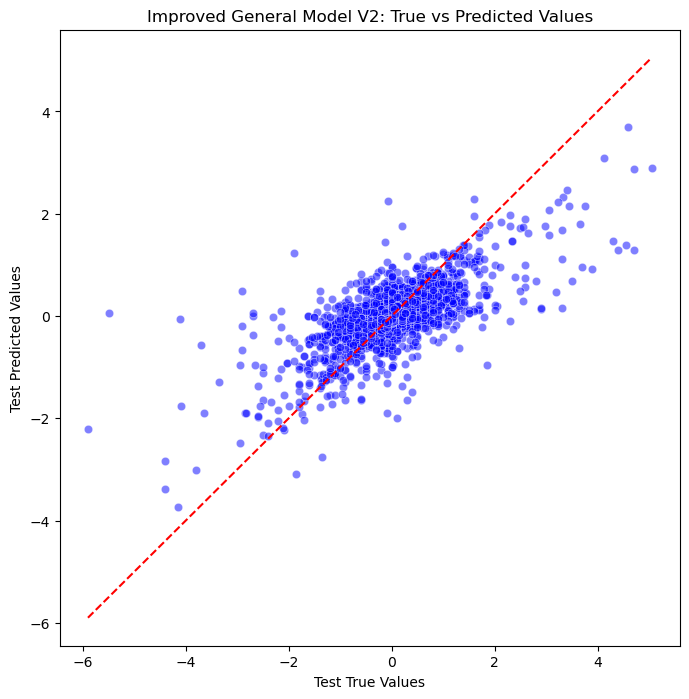

In [390]:
eval_model(model_XGB_V2, x_train, x_test, y_train, y_test, "Improved General Model V2")

### Model V2 is better than the hyperparams chosen by the paper

In [ ]:
#TODO:
# 1. Log Modulu transformation for general model improvement
# 2. Encode city with 1 hot instead of int as its categorical and not ordinal and see if theres improvement
# 3. try to do the same for rooms?
# 4. Then try the multi model

## 5. Split the data to each location separately, to have a building-specific model

In [30]:
city_encode_mapping = {"Florianopolis":0, "Nanjing": 1 , "Rende": 2 , "Sao Paulo": 3 }

def get_train_test_sets_for_city(city, x_train, x_test, y_train, y_test):
    city_x_train = x_train[x_train['City'] == city_encode_mapping[city]]
    city_x_test = x_test[x_test['City'] == city_encode_mapping[city]]
    city_y_train = y_train[x_train['City'] == city_encode_mapping[city]]
    city_y_test = y_test[x_test['City'] == city_encode_mapping[city]]
    return city_x_train, city_x_test, city_y_train, city_y_test

### Florianopolis

In [29]:
# 8. Get relevant train and test data for city
flori_x_train, flori_x_test, flori_y_train, flori_y_test = get_train_test_sets_for_city("Florianopolis", x_train, x_test, y_train, y_test)

In [394]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(flori_x_train, flori_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.1416739936677553), ('max_depth', 3), ('n_estimators', 50), ('subsample', 1.0)])


In [404]:
flori_x_train_no_val, flori_x_val, flori_y_train_no_val, flori_y_val = train_test_split(flori_x_train, 
                                                    flori_y_train,
                                                    test_size=0.2,
                                                    random_state=2024)

model_XGB_flori = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=3, 
                            learning_rate=0.14167, 
                            n_estimators=50, 
                            subsample= 1.0, 
                            colsample_bytree=1.0, #,
                            early_stopping_rounds=10)

model_XGB_flori.fit(flori_x_train_no_val,flori_y_train_no_val, eval_set=[(flori_x_val, flori_y_val)])

# model_XGB_flori.fit(flori_x_train,flori_y_train)

[0]	validation_0-rmse:0.56654
[1]	validation_0-rmse:0.52005
[2]	validation_0-rmse:0.47968
[3]	validation_0-rmse:0.44596
[4]	validation_0-rmse:0.42003
[5]	validation_0-rmse:0.40204
[6]	validation_0-rmse:0.38143
[7]	validation_0-rmse:0.37320
[8]	validation_0-rmse:0.36233
[9]	validation_0-rmse:0.35447
[10]	validation_0-rmse:0.34852
[11]	validation_0-rmse:0.34357


[12]	validation_0-rmse:0.34039
[13]	validation_0-rmse:0.33587
[14]	validation_0-rmse:0.33289
[15]	validation_0-rmse:0.33284
[16]	validation_0-rmse:0.33059
[17]	validation_0-rmse:0.33060
[18]	validation_0-rmse:0.32885
[19]	validation_0-rmse:0.32958
[20]	validation_0-rmse:0.32864
[21]	validation_0-rmse:0.32881
[22]	validation_0-rmse:0.32690
[23]	validation_0-rmse:0.32726
[24]	validation_0-rmse:0.32664
[25]	validation_0-rmse:0.32642
[26]	validation_0-rmse:0.32657
[27]	validation_0-rmse:0.32639
[28]	validation_0-rmse:0.32599
[29]	validation_0-rmse:0.32593
[30]	validation_0-rmse:0.32633
[31]	validation_0-rmse:0.32609
[32]	validation_0-rmse:0.32508
[33]	validation_0-rmse:0.32536
[34]	validation_0-rmse:0.32457
[35]	validation_0-rmse:0.32468
[36]	validation_0-rmse:0.32463
[37]	validation_0-rmse:0.32490
[38]	validation_0-rmse:0.32449
[39]	validation_0-rmse:0.32433
[40]	validation_0-rmse:0.32381
[41]	validation_0-rmse:0.32386
[42]	validation_0-rmse:0.32413
[43]	validation_0-rmse:0.32457
[44]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.14167, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=2000, ...)

Evaluating Model
Florianopolis Model+Data
TEST -  mse: 0.14857294601598167 | rmse: 0.3854516130670381 | mae: 0.1899184947467302 | r2: 0.0704899770589894
TRAIN -  mse: 0.09873528812738232 | rmse: 0.3142217181026517 | mae: 0.1588869108552461 | r2: 0.5450106280671314


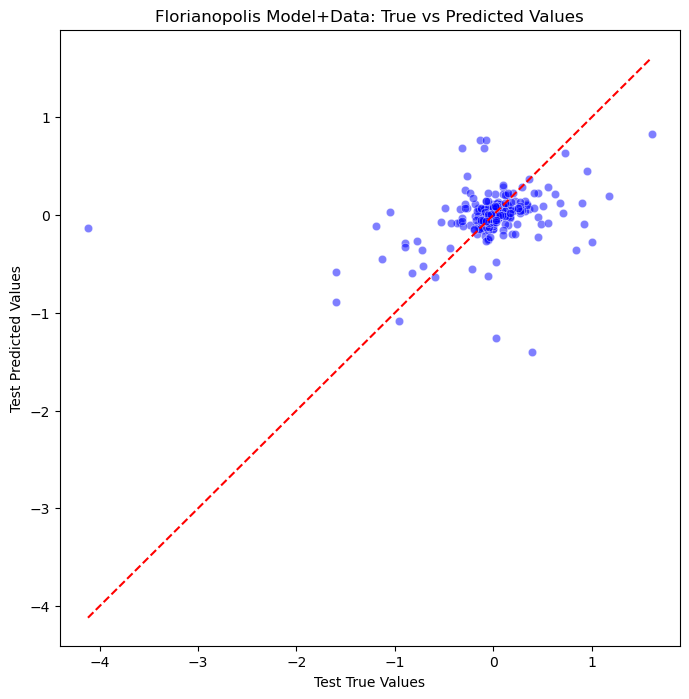

In [405]:
eval_model(model_XGB_flori, flori_x_train, flori_x_test, flori_y_train, flori_y_test, "Florianopolis Model+Data")

Evaluating Model
General Model, Florianopolis Data
TEST -  mse: 0.19465385386569425 | rmse: 0.4411959359124858 | mae: 0.22202801935316718 | r2: -0.21780386688162623
TRAIN -  mse: 0.03237637830517016 | rmse: 0.17993437221712297 | mae: 0.10603990680368787 | r2: 0.8508040204275761


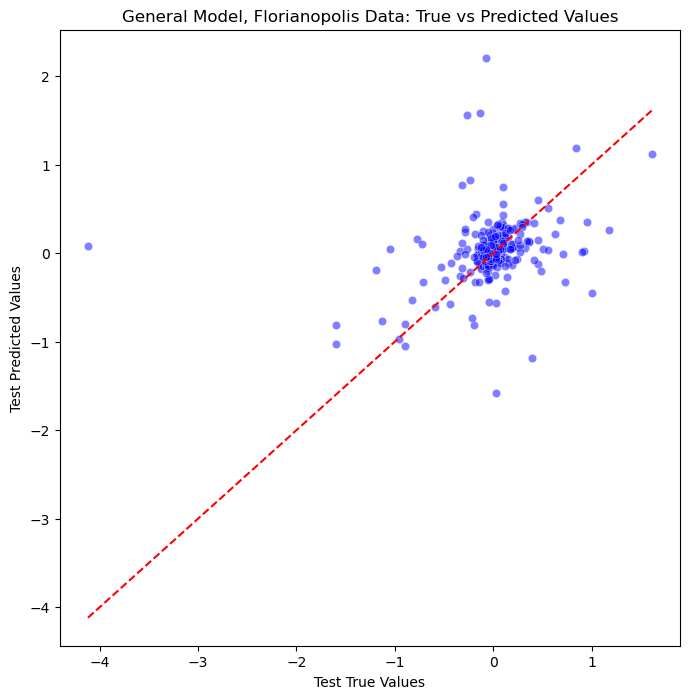

In [449]:
eval_model(model_XGB_stratified_clean, flori_x_train, flori_x_test, flori_y_train, flori_y_test, "General Model, Florianopolis Data")

### Sau Paulo

In [97]:
# 8. Split the dataset into training and testing sets
sp_x_train, sp_x_test, sp_y_train, sp_y_test = get_train_test_sets_for_city("Sao Paulo", x_train, x_test, y_train, y_test)

In [412]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(4, 10), 
                    'n_estimators': Integer(300, 1000), 
                    'learning_rate': (0.01, 0.3, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=4)
opt.fit(sp_x_train, sp_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.027692439884294828), ('max_depth', 10), ('n_estimators', 1000), ('subsample', 0.696589705069298)])


In [413]:
sp_x_train_no_val, sp_x_val, sp_y_train_no_val, sp_y_val = train_test_split(sp_x_train, 
                                                    sp_y_train,
                                                    test_size=0.2,
                                                    random_state=2024)

model_XGB_sp = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.02769, 
                            n_estimators=1000, 
                            subsample= 0.6966, 
                            colsample_bytree=1.0,
                            early_stopping_rounds=10)

model_XGB_sp.fit(sp_x_train_no_val,sp_y_train_no_val, eval_set=[(sp_x_val, sp_y_val)])

[0]	validation_0-rmse:0.66873
[1]	validation_0-rmse:0.65629
[2]	validation_0-rmse:0.64437
[3]	validation_0-rmse:0.63281
[4]	validation_0-rmse:0.62166
[5]	validation_0-rmse:0.61100
[6]	validation_0-rmse:0.60071
[7]	validation_0-rmse:0.59105
[8]	validation_0-rmse:0.58137
[9]	validation_0-rmse:0.57193
[10]	validation_0-rmse:0.56293
[11]	validation_0-rmse:0.55431
[12]	validation_0-rmse:0.54590
[13]	validation_0-rmse:0.53786
[14]	validation_0-rmse:0.53018
[15]	validation_0-rmse:0.52269
[16]	validation_0-rmse:0.51611
[17]	validation_0-rmse:0.50935
[18]	validation_0-rmse:0.50269
[19]	validation_0-rmse:0.49637
[20]	validation_0-rmse:0.49029
[21]	validation_0-rmse:0.48443
[22]	validation_0-rmse:0.47870
[23]	validation_0-rmse:0.47284
[24]	validation_0-rmse:0.46727
[25]	validation_0-rmse:0.46249
[26]	validation_0-rmse:0.45702
[27]	validation_0-rmse:0.45226
[28]	validation_0-rmse:0.44754
[29]	validation_0-rmse:0.44317
[30]	validation_0-rmse:0.43858
[31]	validation_0-rmse:0.43477
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02769, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Sau Paolo Model+Data
TEST -  mse: 0.0972765325709483 | rmse: 0.31189186037944033 | mae: 0.15253035904522377 | r2: 0.5324333932379327
TRAIN -  mse: 0.026784119295911707 | rmse: 0.16365854483011788 | mae: 0.08138529356654757 | r2: 0.868481711465258


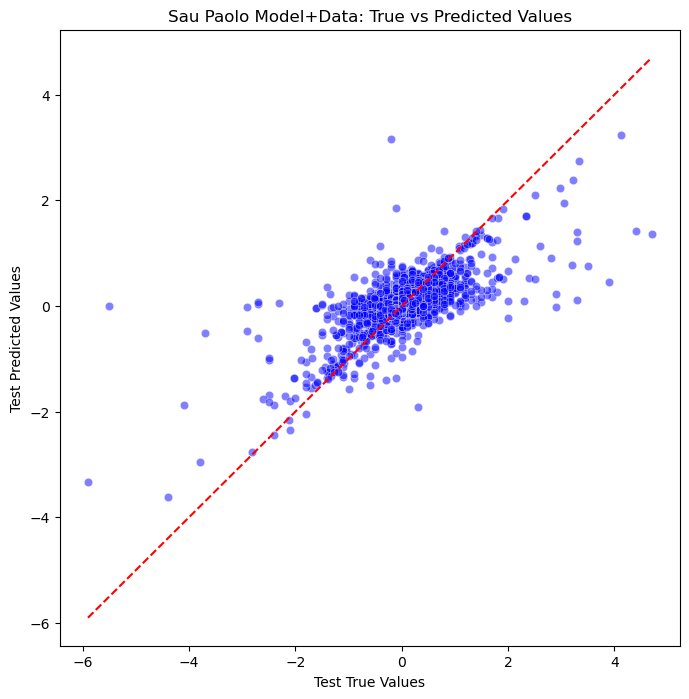

In [427]:
eval_model(model_XGB_sp, sp_x_train, sp_x_test, sp_y_train, sp_y_test, "Sau Paolo Model+Data")

Evaluating Model
General Model, Sau Paolo Data
TEST -  mse: 0.09904612461053226 | rmse: 0.31471594273333575 | mae: 0.15652579566392236 | r2: 0.5239277226159049
TRAIN -  mse: 0.030445648942414822 | rmse: 0.1744868159558619 | mae: 0.09056696137816622 | r2: 0.8505024713339309


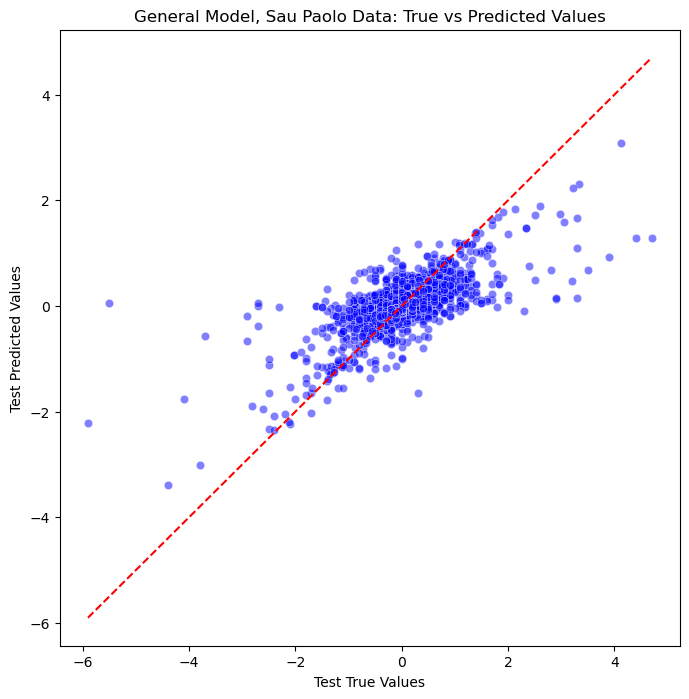

In [426]:
eval_model(model_XGB_V2, sp_x_train, sp_x_test, sp_y_train, sp_y_test, "General Model, Sau Paolo Data")

### Nanging

In [32]:
# 8. Split the dataset into training and testing sets
nanging_x_train, nanging_x_test, nanging_y_train, nanging_y_test = get_train_test_sets_for_city("Nanjing", x_train, x_test, y_train, y_test)

In [295]:
len(nanging_x_train) + len(nanging_x_test)

1800

In [297]:
len(rende_x_train) + len(rende_x_test)

8450

In [298]:
len(sp_x_train) + len(sp_x_test)

29612

In [296]:
len(flori_x_train) + len(flori_x_test)

1526

In [429]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(nanging_x_train, nanging_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.7409651871697948), ('learning_rate', 0.030800507371932583), ('max_depth', 10), ('n_estimators', 155), ('subsample', 0.6946157388081635)])


In [430]:
nanging_x_train_no_val, nanging_x_val, nanging_y_train_no_val, nanging_y_val = train_test_split(nanging_x_train, 
                                                    nanging_y_train,
                                                    test_size=0.2,
                                                    random_state=2024)

model_XGB_nanging_early_stopping = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0308, 
                            n_estimators=155, 
                            subsample= 0.695, 
                            colsample_bytree=0.74,
                            early_stopping_rounds=10)

model_XGB_nanging_early_stopping.fit(nanging_x_train_no_val,nanging_y_train_no_val, eval_set=[(nanging_x_val, nanging_y_val)])


model_XGB_nanging = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0308, 
                            n_estimators=155, 
                            subsample= 0.695, 
                            colsample_bytree=0.74)

model_XGB_nanging.fit(nanging_x_train,nanging_y_train)

[0]	validation_0-rmse:0.74919
[1]	validation_0-rmse:0.73686


[2]	validation_0-rmse:0.72433
[3]	validation_0-rmse:0.70906
[4]	validation_0-rmse:0.69354
[5]	validation_0-rmse:0.67872
[6]	validation_0-rmse:0.66390
[7]	validation_0-rmse:0.65055
[8]	validation_0-rmse:0.63894
[9]	validation_0-rmse:0.62559
[10]	validation_0-rmse:0.61425
[11]	validation_0-rmse:0.60186
[12]	validation_0-rmse:0.59121
[13]	validation_0-rmse:0.58076
[14]	validation_0-rmse:0.57006
[15]	validation_0-rmse:0.55957
[16]	validation_0-rmse:0.55186
[17]	validation_0-rmse:0.54271
[18]	validation_0-rmse:0.53468
[19]	validation_0-rmse:0.53007
[20]	validation_0-rmse:0.52124
[21]	validation_0-rmse:0.51297
[22]	validation_0-rmse:0.50554
[23]	validation_0-rmse:0.49952
[24]	validation_0-rmse:0.49207
[25]	validation_0-rmse:0.48726
[26]	validation_0-rmse:0.48149
[27]	validation_0-rmse:0.47476
[28]	validation_0-rmse:0.46740
[29]	validation_0-rmse:0.46007
[30]	validation_0-rmse:0.45495
[31]	validation_0-rmse:0.44963
[32]	validation_0-rmse:0.44366
[33]	validation_0-rmse:0.43739
[34]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.74, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0308, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=155, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Nanging Model+Data
TEST -  mse: 0.15036706836532657 | rmse: 0.3877719282843029 | mae: 0.2331439755158499 | r2: 0.5856966083661376
TRAIN -  mse: 0.007802491809707323 | rmse: 0.08833171463131077 | mae: 0.05707434278252347 | r2: 0.9782720985806533


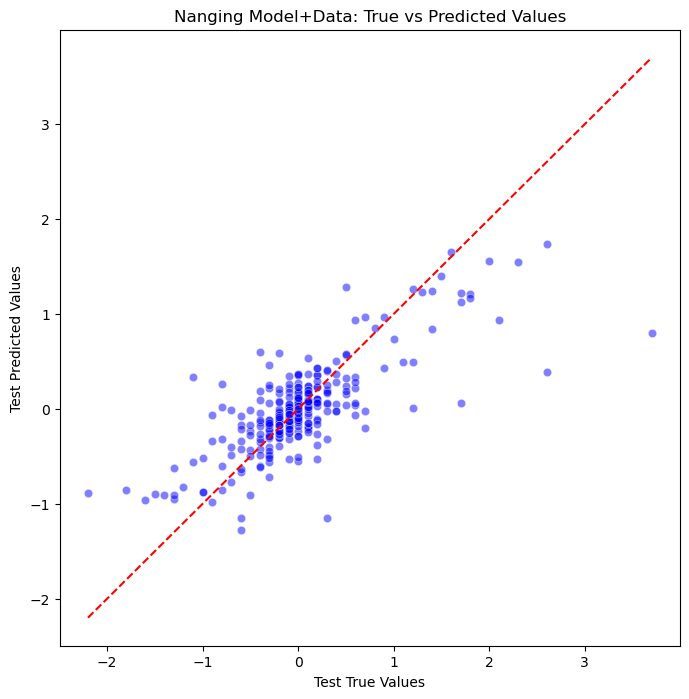

Evaluating Model
Nanging Early Stopping Model+Data
TEST -  mse: 0.15486265594862114 | rmse: 0.3935259279242235 | mae: 0.23571737758926853 | r2: 0.5733100053459812
TRAIN -  mse: 0.027498651026262127 | rmse: 0.16582717215903467 | mae: 0.08593638740463375 | r2: 0.9234234404552291


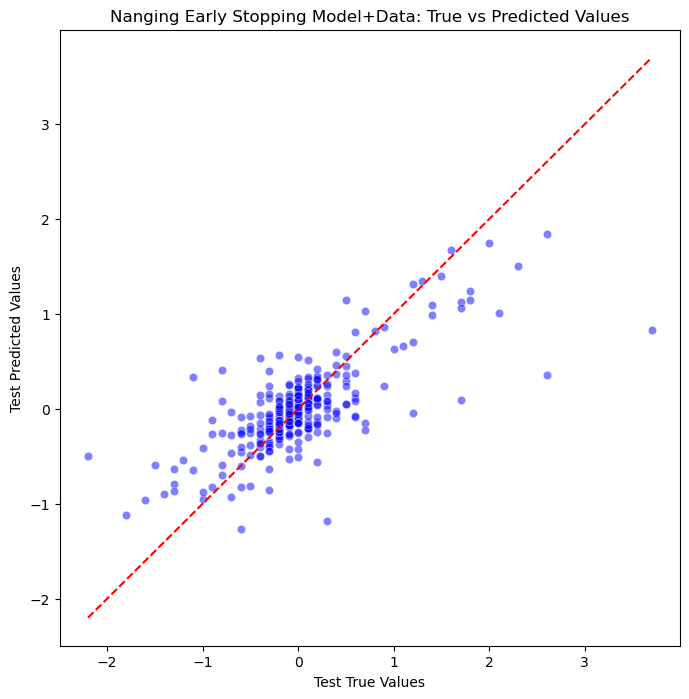

In [433]:
eval_model(model_XGB_nanging, nanging_x_train, nanging_x_test, nanging_y_train, nanging_y_test, "Nanging Model+Data")
eval_model(model_XGB_nanging_early_stopping, nanging_x_train, nanging_x_test, nanging_y_train, nanging_y_test, "Nanging Early Stopping Model+Data")

Evaluating Model
General Model, Nanging Data
TEST -  mse: 0.18902221181995135 | rmse: 0.4347668476550982 | mae: 0.2667706128861432 | r2: 0.47919086072174544
TRAIN -  mse: 0.04118197134443172 | rmse: 0.2029334160369645 | mae: 0.10666160810815199 | r2: 0.8853189679080564


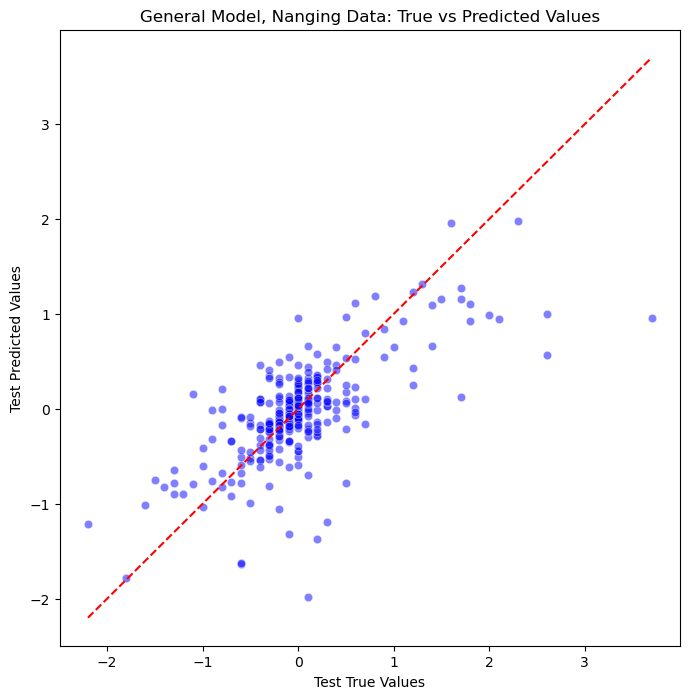

In [432]:
eval_model(model_XGB_V2, nanging_x_train, nanging_x_test, nanging_y_train, nanging_y_test, "General Model, Nanging Data")

### Rende

In [33]:
# 8. Split the dataset into training and testing sets
rende_x_train, rende_x_test, rende_y_train, rende_y_test = get_train_test_sets_for_city("Rende", x_train, x_test, y_train, y_test)

In [436]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(100, 800), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(rende_x_train, rende_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01962658656100501), ('max_depth', 8), ('n_estimators', 523), ('subsample', 0.5)])


In [443]:
rende_x_train_no_val, rende_x_val, rende_y_train_no_val, rende_y_val = train_test_split(rende_x_train, 
                                                    rende_y_train,
                                                    test_size=0.2,
                                                    random_state=2024)

model_XGB_rende_early_stopping = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=8, 
                            learning_rate=0.0196, 
                            n_estimators=523, 
                            subsample= 0.5, 
                            colsample_bytree=1.0,
                            early_stopping_rounds=10)

model_XGB_rende_early_stopping.fit(rende_x_train_no_val,rende_y_train_no_val, eval_set=[(rende_x_val, rende_y_val)])


model_XGB_rende = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                            max_depth=8, 
                            learning_rate=0.0196, 
                            n_estimators=523, 
                            subsample= 0.5, 
                            colsample_bytree=1.0)

model_XGB_rende.fit(rende_x_train,rende_y_train)

[0]	validation_0-rmse:0.81792
[1]	validation_0-rmse:0.80776


[2]	validation_0-rmse:0.79786
[3]	validation_0-rmse:0.78846
[4]	validation_0-rmse:0.77872
[5]	validation_0-rmse:0.76836
[6]	validation_0-rmse:0.75951
[7]	validation_0-rmse:0.75038
[8]	validation_0-rmse:0.74183
[9]	validation_0-rmse:0.73281
[10]	validation_0-rmse:0.72462
[11]	validation_0-rmse:0.71791
[12]	validation_0-rmse:0.71007
[13]	validation_0-rmse:0.70209
[14]	validation_0-rmse:0.69481
[15]	validation_0-rmse:0.68642
[16]	validation_0-rmse:0.67915
[17]	validation_0-rmse:0.67299
[18]	validation_0-rmse:0.66632
[19]	validation_0-rmse:0.65980
[20]	validation_0-rmse:0.65392
[21]	validation_0-rmse:0.64713
[22]	validation_0-rmse:0.64054
[23]	validation_0-rmse:0.63393
[24]	validation_0-rmse:0.62726
[25]	validation_0-rmse:0.62149
[26]	validation_0-rmse:0.61610
[27]	validation_0-rmse:0.61181
[28]	validation_0-rmse:0.60825
[29]	validation_0-rmse:0.60259
[30]	validation_0-rmse:0.59760
[31]	validation_0-rmse:0.59241
[32]	validation_0-rmse:0.58833
[33]	validation_0-rmse:0.58288
[34]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0196, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=523, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Rende Model+Data
TEST -  mse: 0.15705337605296263 | rmse: 0.3962996039021016 | mae: 0.19756122811592888 | r2: 0.579182527527625
TRAIN -  mse: 0.026998648806777322 | rmse: 0.16431265565006647 | mae: 0.10048625108047732 | r2: 0.9280932206573335


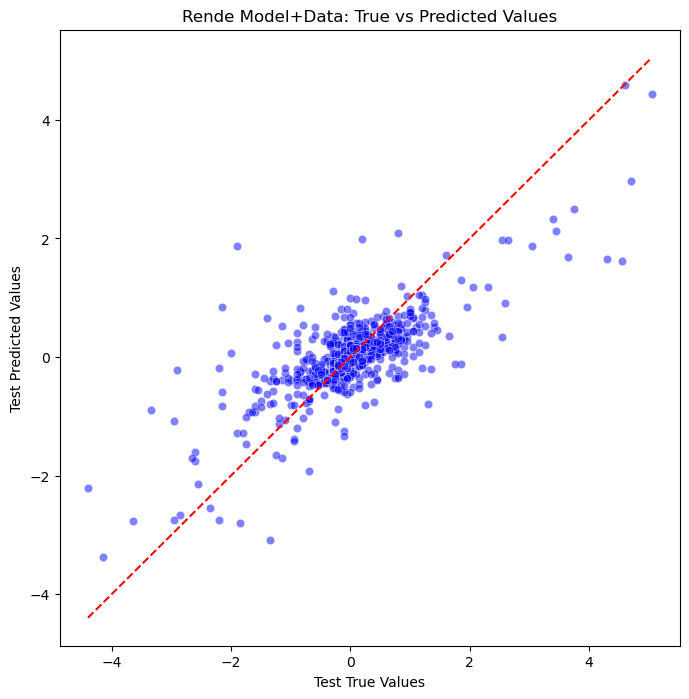

In [444]:
eval_model(model_XGB_rende, rende_x_train, rende_x_test, rende_y_train, rende_y_test, "Rende Model+Data")

Evaluating Model
Rende Model+Data, Early Stopping
TEST -  mse: 0.1614249050933702 | rmse: 0.4017771833907075 | mae: 0.20139869378452496 | r2: 0.5674692116610273
TRAIN -  mse: 0.046297256266273464 | rmse: 0.21516797221304443 | mae: 0.11436594122273272 | r2: 0.8766943259147795


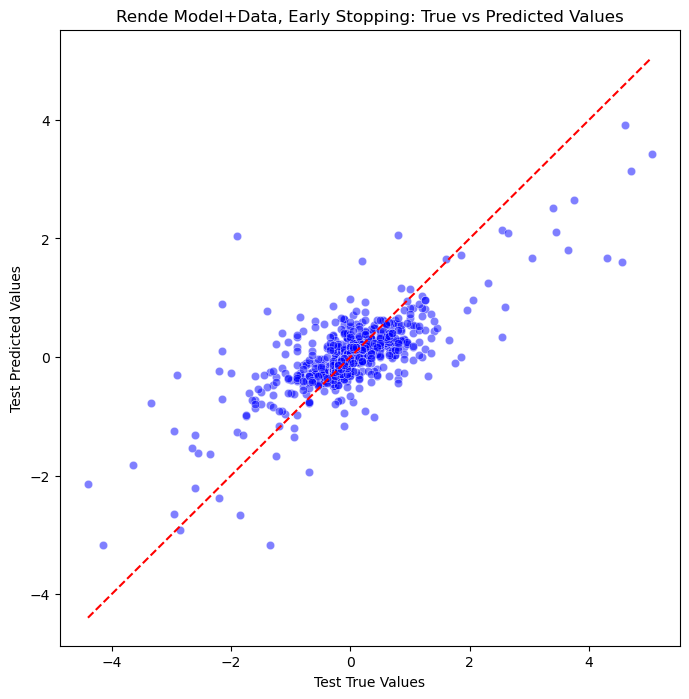

In [445]:
eval_model(model_XGB_rende_early_stopping, rende_x_train, rende_x_test, rende_y_train, rende_y_test, "Rende Model+Data, Early Stopping")

Evaluating Model
General Model, Rende Data
TEST -  mse: 0.16223660867109038 | rmse: 0.4027860581885753 | mae: 0.20212577996361036 | r2: 0.5652942883543306
TRAIN -  mse: 0.03896637223345001 | rmse: 0.19739901781277944 | mae: 0.1043653871843806 | r2: 0.8962190163653101


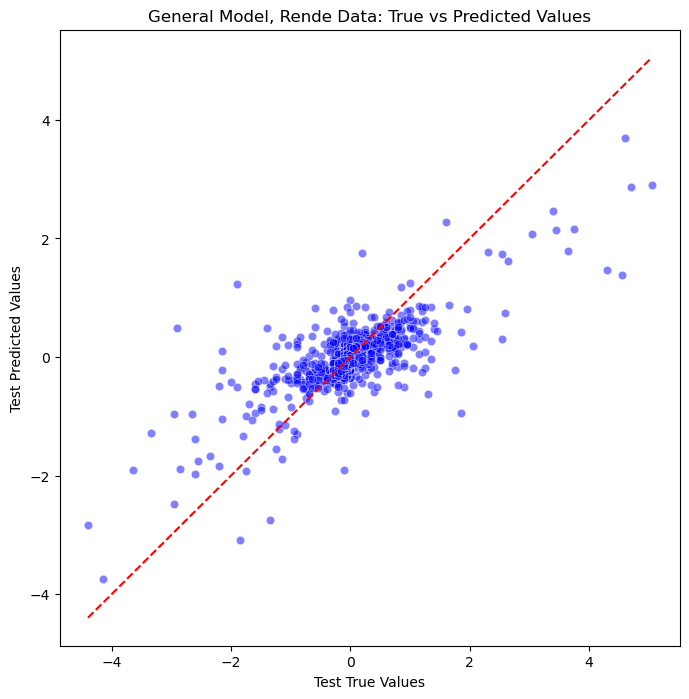

In [448]:
eval_model(model_XGB_V2, rende_x_train, rende_x_test, rende_y_train, rende_y_test, "General Model, Rende Data")

## 6. Tranform Target Col

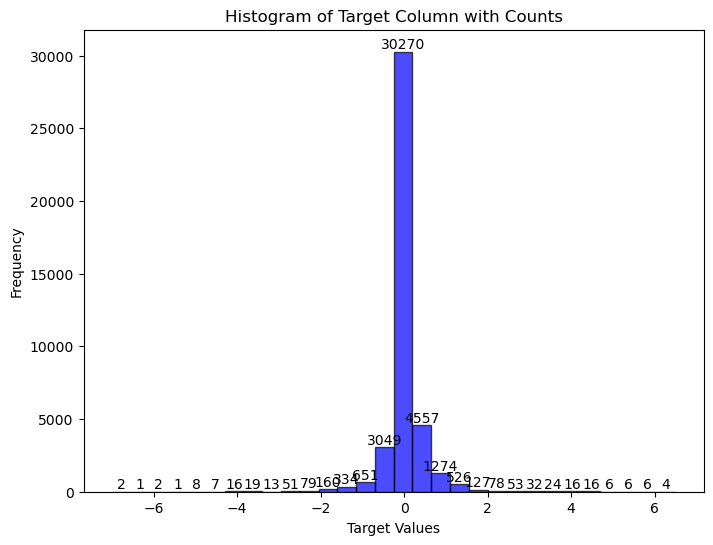

In [451]:
plot_target_col_hist(y)

In [500]:
transformed_target = np.sign(filtered_data['Differ_Indoor_Temp']) * np.log1p(np.abs(filtered_data['Differ_Indoor_Temp']))


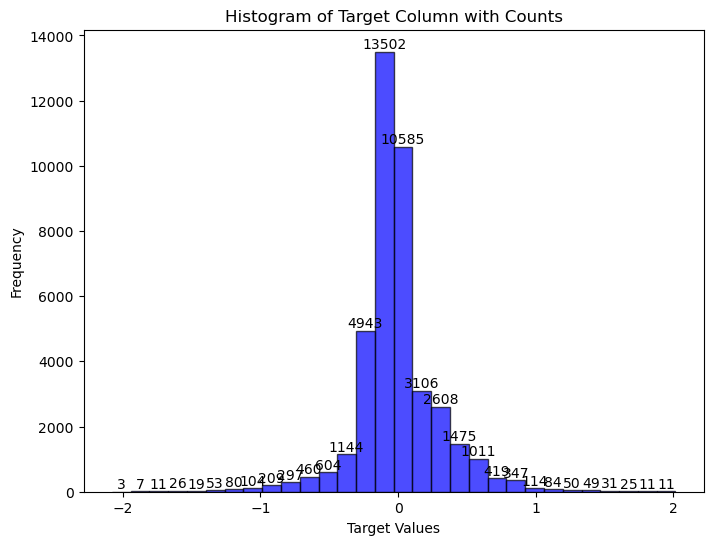

In [501]:
plot_target_col_hist(transformed_target)

In [502]:
def transform_back(col):
    return np.sign(col) * (np.expm1(np.abs(col)))

In [504]:
check_y = transform_back(transformed_target)

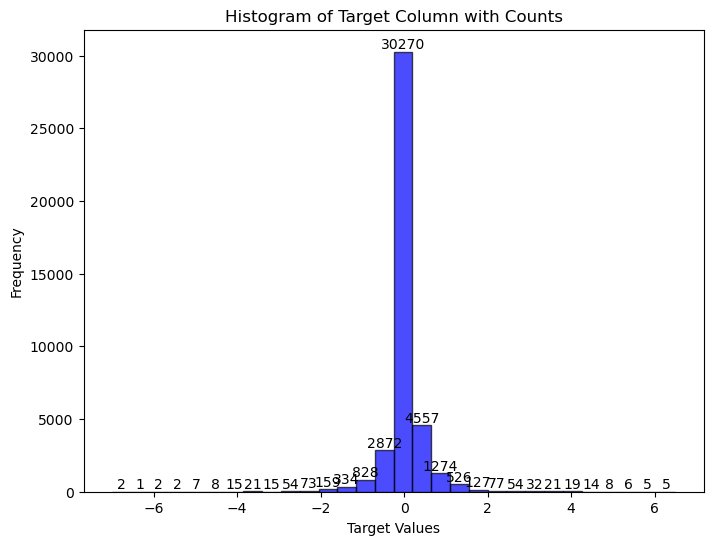

In [505]:
plot_target_col_hist(check_y)

In [511]:
x.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Room_ID', 'City', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Target_Temp'],
      dtype='object')

### Now, train a V3 version of the original XGBoost, to learn the log modulu of the target. Then transform back for evaluation

In [519]:
from sklearn.base import BaseEstimator, RegressorMixin

class XGBTransformedTargetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, transform_fn, inverse_transform_fn):
        self.model = model
        self.transform_fn = transform_fn
        self.inverse_transform_fn = inverse_transform_fn

    def fit(self, X, y):
        # Apply transformation to the target variable
        y_transformed = self.transform_fn(y)
        # Fit the model on the transformed target
        self.model.fit(X, y_transformed)
        return self

    def predict(self, X):
        # Predict using the model (which predicts on the transformed scale)
        y_pred_transformed = self.model.predict(X)
        # Apply the inverse transformation to return to the original scale
        return self.inverse_transform_fn(y_pred_transformed)

# Example usage:
# Assuming 'log_mod' and 'inverse_log_mod' are your transformation functions

def log_mod_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_log_mod_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

In [523]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 11), 
                    'n_estimators': Integer(100, 1200), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.030387949221241405), ('max_depth', 9), ('n_estimators', 1200), ('subsample', 0.8187556877678255)])


In [524]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
xgb_model_V3_for_wrap = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=9, 
                            learning_rate=0.0304, 
                            n_estimators=1200,
                            subsample=0.819,
                            colsample_bytree=1.0)

# Wrap the XGBRegressor with the transformation logic
model_XGB_V3 = XGBTransformedTargetRegressor(model=xgb_model_V3_for_wrap, 
                                              transform_fn=log_mod_transform, 
                                              inverse_transform_fn=inverse_log_mod_transform)


model_XGB_V3.fit(x_train,y_train)

XGBTransformedTargetRegressor(inverse_transform_fn=<function inverse_log_mod_transform at 0x1a1165940>,
                              model=XGBRegressor(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=1.0,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 gpu_id=None, grow_polic...
                                                 interaction_constraints=None,
                                                 learning_rate=0.0304,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=9, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=1200, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=2000, ...),
                              transform_fn=<function log_mod_transform at 0x1a1287ce0>)

Evaluating Model
General Model, with transformed target
TEST -  mse: 0.11297117862415276 | rmse: 0.3361118543344652 | mae: 0.15900679063183443 | r2: 0.542227435709727
TRAIN -  mse: 0.00966192984057867 | rmse: 0.09829511605659089 | mae: 0.055092175342151106 | r2: 0.9607232827534317


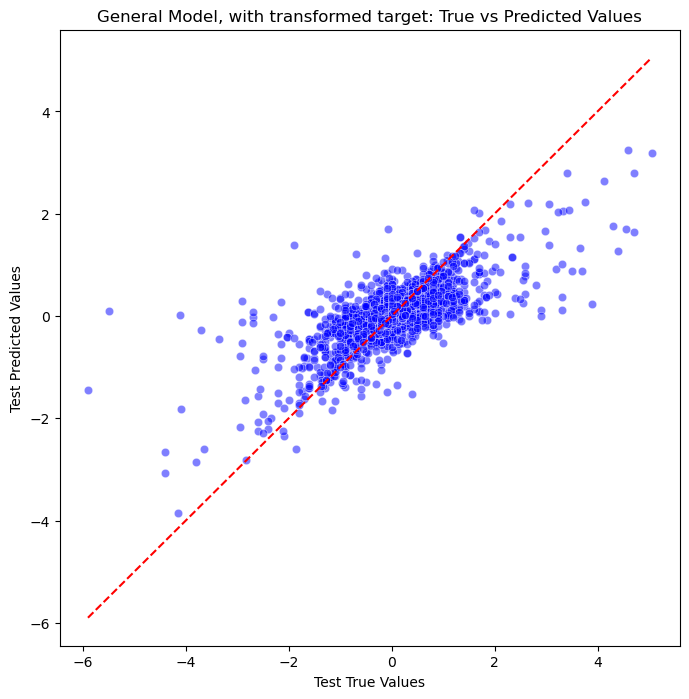

In [525]:
eval_model(model_XGB_V3, x_train, x_test, y_train, y_test, "General Model, with transformed target")

### Conclution: Don't Transform! Transformation doesn't have better results than model V1, which is the same without transformation. Therefore, it is not improving and we don't need the log transform!

## 7. Examine City Feature

In [528]:
x_no_city = x.drop(columns=['City'])

In [544]:
x.Room_ID.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

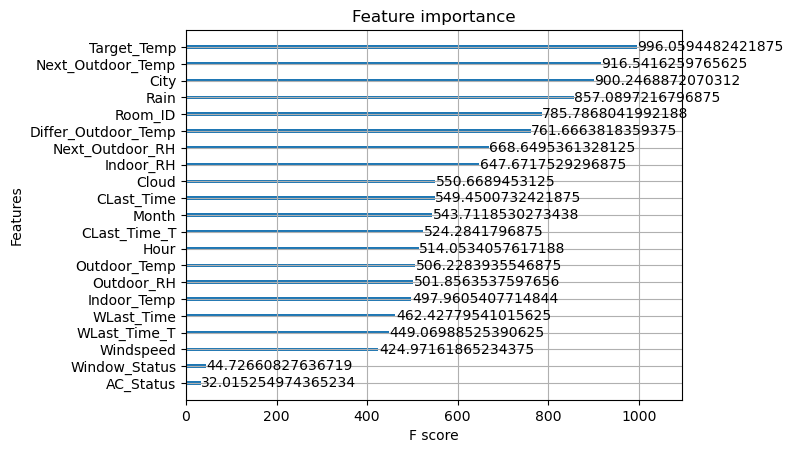

In [1486]:
xgb.plot_importance(model_XGB_V1, importance_type='cover')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

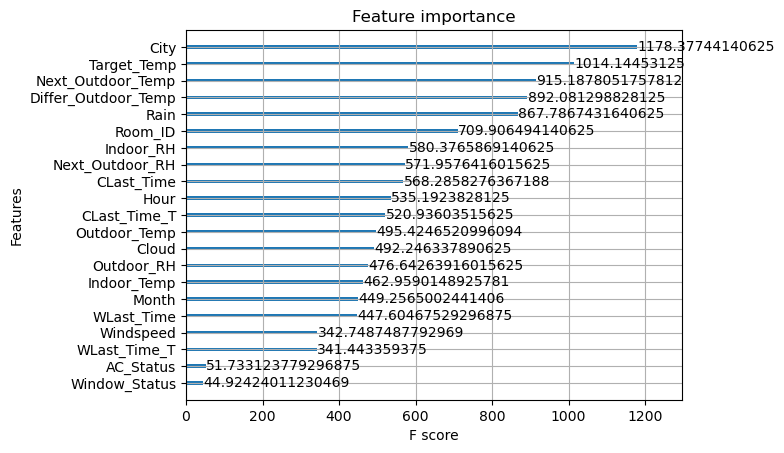

In [552]:
xgb.plot_importance(model_XGB_V2, importance_type='cover')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

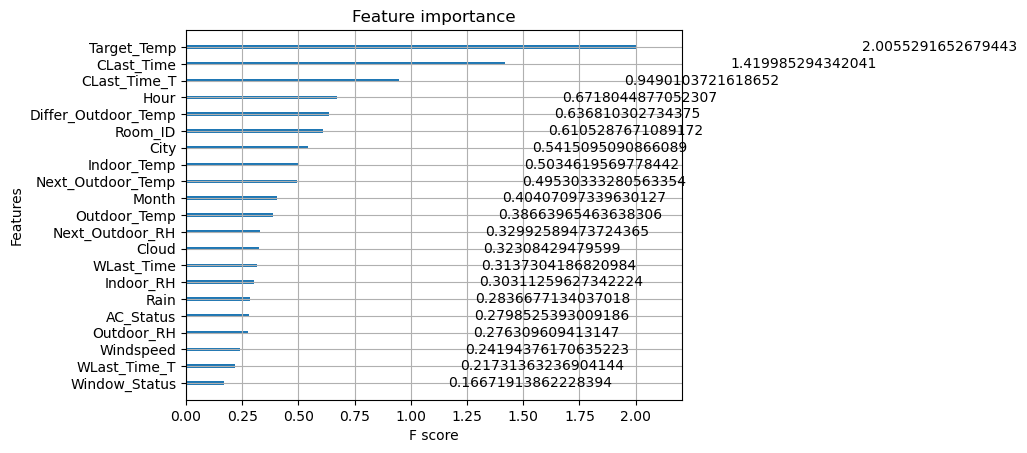

In [553]:
xgb.plot_importance(model_XGB_V2, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

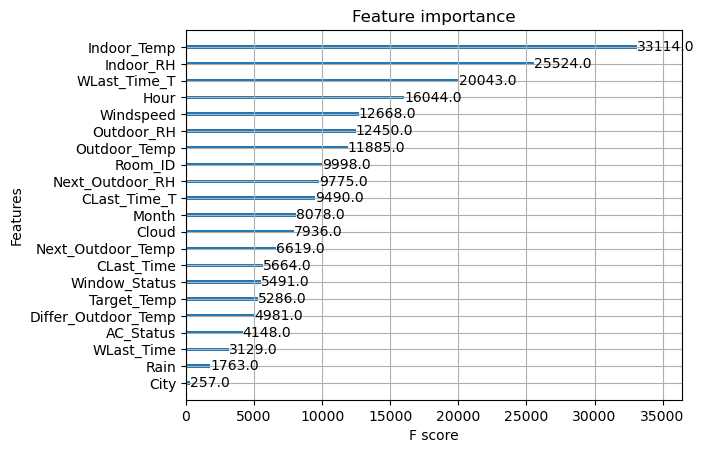

In [554]:
xgb.plot_importance(model_XGB_V2, importance_type='weight')

### Note: City feature has lowest weight, but highest cover and 7 highest gain. 
Low weight + High gain + High cover means the feature is rarely used but when it is, it creates splits that are both impactful (large improvement in accuracy) and affect a large portion of the data.
### Room_ID feature has fairly high rank in all 3 measures.

### NOTE: both features are not encoded correctly: They are encoded as ordinal while being used as nominal features. Let's see if encoding them as one hot can improve the model!

### Hour is an important feature!
It is very weird to note how important is the hour of the day in predicting the next temp. How is it more relevant than the target temp/AC status/Window status? Very weird

In [74]:
city_reverse_encode_mapping = {0: "Florianopolis", 1: "Nanjing" , 2: "Rende", 3: "Sao Paulo"}

def onehot_encode_city_room(raw_data):
    data_onehot = pd.get_dummies(raw_data, columns=['City', 'Room_ID'], prefix=['City_', 'Room_'], dtype=float)
    data_onehot.rename(columns={f'City__{k}': f'City__{v}' for k, v in city_reverse_encode_mapping.items()}, inplace=True)
    return data_onehot


In [1101]:
x_train_encoded = onehot_encode_city_room(x_train)
x_test_encoded = onehot_encode_city_room(x_test)

In [583]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 11), 
                    'n_estimators': Integer(100, 1200), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train_encoded, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.8702091857924245), ('learning_rate', 0.028797570778804706), ('max_depth', 10), ('n_estimators', 1200), ('subsample', 0.7251370857661357)])


In [584]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_V1_encoded = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0288, 
                            n_estimators=1200,
                            subsample=0.725,
                            colsample_bytree= 0.87
                            )
model_XGB_V1_encoded.fit(x_train_encoded,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.87, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0288, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

### Note this is my best model so far!!!

Evaluating Model
General model, better encoding
TEST -  mse: 0.10693309661098628 | rmse: 0.32700626387117765 | mae: 0.15792453090808545 | r2: 0.5666944574778017
TRAIN -  mse: 0.0043895713377850075 | rmse: 0.06625384017387224 | mae: 0.04381037736036381 | r2: 0.9821559507145524


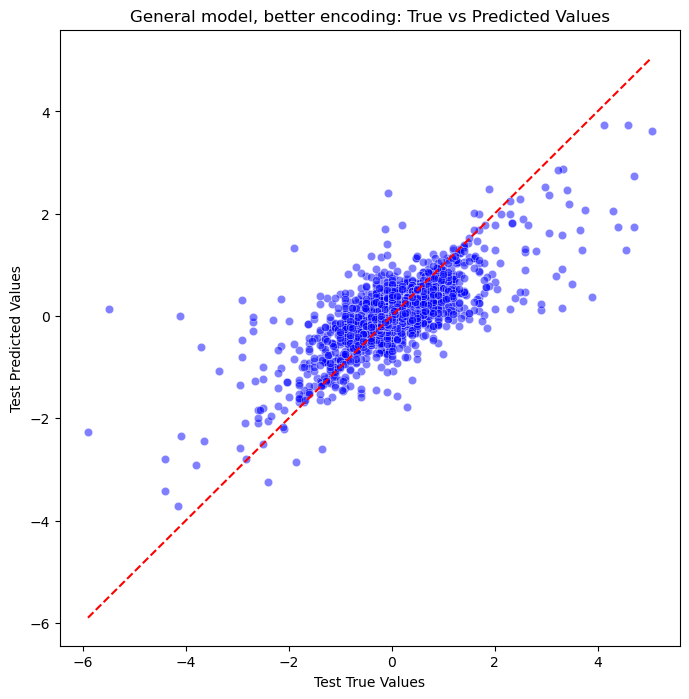

In [586]:
eval_model(model_XGB_V1_encoded, x_train_encoded, x_test_encoded, y_train, y_test, "General model, better encoding")

In [593]:
x_train_no_val_encoded = onehot_encode_city_room(x_train_no_val)
x_val_encoded = onehot_encode_city_room(x_val)

In [594]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model

model_XGB_V2_encoded = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0288, 
                            n_estimators=1200,
                            subsample=0.725,
                            colsample_bytree= 0.87,
                            early_stopping_rounds=10)
model_XGB_V2_encoded.fit(x_train_no_val_encoded, y_train_no_val, eval_set=[(x_val_encoded, y_val)])

[0]	validation_0-rmse:0.66867


[1]	validation_0-rmse:0.65650
[2]	validation_0-rmse:0.64476
[3]	validation_0-rmse:0.63337
[4]	validation_0-rmse:0.62203
[5]	validation_0-rmse:0.61166
[6]	validation_0-rmse:0.60087
[7]	validation_0-rmse:0.59032
[8]	validation_0-rmse:0.58068
[9]	validation_0-rmse:0.57151
[10]	validation_0-rmse:0.56236
[11]	validation_0-rmse:0.55388
[12]	validation_0-rmse:0.54560
[13]	validation_0-rmse:0.53739
[14]	validation_0-rmse:0.52935
[15]	validation_0-rmse:0.52147
[16]	validation_0-rmse:0.51467
[17]	validation_0-rmse:0.50753
[18]	validation_0-rmse:0.50085
[19]	validation_0-rmse:0.49413
[20]	validation_0-rmse:0.48791
[21]	validation_0-rmse:0.48179
[22]	validation_0-rmse:0.47580
[23]	validation_0-rmse:0.47065
[24]	validation_0-rmse:0.46555
[25]	validation_0-rmse:0.46073
[26]	validation_0-rmse:0.45586
[27]	validation_0-rmse:0.45123
[28]	validation_0-rmse:0.44663
[29]	validation_0-rmse:0.44220
[30]	validation_0-rmse:0.43796
[31]	validation_0-rmse:0.43374
[32]	validation_0-rmse:0.43018
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.87, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0288, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Improved General Model, Early Stopping, better encoding
TEST -  mse: 0.11673098523988357 | rmse: 0.34165916530935264 | mae: 0.16910582017463285 | r2: 0.5269922550496693
TRAIN -  mse: 0.03104163661681631 | rmse: 0.17618636898698012 | mae: 0.09084176588172031 | r2: 0.8738126229038736


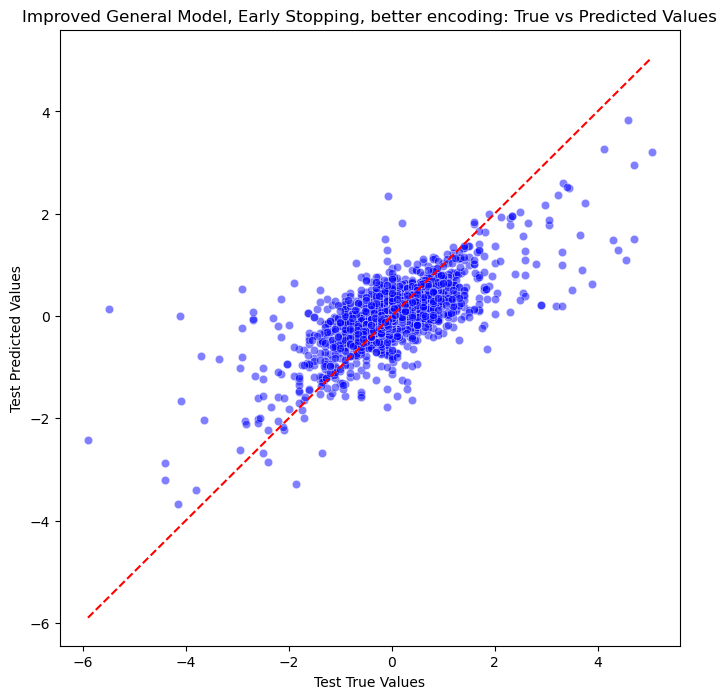

In [595]:
eval_model(model_XGB_V2_encoded, x_train_encoded, x_test_encoded, y_train, y_test, "Improved General Model, Early Stopping, better encoding")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

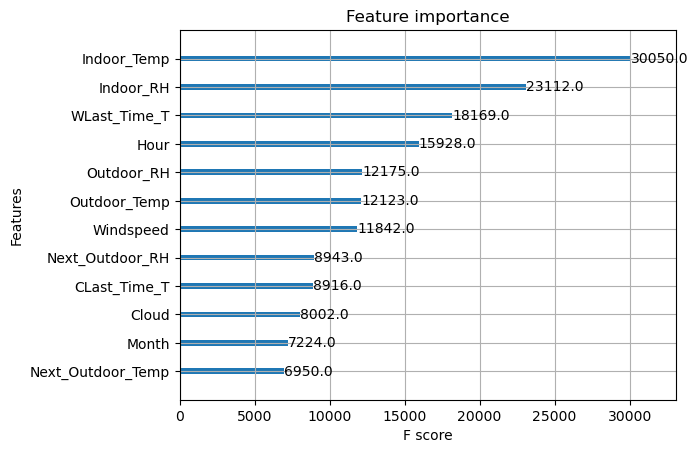

In [606]:
xgb.plot_importance(model_XGB_V2_encoded, max_num_features=12, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

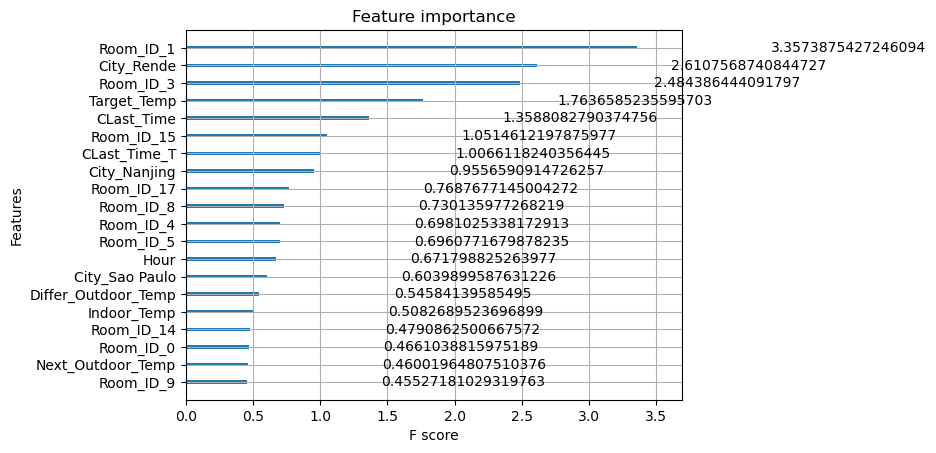

In [608]:
xgb.plot_importance(model_XGB_V2_encoded, max_num_features=20, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

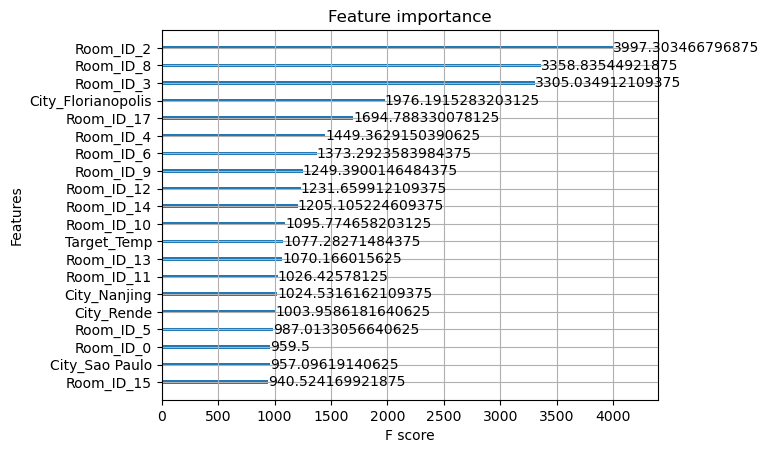

In [609]:
xgb.plot_importance(model_XGB_V2_encoded, max_num_features=20, importance_type='cover')

In [611]:
for city in range(4):
    city_df = filtered_data[filtered_data["City"] == city]
    print(city_reverse_encode_mapping[city])
    print(len(city_df))
    unique_rooms = city_df.Room_ID.unique()
    print(unique_rooms)

Florianopolis
1526
[0]
Nanjing
1800
[2 3]
Rende
8450
[1]
Sao Paulo
29612
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [613]:
def encode_city_drop_room(raw_data):
    data_onehot = pd.get_dummies(raw_data, columns=['City'], prefix=['City'], dtype=float)
    data_onehot.rename(columns={f'City_{k}': f'City_{v}' for k, v in city_reverse_encode_mapping.items()}, inplace=True)
    data_onehot = data_onehot.drop(columns=["Room_ID"])
    return data_onehot

In [614]:
x_train_encoded_no_room = encode_city_drop_room(x_train)
x_test_encoded_no_room = encode_city_drop_room(x_test)

Taking baseline paper model, and just improving it with some better feature engineering: Proper encoding of city, dropping of room

In [617]:
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train_encoded_no_room, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.15681732283310587), ('max_depth', 5), ('n_estimators', 500)])


In [618]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_encoded_no_room = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.1568, 
                            n_estimators=500)
model_XGB_encoded_no_room.fit(x_train_encoded_no_room, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1568, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Paper Model, clean data, stratified, city encoding, no room
TEST -  mse: 0.13298398591423224 | rmse: 0.3646696942634968 | mae: 0.19216055786120304 | r2: 0.46113317588699987
TRAIN -  mse: 0.05878067311491344 | rmse: 0.24244725841904965 | mae: 0.1387961808100892 | r2: 0.7610506476872592


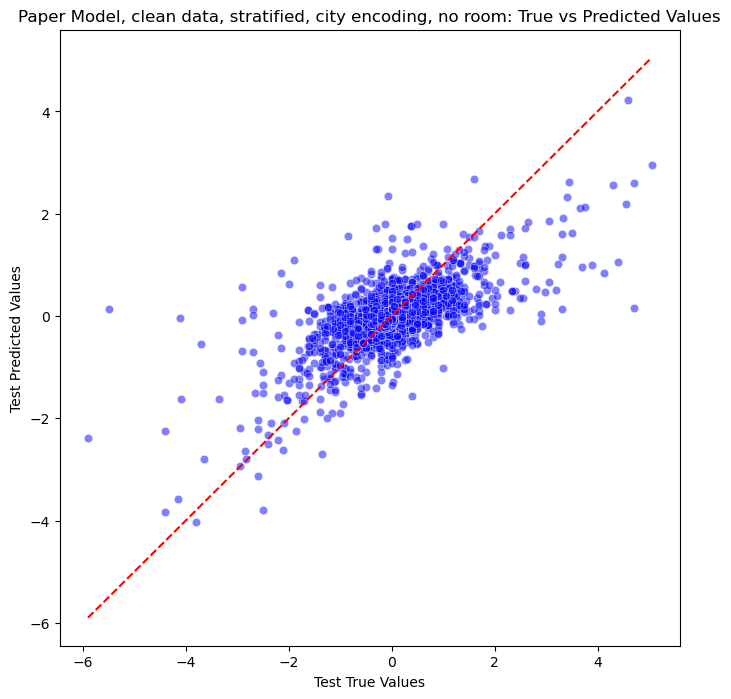

In [620]:
eval_model(model_XGB_encoded_no_room, x_train_encoded_no_room, x_test_encoded_no_room, y_train, y_test, "Paper Model, clean data, stratified, city encoding, no room")

In [621]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 11), 
                    'n_estimators': Integer(100, 1200), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train_encoded_no_room, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.020681155264692035), ('max_depth', 11), ('n_estimators', 1200), ('subsample', 0.5)])


In [623]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_V1_encoded_no_room = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=11, 
                            learning_rate=0.02068, 
                            n_estimators=1200,
                            subsample=0.5,
                            colsample_bytree=1.0
                            )
model_XGB_V1_encoded_no_room.fit(x_train_encoded_no_room,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02068, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
General Model V1: Encoded city, no room
TEST -  mse: 0.11532875059411281 | rmse: 0.3396008695426335 | mae: 0.16722808515093335 | r2: 0.5326742755202771
TRAIN -  mse: 0.006230239308003902 | rmse: 0.07893186497229052 | mae: 0.05092350406852342 | r2: 0.9746734501578342


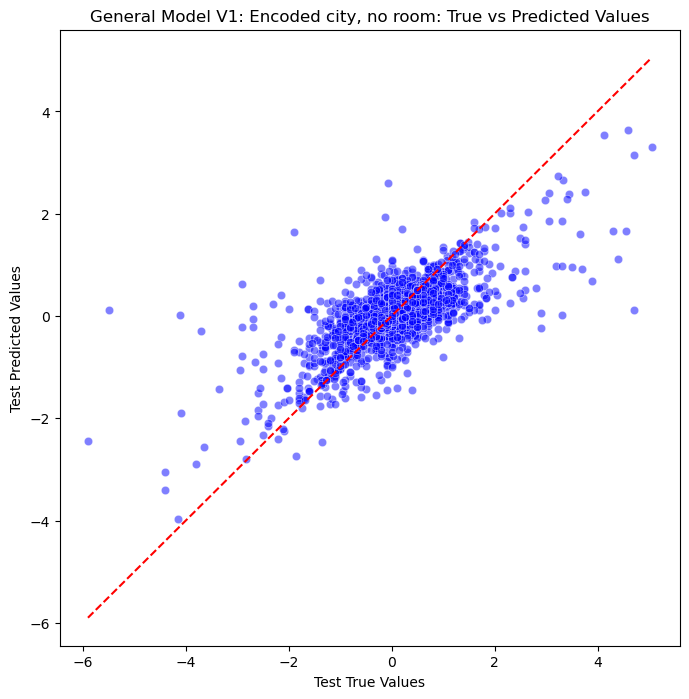

In [631]:
eval_model(model_XGB_V1_encoded_no_room, x_train_encoded_no_room, x_test_encoded_no_room, y_train, y_test, "General Model V1: Encoded city, no room")

### Conclusion: This model V1 is WORSE than the model with room, therefore the room does add information to the model and help it.

## 8. Fine tuning for each city

### 8.1: ARCHIVED: WITH adding city to the common model

Wasn't chosen due to inferior performance, and due to the fact it doesn't make sense

In [982]:
# 1. Prepare Data
def prepare_data_for_common_model(raw_data):
    raw_data = pd.get_dummies(raw_data, columns=['Room_ID', "City"], prefix=['Room_', 'City_'], dtype=float)
    raw_data = raw_data.rename(columns={f'City__{k}': f'City__{v}' for k, v in city_reverse_encode_mapping.items()})
    raw_data.loc[:, raw_data.filter(like='Room_').columns] = 0.0
    return raw_data

In [983]:
x_train_common_model = prepare_data_for_common_model(x_train)
x_test_common_model = prepare_data_for_common_model(x_test)

In [984]:
x_train_no_val_common_model = prepare_data_for_common_model(x_train_no_val)
x_val_common_model = prepare_data_for_common_model(x_val)

In [800]:
x_train_no_val_common_model.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'City__Florianopolis', 'City__Nanjing', 'City__Rende',
       'City__Sao Paulo', 'Room__0', 'Room__1', 'Room__2', 'Room__3',
       'Room__4', 'Room__5', 'Room__6', 'Room__7', 'Room__8', 'Room__9',
       'Room__10', 'Room__11', 'Room__12', 'Room__13', 'Room__14', 'Room__15',
       'Room__16', 'Room__17'],
      dtype='object')

In [770]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022, n_estimators=200, colsample_bytree=1.0), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform')}, 
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train_common_model, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.08194391684699597), ('max_depth', 10), ('subsample', 0.7048864072801321)])


In [1244]:
len(x_train_no_val_common_model.columns)

37

In [1249]:
x_train_no_val_common_model.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'Room__0', 'Room__1', 'Room__2', 'Room__3', 'Room__4',
       'Room__5', 'Room__6', 'Room__7', 'Room__8', 'Room__9', 'Room__10',
       'Room__11', 'Room__12', 'Room__13', 'Room__14', 'Room__15', 'Room__16',
       'Room__17'],
      dtype='object')

In [1324]:

model_XGB_common = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0819, 
                            n_estimators=200,
                            subsample=0.70,
                            early_stopping_rounds=10)
model_XGB_common.fit(x_train_no_val_common_model, y_train_no_val, eval_set=[(x_val_common_model, y_val)])

[0]	validation_0-rmse:0.64506


[1]	validation_0-rmse:0.61205
[2]	validation_0-rmse:0.58236
[3]	validation_0-rmse:0.55562
[4]	validation_0-rmse:0.53202
[5]	validation_0-rmse:0.51133
[6]	validation_0-rmse:0.49349
[7]	validation_0-rmse:0.47636
[8]	validation_0-rmse:0.46261
[9]	validation_0-rmse:0.45023
[10]	validation_0-rmse:0.43858
[11]	validation_0-rmse:0.42879
[12]	validation_0-rmse:0.41991
[13]	validation_0-rmse:0.41227
[14]	validation_0-rmse:0.40565
[15]	validation_0-rmse:0.39978
[16]	validation_0-rmse:0.39542
[17]	validation_0-rmse:0.39115
[18]	validation_0-rmse:0.38728
[19]	validation_0-rmse:0.38415
[20]	validation_0-rmse:0.38113
[21]	validation_0-rmse:0.37811
[22]	validation_0-rmse:0.37596
[23]	validation_0-rmse:0.37370
[24]	validation_0-rmse:0.37165
[25]	validation_0-rmse:0.36995
[26]	validation_0-rmse:0.36794
[27]	validation_0-rmse:0.36623
[28]	validation_0-rmse:0.36468
[29]	validation_0-rmse:0.36337
[30]	validation_0-rmse:0.36196
[31]	validation_0-rmse:0.36146
[32]	validation_0-rmse:0.36073
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0819, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Common Model
TEST -  mse: 0.1337 | rmse: 0.3656 | mae: 0.1854 | r2: 0.4583
TRAIN -  mse: 0.0507 | rmse: 0.2251 | mae: 0.1228 | r2: 0.7939


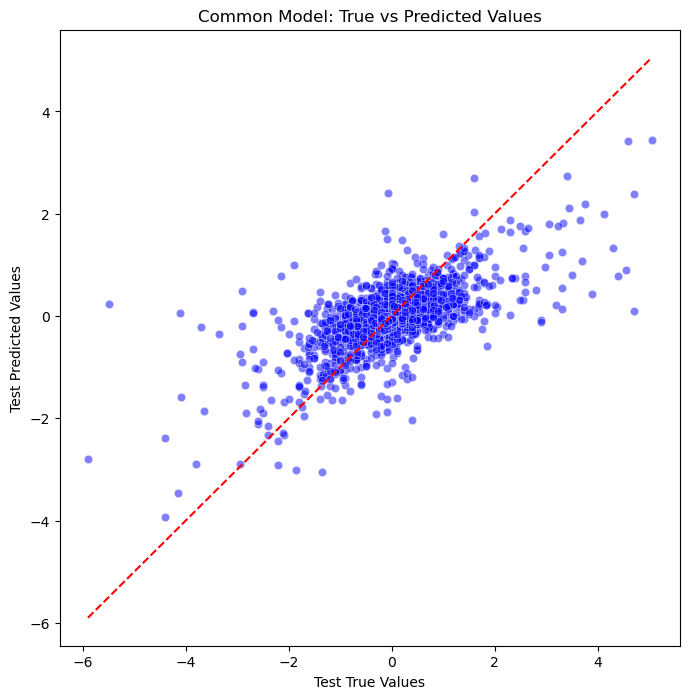

In [1306]:
eval_model(model_XGB_common, x_train_common_model, x_test_common_model, y_train, y_test, "Common Model")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

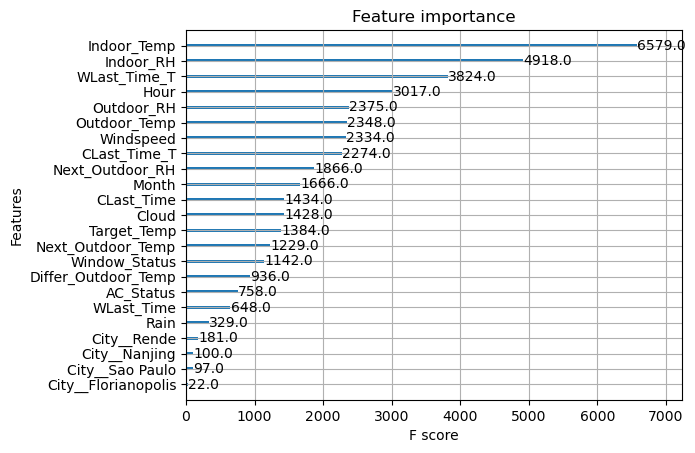

In [912]:
xgb.plot_importance(model_XGB_common)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

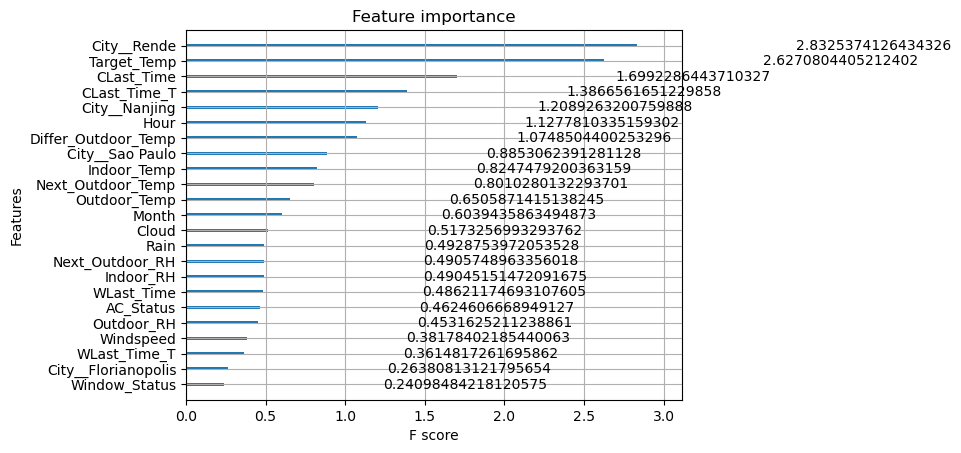

In [913]:
xgb.plot_importance(model_XGB_common, importance_type='gain')

#### Florianopolis

In [789]:
def prepare_data_for_finetune(city_data):
    city_data = pd.get_dummies(city_data, columns=["City", 'Room_ID'], prefix=['City_', 'Room_'], dtype=float)
    city_data = city_data.rename(columns={f'City__{k}': f'City__{v}' for k, v in city_reverse_encode_mapping.items()})    
    required_room_columns = [f"Room__{i}" for i in range(18)]
    required_city_columns = [f"City__{v}" for v in city_encode_mapping.keys()]
    for col in required_room_columns + required_city_columns:
        if col not in city_data.columns:
            city_data[col] = 0.0 
    return city_data

In [790]:
flori_x_train_finetune = prepare_data_for_finetune(flori_x_train)
flori_x_test_finetune = prepare_data_for_finetune(flori_x_test)


In [801]:
flori_x_test_finetune.columns

flori_x_train_finetune = flori_x_train_finetune[x_train_common_model.columns]
flori_x_test_finetune = flori_x_test_finetune[x_test_common_model.columns]


In [783]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(flori_x_train_finetune, flori_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.2), ('max_depth', 3), ('n_estimators', 50), ('subsample', 1.0)])


In [788]:
flori_x_train_no_val.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Room_ID', 'City', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Target_Temp'],
      dtype='object')

In [803]:
flori_x_train_no_val_finetune = prepare_data_for_finetune(flori_x_train_no_val)
flori_x_val_finetune = prepare_data_for_finetune(flori_x_val)

flori_x_train_no_val_finetune=flori_x_train_no_val_finetune[x_train_common_model.columns]
flori_x_val_finetune=flori_x_val_finetune[x_train_common_model.columns]

In [1287]:
# # Step 2: Fine-tune for a specific city with a smaller learning rate
# flori_finetune_model = xgb.XGBRegressor(
#     max_depth=3,
#     n_estimators=50,
#     colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
#     learning_rate=0.001,
#     subsample=1.0, #,
#     early_stopping_rounds=15)  # Reduced learning rate


# flori_finetune_model.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set= [(flori_x_val_finetune, flori_y_val)], xgb_model=model_XGB_common)  # Continue training

# Step 2: Fine-tune for a specific city with a smaller learning rate
# flori_finetune_model_no_early_stopping = xgb.XGBRegressor(
#     max_depth=3,
#     n_estimators=50,
#     colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
#     learning_rate=0.001,
#     subsample=1.0,
#     early_stopping_rounds=15)  # Reduced learning rate


# flori_finetune_model_no_early_stopping.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set=[(flori_x_val_finetune, flori_y_val)], xgb_model=model_XGB_common)  # Continue training

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Florianopolis Finetuned Model
TEST -  mse: 0.1908 | rmse: 0.4368 | mae: 0.2167 | r2: -0.1935
TRAIN -  mse: 0.0470 | rmse: 0.2169 | mae: 0.1066 | r2: 0.7832


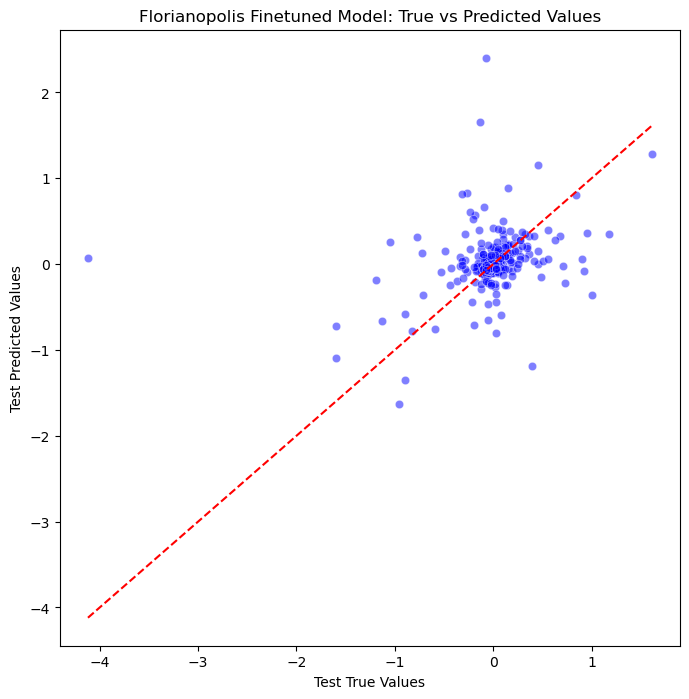

In [1288]:
eval_model(flori_finetune_model_no_early_stopping, flori_x_train_finetune, flori_x_test_finetune, flori_y_train, flori_y_test, "Florianopolis Finetuned Model")

Evaluating Model
Florianopolis Finetuned Model
TEST -  mse: 0.1908 | rmse: 0.4368 | mae: 0.2167 | r2: -0.1935
TRAIN -  mse: 0.0470 | rmse: 0.2169 | mae: 0.1066 | r2: 0.7832


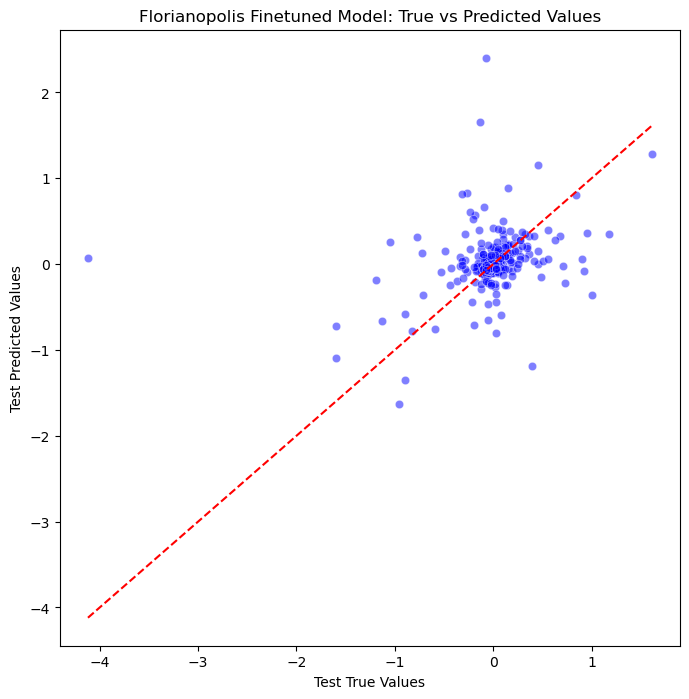

In [1290]:
eval_model(model_XGB_common, flori_x_train_finetune, flori_x_test_finetune, flori_y_train, flori_y_test, "Florianopolis Finetuned Model")

Evaluating Model
Florianopolis Finetuned Model
TEST -  mse: 0.1908 | rmse: 0.4368 | mae: 0.2167 | r2: -0.1935
TRAIN -  mse: 0.0470 | rmse: 0.2169 | mae: 0.1066 | r2: 0.7832


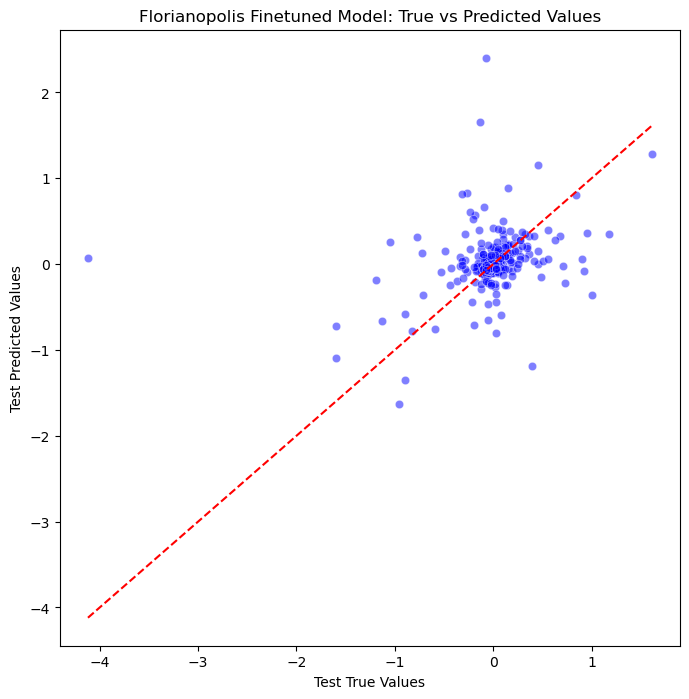

In [1289]:
eval_model(model_XGB_common, flori_x_train_finetune, flori_x_test_finetune, flori_y_train, flori_y_test, "Florianopolis Finetuned Model")

#### Nanging

In [825]:
nanging_x_train_finetune = prepare_data_for_finetune(nanging_x_train)
nanging_x_test_finetune = prepare_data_for_finetune(nanging_x_test)
nanging_x_train_no_val_finetune = prepare_data_for_finetune(nanging_x_train_no_val)
nanging_x_val_finetune = prepare_data_for_finetune(nanging_x_val)

nanging_x_train_finetune = nanging_x_train_finetune[x_train_common_model.columns]
nanging_x_test_finetune = nanging_x_test_finetune[x_train_common_model.columns]
nanging_x_train_no_val_finetune=nanging_x_train_no_val_finetune[x_train_common_model.columns]
nanging_x_val_finetune=nanging_x_val_finetune[x_train_common_model.columns]

In [862]:
nanging_x_test_finetune.Room__2.sum()

125.0

In [828]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(nanging_x_train_finetune, nanging_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01684348568447314), ('max_depth', 10), ('n_estimators', 283), ('subsample', 0.5)])


In [922]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
nanging_finetune_model = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=200,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.001,
    subsample=0.5, #,
    early_stopping_rounds=10)  # Reduced learning rate


nanging_finetune_model.fit(nanging_x_train_no_val_finetune, nanging_y_train_no_val, eval_set= [(nanging_x_val_finetune, nanging_y_val)], xgb_model=model_XGB_common)

[0]	validation_0-rmse:0.18024
[1]	validation_0-rmse:0.18025


[2]	validation_0-rmse:0.18024
[3]	validation_0-rmse:0.18023
[4]	validation_0-rmse:0.18022
[5]	validation_0-rmse:0.18023
[6]	validation_0-rmse:0.18023
[7]	validation_0-rmse:0.18023
[8]	validation_0-rmse:0.18023
[9]	validation_0-rmse:0.18024
[10]	validation_0-rmse:0.18024
[11]	validation_0-rmse:0.18024
[12]	validation_0-rmse:0.18024
[13]	validation_0-rmse:0.18025


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common model, Nanging Data
TEST -  mse: 0.1923 | rmse: 0.4386 | mae: 0.2687 | r2: 0.4701
TRAIN -  mse: 0.0535 | rmse: 0.2313 | mae: 0.1364 | r2: 0.8510


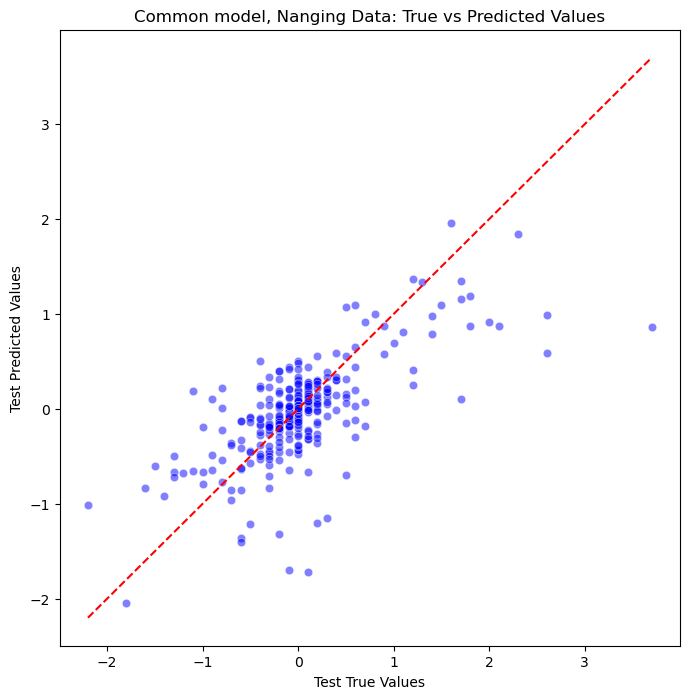

In [923]:
eval_model(model_XGB_common, nanging_x_train_finetune, nanging_x_test_finetune, nanging_y_train, nanging_y_test, "Common model, Nanging Data")

Evaluating Model
Nanging Finetuned Model
TEST -  mse: 0.1936 | rmse: 0.4400 | mae: 0.2690 | r2: 0.4666
TRAIN -  mse: 0.0508 | rmse: 0.2254 | mae: 0.1314 | r2: 0.8585


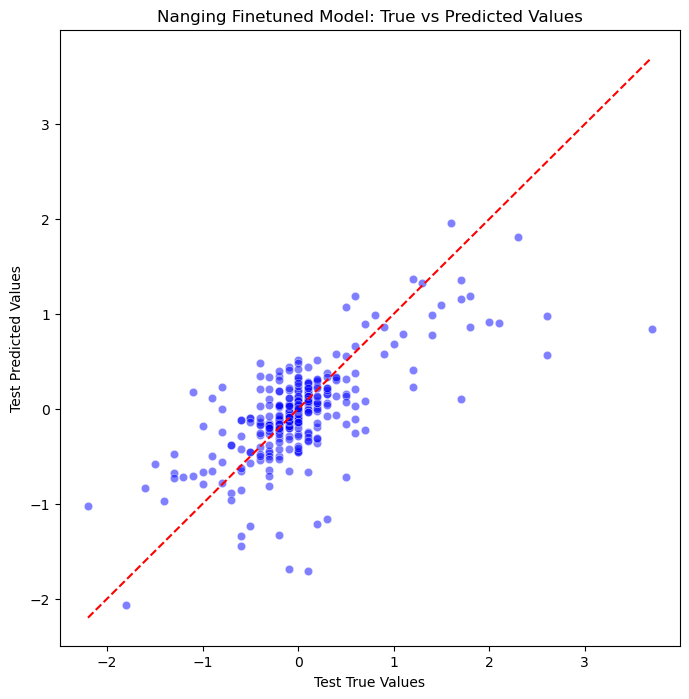

In [924]:
eval_model(nanging_finetune_model, nanging_x_train_finetune, nanging_x_test_finetune, nanging_y_train, nanging_y_test, "Nanging Finetuned Model")

#### Rende

In [863]:
rende_x_train_finetune = prepare_data_for_finetune(rende_x_train)
rende_x_test_finetune = prepare_data_for_finetune(rende_x_test)
rende_x_train_no_val_finetune = prepare_data_for_finetune(rende_x_train_no_val)
rende_x_val_finetune = prepare_data_for_finetune(rende_x_val)

rende_x_train_finetune = rende_x_train_finetune[x_train_common_model.columns]
rende_x_test_finetune = rende_x_test_finetune[x_train_common_model.columns]
rende_x_train_no_val_finetune=rende_x_train_no_val_finetune[x_train_common_model.columns]
rende_x_val_finetune=rende_x_val_finetune[x_train_common_model.columns]

In [866]:
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(100, 800), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(rende_x_train_finetune, rende_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.017829882315170055), ('max_depth', 7), ('n_estimators', 800), ('subsample', 0.5)])


In [925]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
rende_finetune_model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=100,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.002,
    subsample=0.5, #,
    early_stopping_rounds=15)  # Reduced learning rate


rende_finetune_model.fit(rende_x_train_no_val_finetune, rende_y_train_no_val, eval_set= [(rende_x_val_finetune, rende_y_val)], xgb_model=model_XGB_common)

[0]	validation_0-rmse:0.19155
[1]	validation_0-rmse:0.19155
[2]	validation_0-rmse:0.19155
[3]	validation_0-rmse:0.19155
[4]	validation_0-rmse:0.19155
[5]	validation_0-rmse:0.19157
[6]	validation_0-rmse:0.19157
[7]	validation_0-rmse:0.19156


[8]	validation_0-rmse:0.19156
[9]	validation_0-rmse:0.19157
[10]	validation_0-rmse:0.19157
[11]	validation_0-rmse:0.19156
[12]	validation_0-rmse:0.19156
[13]	validation_0-rmse:0.19156
[14]	validation_0-rmse:0.19156
[15]	validation_0-rmse:0.19156
[16]	validation_0-rmse:0.19157


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=15,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.002, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common model, Rende Data
TEST -  mse: 0.1644 | rmse: 0.4055 | mae: 0.2024 | r2: 0.5595
TRAIN -  mse: 0.0504 | rmse: 0.2244 | mae: 0.1240 | r2: 0.8658


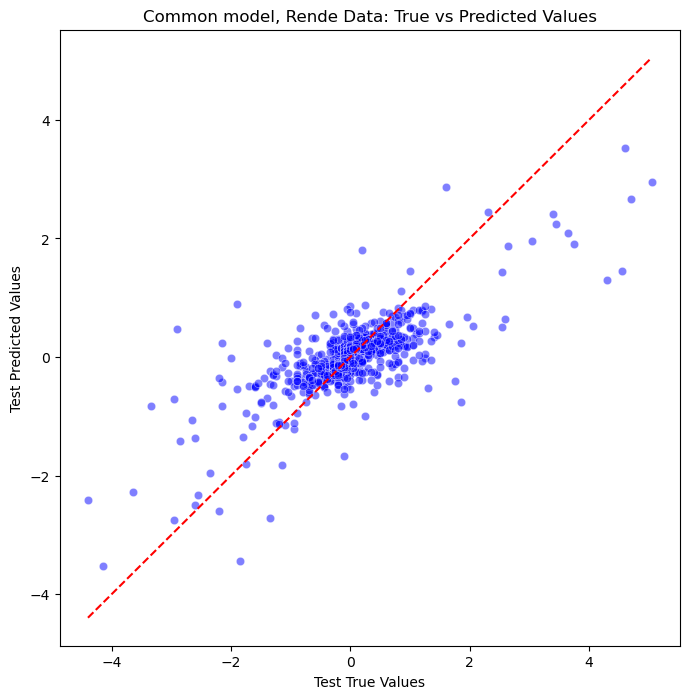

In [926]:
eval_model(model_XGB_common, rende_x_train_finetune, rende_x_test_finetune, rende_y_train, rende_y_test, "Common model, Rende Data")

Evaluating Model
Rende Finetune Model
TEST -  mse: 0.1641 | rmse: 0.4051 | mae: 0.2025 | r2: 0.5602
TRAIN -  mse: 0.0484 | rmse: 0.2201 | mae: 0.1211 | r2: 0.8710


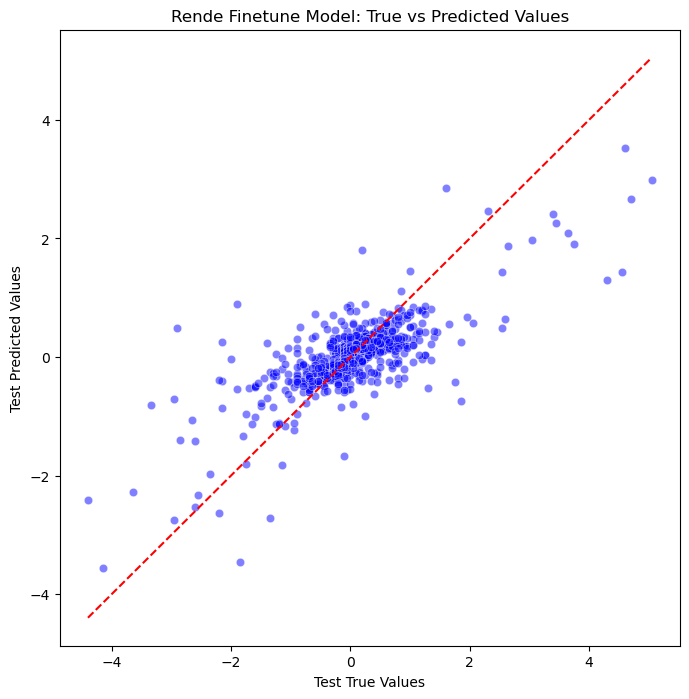

In [927]:
eval_model(rende_finetune_model, rende_x_train_finetune, rende_x_test_finetune, rende_y_train, rende_y_test, "Rende Finetune Model")

#### Sao Paulo

In [986]:
sp_x_train_finetune = prepare_data_for_finetune(sp_x_train)
sp_x_test_finetune = prepare_data_for_finetune(sp_x_test)
sp_x_train_no_val_finetune = prepare_data_for_finetune(sp_x_train_no_val)
sp_x_val_finetune = prepare_data_for_finetune(sp_x_val)

sp_x_train_finetune = sp_x_train_finetune[x_train_common_model.columns]
sp_x_test_finetune = sp_x_test_finetune[x_train_common_model.columns]
sp_x_train_no_val_finetune=sp_x_train_no_val_finetune[x_train_common_model.columns]
sp_x_val_finetune=sp_x_val_finetune[x_train_common_model.columns]

In [929]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(4, 10), 
                    'n_estimators': Integer(300, 1000), 
                    'learning_rate': (0.01, 0.3, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=4)
opt.fit(sp_x_train_finetune, sp_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.035979487733971804), ('max_depth', 10), ('n_estimators', 1000), ('subsample', 0.7347717523198574)])


In [987]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
sp_finetune_model = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=800,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.036,
    subsample=0.735, #,
    early_stopping_rounds=10)  # Reduced learning rate


sp_finetune_model.fit(sp_x_train_no_val_finetune, sp_y_train_no_val, eval_set= [(sp_x_val_finetune, sp_y_val)], xgb_model=model_XGB_common)

[0]	validation_0-rmse:0.18948


[1]	validation_0-rmse:0.18930
[2]	validation_0-rmse:0.18885
[3]	validation_0-rmse:0.18839
[4]	validation_0-rmse:0.18816
[5]	validation_0-rmse:0.18781
[6]	validation_0-rmse:0.18778
[7]	validation_0-rmse:0.18769
[8]	validation_0-rmse:0.18768
[9]	validation_0-rmse:0.18745
[10]	validation_0-rmse:0.18713
[11]	validation_0-rmse:0.18698
[12]	validation_0-rmse:0.18690
[13]	validation_0-rmse:0.18689
[14]	validation_0-rmse:0.18694
[15]	validation_0-rmse:0.18699
[16]	validation_0-rmse:0.18696
[17]	validation_0-rmse:0.18689
[18]	validation_0-rmse:0.18679
[19]	validation_0-rmse:0.18668
[20]	validation_0-rmse:0.18673
[21]	validation_0-rmse:0.18667
[22]	validation_0-rmse:0.18670
[23]	validation_0-rmse:0.18662
[24]	validation_0-rmse:0.18664
[25]	validation_0-rmse:0.18663
[26]	validation_0-rmse:0.18661
[27]	validation_0-rmse:0.18656
[28]	validation_0-rmse:0.18655
[29]	validation_0-rmse:0.18640
[30]	validation_0-rmse:0.18630
[31]	validation_0-rmse:0.18630
[32]	validation_0-rmse:0.18629
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.036, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common Model, Sao Paulo Data
TEST -  mse: 0.1160 | rmse: 0.3406 | mae: 0.1733 | r2: 0.4425
TRAIN -  mse: 0.0521 | rmse: 0.2282 | mae: 0.1241 | r2: 0.7443


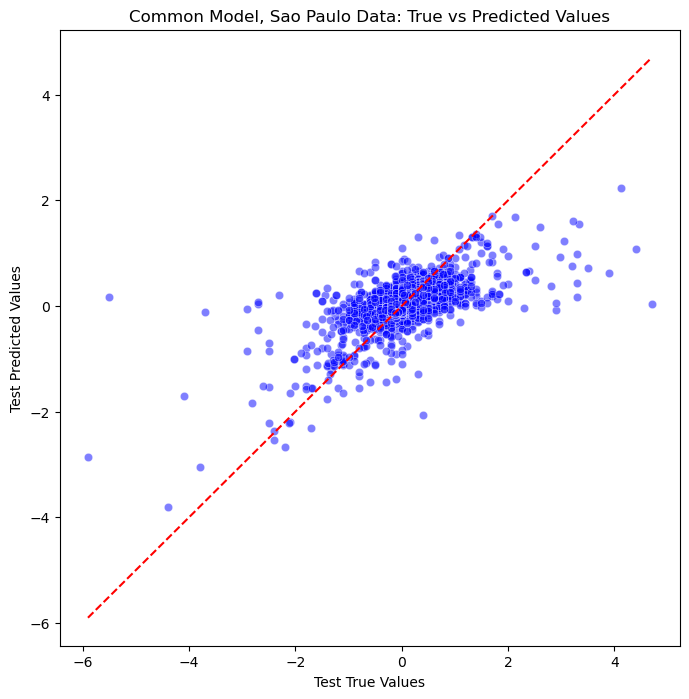

In [989]:
eval_model(model_XGB_common, sp_x_train_finetune, sp_x_test_finetune, sp_y_train, sp_y_test, "Common Model, Sao Paulo Data")

Evaluating Model
Sao Paulo Finetune Model
TEST -  mse: 0.1099 | rmse: 0.3315 | mae: 0.1692 | r2: 0.4719
TRAIN -  mse: 0.0407 | rmse: 0.2016 | mae: 0.1137 | r2: 0.8004


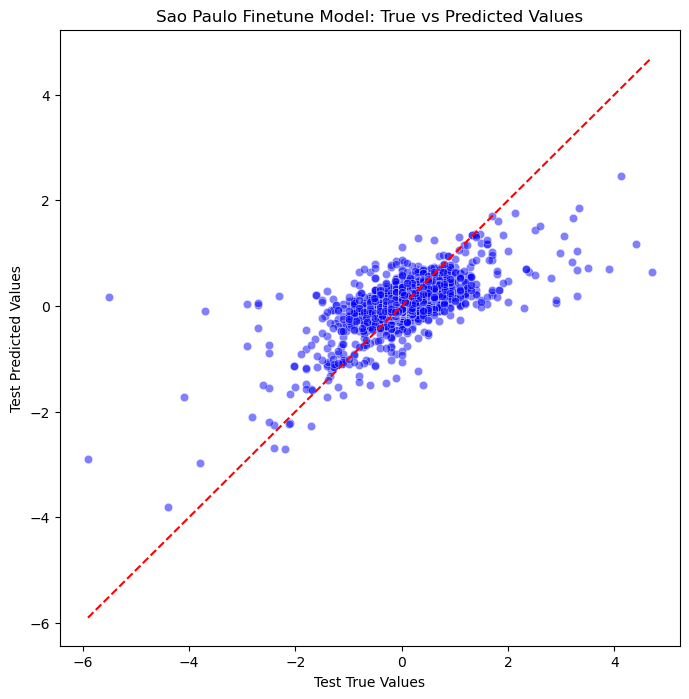

In [990]:
eval_model(sp_finetune_model, sp_x_train_finetune, sp_x_test_finetune, sp_y_train, sp_y_test, "Sao Paulo Finetune Model")

### WITHOUT adding city to the common model

In [1129]:
# 1. Prepare Data
def prepare_data_for_common_model_no_city(raw_data):
    raw_data = pd.get_dummies(raw_data, columns=['Room_ID'], prefix=['Room_'], dtype=float)
    raw_data.loc[:, raw_data.filter(like='Room_').columns] = 0.0
    raw_data = raw_data.drop(columns=["City"])
    return raw_data

In [1130]:
x_train_common_model = prepare_data_for_common_model_no_city(x_train)
x_test_common_model = prepare_data_for_common_model_no_city(x_test)

In [1131]:
x_train_no_val_common_model = prepare_data_for_common_model_no_city(x_train_no_val)
x_val_common_model = prepare_data_for_common_model_no_city(x_val)

In [936]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022, n_estimators=200, colsample_bytree=1.0), 
                    { 
                    'max_depth': Integer(4, 10), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform')}, 
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train_common_model, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.07267464490287114), ('max_depth', 10), ('subsample', 0.7178211646850745)])


In [1409]:

model_XGB_common = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0726, 
                            n_estimators=100,
                            subsample=0.71,
                            early_stopping_rounds=10)
model_XGB_common.fit(x_train_no_val_common_model, y_train_no_val, eval_set=[(x_val_common_model, y_val)])

[0]	validation_0-rmse:0.64947
[1]	validation_0-rmse:0.61966
[2]	validation_0-rmse:0.59329
[3]	validation_0-rmse:0.56886
[4]	validation_0-rmse:0.54639
[5]	validation_0-rmse:0.52595
[6]	validation_0-rmse:0.50850
[7]	validation_0-rmse:0.49241
[8]	validation_0-rmse:0.47801
[9]	validation_0-rmse:0.46519
[10]	validation_0-rmse:0.45348
[11]	validation_0-rmse:0.44330
[12]	validation_0-rmse:0.43378
[13]	validation_0-rmse:0.42580
[14]	validation_0-rmse:0.41835
[15]	validation_0-rmse:0.41223
[16]	validation_0-rmse:0.40670
[17]	validation_0-rmse:0.40164
[18]	validation_0-rmse:0.39724
[19]	validation_0-rmse:0.39306
[20]	validation_0-rmse:0.38889
[21]	validation_0-rmse:0.38559
[22]	validation_0-rmse:0.38281
[23]	validation_0-rmse:0.38009
[24]	validation_0-rmse:0.37803
[25]	validation_0-rmse:0.37628
[26]	validation_0-rmse:0.37434
[27]	validation_0-rmse:0.37225
[28]	validation_0-rmse:0.37052
[29]	validation_0-rmse:0.36915
[30]	validation_0-rmse:0.36740
[31]	validation_0-rmse:0.36618
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0726, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

In [943]:
x_train_common_model.Room__17.sum()

0.0

Evaluating Model
Common Model
TEST -  mse: 0.13311 | rmse: 0.36485 | mae: 0.18670 | r2: 0.46060
TRAIN -  mse: 0.0581 | rmse: 0.2411 | mae: 0.1323 | r2: 0.7636


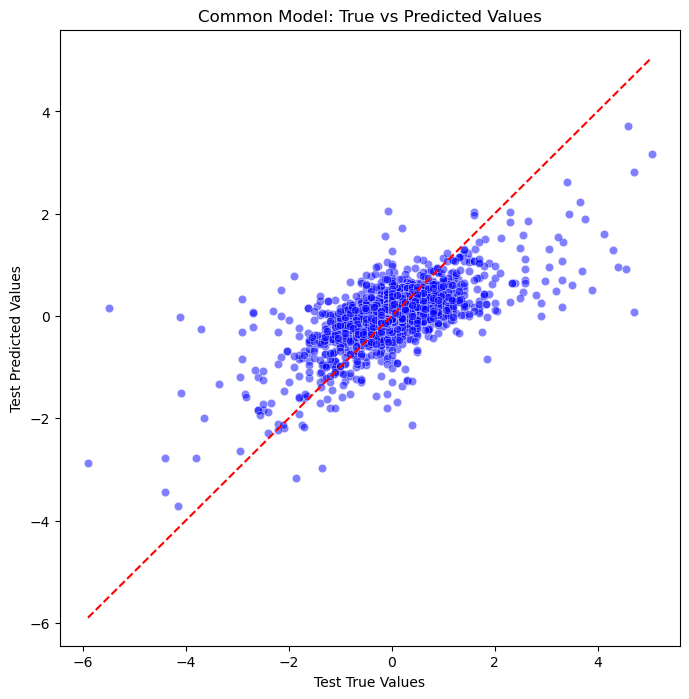

In [1410]:
eval_model(model_XGB_common, x_train_common_model, x_test_common_model, y_train, y_test, "Common Model")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

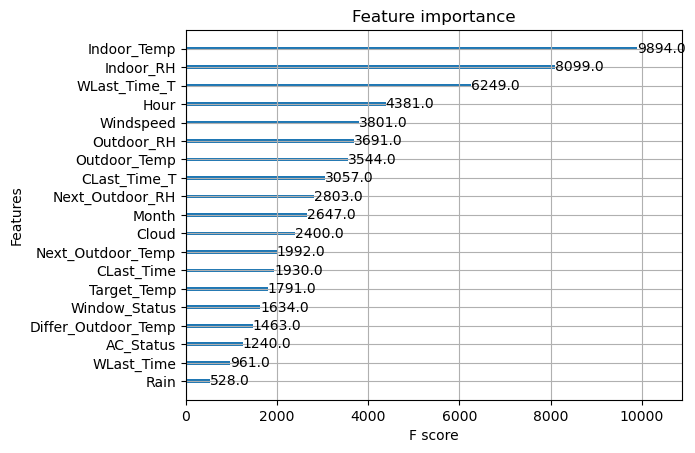

In [944]:
xgb.plot_importance(model_XGB_common)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

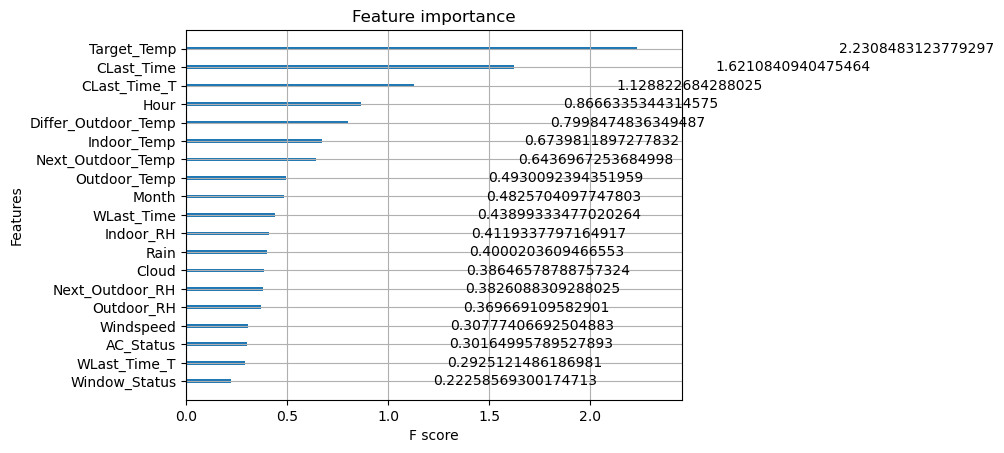

In [945]:
xgb.plot_importance(model_XGB_common, importance_type='gain')

#### Florianopolis

In [35]:
def prepare_data_for_finetune_no_city(city_data):
    city_data = pd.get_dummies(city_data, columns=['Room_ID'], prefix=['Room_'], dtype=float)
    city_data = city_data.drop(columns=['City'])
    required_room_columns = [f"Room__{i}" for i in range(18)]
    for col in required_room_columns:
        if col not in city_data.columns:
            city_data[col] = 0.0 
    return city_data

In [1296]:
flori_x_train_finetune = prepare_data_for_finetune_no_city(flori_x_train)
flori_x_test_finetune = prepare_data_for_finetune_no_city(flori_x_test)


In [1297]:
x_train_common_model.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'Room__0', 'Room__1', 'Room__2', 'Room__3', 'Room__4',
       'Room__5', 'Room__6', 'Room__7', 'Room__8', 'Room__9', 'Room__10',
       'Room__11', 'Room__12', 'Room__13', 'Room__14', 'Room__15', 'Room__16',
       'Room__17'],
      dtype='object')

In [1298]:

flori_x_train_finetune = flori_x_train_finetune[x_train_common_model.columns]
flori_x_test_finetune = flori_x_test_finetune[x_test_common_model.columns]


In [ ]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(flori_x_train_finetune, flori_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.2), ('max_depth', 3), ('n_estimators', 50), ('subsample', 1.0)])


In [1142]:
flori_x_train_no_val_finetune.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'Room__0', 'Room__1', 'Room__2', 'Room__3', 'Room__4',
       'Room__5', 'Room__6', 'Room__7', 'Room__8', 'Room__9', 'Room__10',
       'Room__11', 'Room__12', 'Room__13', 'Room__14', 'Room__15', 'Room__16',
       'Room__17'],
      dtype='object')

In [1299]:
flori_x_train_no_val_finetune = prepare_data_for_finetune_no_city(flori_x_train_no_val)
flori_x_val_finetune = prepare_data_for_finetune_no_city(flori_x_val)

flori_x_train_no_val_finetune=flori_x_train_no_val_finetune[x_train_common_model.columns]
flori_x_val_finetune=flori_x_val_finetune[x_train_common_model.columns]

In [1470]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
flori_finetune_model_no_early_stopping = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=30,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.02,
    subsample=1.0,
    early_stopping_rounds=30)  # Reduced learning rate


flori_finetune_model_no_early_stopping.fit(X=flori_x_train_no_val_finetune, y=flori_y_train_no_val, eval_set=[(flori_x_val_finetune, flori_y_val)], xgb_model=model_XGB_common)  # Continue training

[0]	validation_0-rmse:0.14806
[1]	validation_0-rmse:0.14802
[2]	validation_0-rmse:0.14801
[3]	validation_0-rmse:0.14797
[4]	validation_0-rmse:0.14797
[5]	validation_0-rmse:0.14799
[6]	validation_0-rmse:0.14800
[7]	validation_0-rmse:0.14799
[8]	validation_0-rmse:0.14801
[9]	validation_0-rmse:0.14801


[10]	validation_0-rmse:0.14800
[11]	validation_0-rmse:0.14800
[12]	validation_0-rmse:0.14804
[13]	validation_0-rmse:0.14804
[14]	validation_0-rmse:0.14804
[15]	validation_0-rmse:0.14797
[16]	validation_0-rmse:0.14802
[17]	validation_0-rmse:0.14803
[18]	validation_0-rmse:0.14808
[19]	validation_0-rmse:0.14802
[20]	validation_0-rmse:0.14802
[21]	validation_0-rmse:0.14803
[22]	validation_0-rmse:0.14807
[23]	validation_0-rmse:0.14802
[24]	validation_0-rmse:0.14811
[25]	validation_0-rmse:0.14811
[26]	validation_0-rmse:0.14812
[27]	validation_0-rmse:0.14818
[28]	validation_0-rmse:0.14814
[29]	validation_0-rmse:0.14816


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Florianopolis Finetuned Model
TEST -  mse: 0.17361 | rmse: 0.41666 | mae: 0.20861 | r2: -0.08612
TRAIN -  mse: 0.0534 | rmse: 0.2310 | mae: 0.1165 | r2: 0.7541


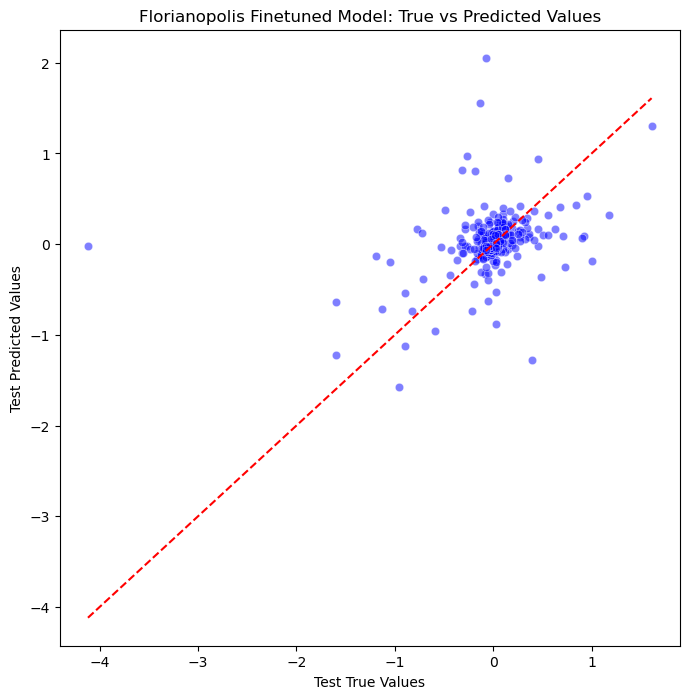

In [1471]:
eval_model(flori_finetune_model_no_early_stopping, flori_x_train_finetune, flori_x_test_finetune, flori_y_train, flori_y_test, "Florianopolis Finetuned Model")

Evaluating Model
Common Model, Florianopolis Data
TEST -  mse: 0.19076 | rmse: 0.43677 | mae: 0.21669 | r2: -0.19347
TRAIN -  mse: 0.0470 | rmse: 0.2169 | mae: 0.1066 | r2: 0.7832


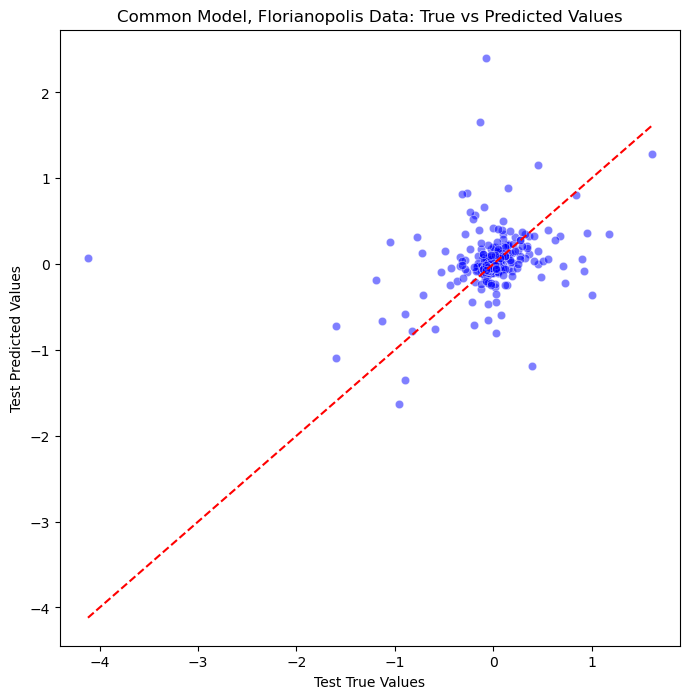

In [1362]:
eval_model(model_XGB_common, flori_x_train_finetune, flori_x_test_finetune, flori_y_train, flori_y_test, "Common Model, Florianopolis Data")

#### Nanging

In [1363]:
nanging_x_train_finetune = prepare_data_for_finetune_no_city(nanging_x_train)
nanging_x_test_finetune = prepare_data_for_finetune_no_city(nanging_x_test)
nanging_x_train_no_val_finetune = prepare_data_for_finetune_no_city(nanging_x_train_no_val)
nanging_x_val_finetune = prepare_data_for_finetune_no_city(nanging_x_val)

nanging_x_train_finetune = nanging_x_train_finetune[x_train_common_model.columns]
nanging_x_test_finetune = nanging_x_test_finetune[x_train_common_model.columns]
nanging_x_train_no_val_finetune=nanging_x_train_no_val_finetune[x_train_common_model.columns]
nanging_x_val_finetune=nanging_x_val_finetune[x_train_common_model.columns]

In [ ]:
# # 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
# np.int = int
# opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
#                               n_jobs=-1,
#                                 random_state=2022), 
#                     { 
#                     'max_depth': Integer(3, 10), 
#                     'n_estimators': Integer(50, 500), 
#                     'learning_rate': (0.005, 0.2, 'log-uniform'),
#                     'subsample': (0.5, 1.0, 'uniform'), 
#                     'colsample_bytree': (0.5, 1.0, 'uniform')},  
#                     random_state=2022,
#                     scoring='r2',
#                     n_iter=40,
#                     cv=8)
# opt.fit(nanging_x_train_finetune, nanging_y_train)
# print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01684348568447314), ('max_depth', 10), ('n_estimators', 283), ('subsample', 0.5)])


200

In [1468]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
nanging_finetune_model_no_early_stopping = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=100,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0168,
    subsample=0.5, #,
    early_stopping_rounds=100)  # Reduced learning rate


nanging_finetune_model_no_early_stopping.fit(nanging_x_train_no_val_finetune, nanging_y_train_no_val, eval_set=[(nanging_x_val_finetune, nanging_y_val)], xgb_model=model_XGB_common)

[0]	validation_0-rmse:0.22229
[1]	validation_0-rmse:0.22230
[2]	validation_0-rmse:0.22228
[3]	validation_0-rmse:0.22203
[4]	validation_0-rmse:0.22195
[5]	validation_0-rmse:0.22180
[6]	validation_0-rmse:0.22183
[7]	validation_0-rmse:0.22132
[8]	validation_0-rmse:0.22101
[9]	validation_0-rmse:0.22118
[10]	validation_0-rmse:0.22157
[11]	validation_0-rmse:0.22152
[12]	validation_0-rmse:0.22122
[13]	validation_0-rmse:0.22117
[14]	validation_0-rmse:0.22110
[15]	validation_0-rmse:0.22118
[16]	validation_0-rmse:0.22136
[17]	validation_0-rmse:0.22138
[18]	validation_0-rmse:0.22100
[19]	validation_0-rmse:0.22069
[20]	validation_0-rmse:0.22058
[21]	validation_0-rmse:0.22064
[22]	validation_0-rmse:0.22024
[23]	validation_0-rmse:0.22019
[24]	validation_0-rmse:0.22012
[25]	validation_0-rmse:0.21998
[26]	validation_0-rmse:0.21954
[27]	validation_0-rmse:0.21928
[28]	validation_0-rmse:0.21919
[29]	validation_0-rmse:0.21931
[30]	validation_0-rmse:0.21891
[31]	validation_0-rmse:0.21912
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0168, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common model, Nanging Data
TEST -  mse: 0.20156 | rmse: 0.44896 | mae: 0.27622 | r2: 0.44464
TRAIN -  mse: 0.0660 | rmse: 0.2569 | mae: 0.1543 | r2: 0.8162


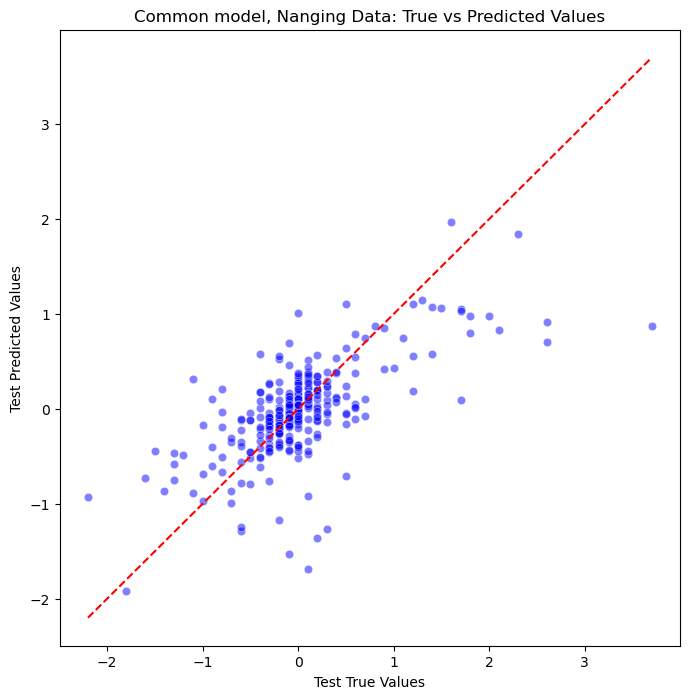

In [1457]:
eval_model(model_XGB_common, nanging_x_train_finetune, nanging_x_test_finetune, nanging_y_train, nanging_y_test, "Common model, Nanging Data")

Evaluating Model
Nanging Finetuned Model
TEST -  mse: 0.18346 | rmse: 0.42833 | mae: 0.26678 | r2: 0.49451
TRAIN -  mse: 0.0386 | rmse: 0.1966 | mae: 0.1215 | r2: 0.8924


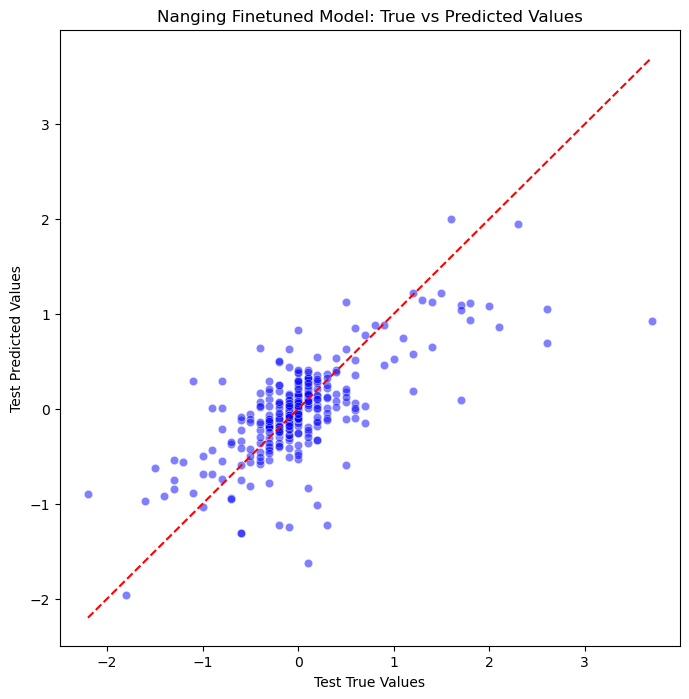

In [1469]:
eval_model(nanging_finetune_model_no_early_stopping, nanging_x_train_finetune, nanging_x_test_finetune, nanging_y_train, nanging_y_test, "Nanging Finetuned Model")

#### Rende

In [1320]:
rende_x_train_finetune = prepare_data_for_finetune_no_city(rende_x_train)
rende_x_test_finetune = prepare_data_for_finetune_no_city(rende_x_test)
rende_x_train_no_val_finetune = prepare_data_for_finetune_no_city(rende_x_train_no_val)
rende_x_val_finetune = prepare_data_for_finetune_no_city(rende_x_val)

rende_x_train_finetune = rende_x_train_finetune[x_train_common_model.columns]
rende_x_test_finetune = rende_x_test_finetune[x_train_common_model.columns]
rende_x_train_no_val_finetune=rende_x_train_no_val_finetune[x_train_common_model.columns]
rende_x_val_finetune=rende_x_val_finetune[x_train_common_model.columns]

In [ ]:
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(100, 800), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(rende_x_train_finetune, rende_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.017829882315170055), ('max_depth', 7), ('n_estimators', 800), ('subsample', 0.5)])


In [1466]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
rende_finetune_model_no_early_stopping = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=100,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.02,
    subsample=0.5,
    early_stopping_rounds=100)  # Reduced learning rate

# rende_finetune_model.fit(rende_x_train_finetune, rende_y_train, xgb_model=model_XGB_common)

rende_finetune_model_no_early_stopping.fit(rende_x_train_no_val_finetune, rende_y_train_no_val, eval_set= [(rende_x_val_finetune, rende_y_val)], xgb_model=model_XGB_common)


[0]	validation_0-rmse:0.22452
[1]	validation_0-rmse:0.22456
[2]	validation_0-rmse:0.22455
[3]	validation_0-rmse:0.22450
[4]	validation_0-rmse:0.22443
[5]	validation_0-rmse:0.22439
[6]	validation_0-rmse:0.22442
[7]	validation_0-rmse:0.22439
[8]	validation_0-rmse:0.22439
[9]	validation_0-rmse:0.22429
[10]	validation_0-rmse:0.22423
[11]	validation_0-rmse:0.22408
[12]	validation_0-rmse:0.22409
[13]	validation_0-rmse:0.22405
[14]	validation_0-rmse:0.22406
[15]	validation_0-rmse:0.22402
[16]	validation_0-rmse:0.22401
[17]	validation_0-rmse:0.22388
[18]	validation_0-rmse:0.22371
[19]	validation_0-rmse:0.22351
[20]	validation_0-rmse:0.22348
[21]	validation_0-rmse:0.22337
[22]	validation_0-rmse:0.22337
[23]	validation_0-rmse:0.22341
[24]	validation_0-rmse:0.22345
[25]	validation_0-rmse:0.22356
[26]	validation_0-rmse:0.22331
[27]	validation_0-rmse:0.22327
[28]	validation_0-rmse:0.22335
[29]	validation_0-rmse:0.22334
[30]	validation_0-rmse:0.22336
[31]	validation_0-rmse:0.22336
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common model, Rende Data
TEST -  mse: 0.16470 | rmse: 0.40584 | mae: 0.20458 | r2: 0.55869
TRAIN -  mse: 0.0589 | rmse: 0.2426 | mae: 0.1352 | r2: 0.8432


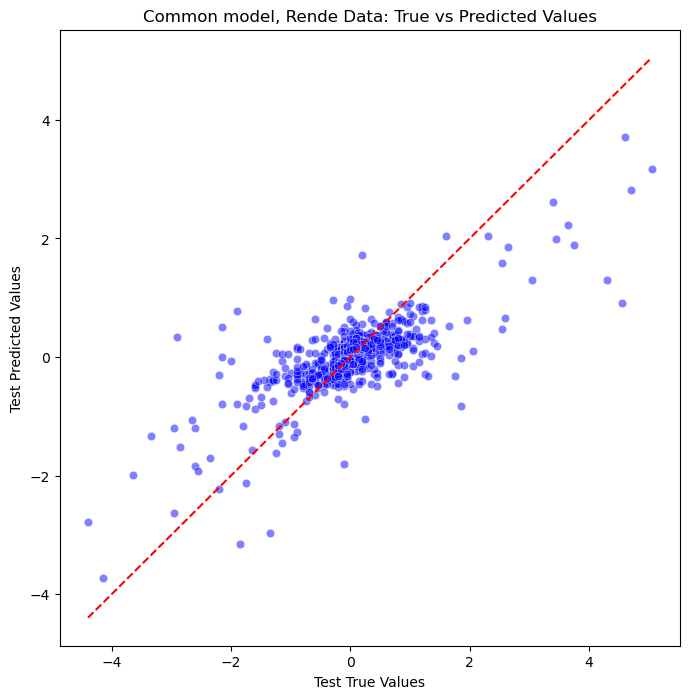

In [1460]:
eval_model(model_XGB_common, rende_x_train_finetune, rende_x_test_finetune, rende_y_train, rende_y_test, "Common model, Rende Data")

Evaluating Model
Rende Finetune Model
TEST -  mse: 0.15899 | rmse: 0.39874 | mae: 0.19986 | r2: 0.57398
TRAIN -  mse: 0.0479 | rmse: 0.2188 | mae: 0.1260 | r2: 0.8725


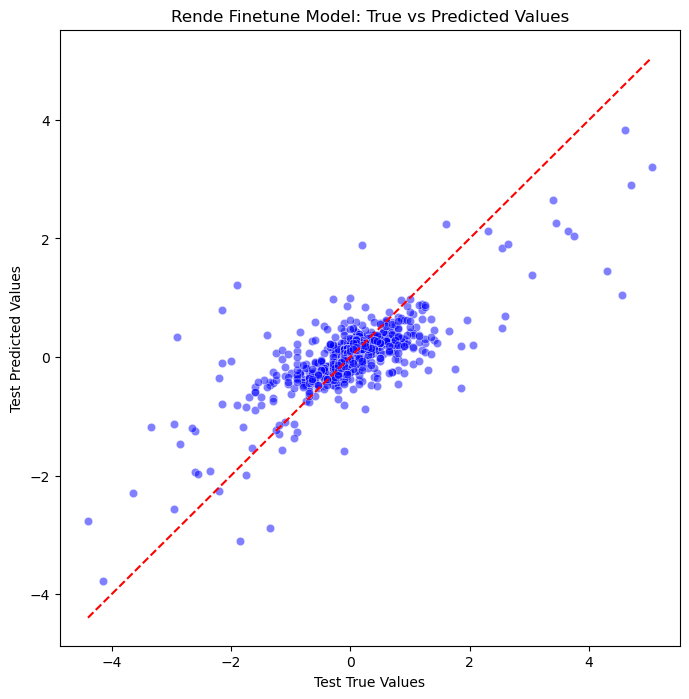

In [1467]:
eval_model(rende_finetune_model_no_early_stopping, rende_x_train_finetune, rende_x_test_finetune, rende_y_train, rende_y_test, "Rende Finetune Model")

#### Sao Paulo

In [1245]:
sp_x_train_finetune = prepare_data_for_finetune_no_city(sp_x_train)
sp_x_test_finetune = prepare_data_for_finetune_no_city(sp_x_test)
sp_x_train_no_val_finetune = prepare_data_for_finetune_no_city(sp_x_train_no_val)
sp_x_val_finetune = prepare_data_for_finetune_no_city(sp_x_val)

sp_x_train_finetune = sp_x_train_finetune[x_train_no_val_common_model.columns]
sp_x_test_finetune = sp_x_test_finetune[x_train_no_val_common_model.columns]
sp_x_train_no_val_finetune=sp_x_train_no_val_finetune[x_train_no_val_common_model.columns]
sp_x_val_finetune=sp_x_val_finetune[x_train_no_val_common_model.columns]

In [ ]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(4, 10), 
                    'n_estimators': Integer(300, 1000), 
                    'learning_rate': (0.01, 0.3, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=4)
opt.fit(sp_x_train_finetune, sp_y_train)
print(f'best params: {opt.best_params_}')

In [1248]:
len(sp_x_val_finetune.columns)

37

In [1464]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
sp_finetune_model_no_early_stopping = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=400,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.036,
    subsample=0.735, #,
    early_stopping_rounds=400)  # Reduced learning rate


sp_finetune_model_no_early_stopping.fit(sp_x_train_no_val_finetune, sp_y_train_no_val, eval_set= [(sp_x_val_finetune, sp_y_val)], xgb_model=model_XGB_common)

[0]	validation_0-rmse:0.20806


[1]	validation_0-rmse:0.20767
[2]	validation_0-rmse:0.20734
[3]	validation_0-rmse:0.20718
[4]	validation_0-rmse:0.20695
[5]	validation_0-rmse:0.20665
[6]	validation_0-rmse:0.20656
[7]	validation_0-rmse:0.20633
[8]	validation_0-rmse:0.20628
[9]	validation_0-rmse:0.20590
[10]	validation_0-rmse:0.20573
[11]	validation_0-rmse:0.20570
[12]	validation_0-rmse:0.20565
[13]	validation_0-rmse:0.20546
[14]	validation_0-rmse:0.20533
[15]	validation_0-rmse:0.20507
[16]	validation_0-rmse:0.20488
[17]	validation_0-rmse:0.20462
[18]	validation_0-rmse:0.20440
[19]	validation_0-rmse:0.20432
[20]	validation_0-rmse:0.20434
[21]	validation_0-rmse:0.20419
[22]	validation_0-rmse:0.20419
[23]	validation_0-rmse:0.20395
[24]	validation_0-rmse:0.20377
[25]	validation_0-rmse:0.20368
[26]	validation_0-rmse:0.20357
[27]	validation_0-rmse:0.20324
[28]	validation_0-rmse:0.20313
[29]	validation_0-rmse:0.20298
[30]	validation_0-rmse:0.20290
[31]	validation_0-rmse:0.20284
[32]	validation_0-rmse:0.20277
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=400,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.036, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Common Model, Sao Paulo Data
TEST -  mse: 0.11786 | rmse: 0.34330 | mae: 0.17502 | r2: 0.43352
TRAIN -  mse: 0.0577 | rmse: 0.2402 | mae: 0.1309 | r2: 0.7167


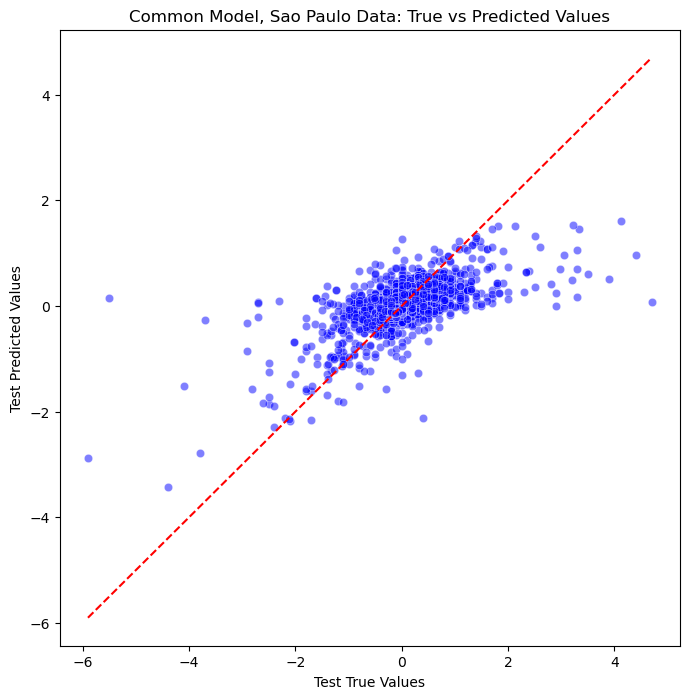

In [1445]:
eval_model(model_XGB_common, sp_x_train_finetune, sp_x_test_finetune, sp_y_train, sp_y_test, "Common Model, Sao Paulo Data")

Evaluating Model
Sao Paulo Finetune Model + Data
TEST -  mse: 0.09497 | rmse: 0.30817 | mae: 0.15162 | r2: 0.54353
TRAIN -  mse: 0.0135 | rmse: 0.1163 | mae: 0.0674 | r2: 0.9336


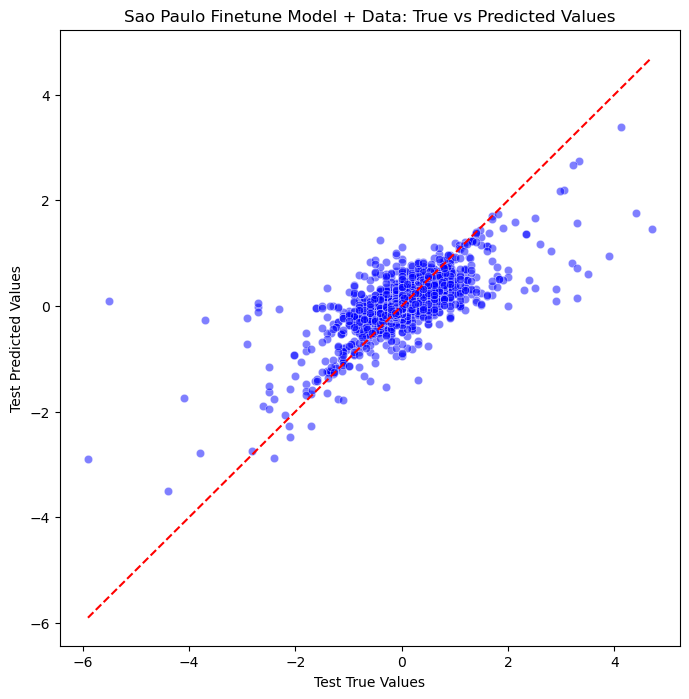

In [1465]:
eval_model(sp_finetune_model_no_early_stopping, sp_x_train_finetune, sp_x_test_finetune, sp_y_train, sp_y_test, "Sao Paulo Finetune Model + Data")

### Decision: For finetune model: Don't give the model the city Feature!!

### Attempt: Do without the dummy room columns since flori only have 1 room. Did not help at all!
Instead: Try a flori only model with no city no room!

In [689]:
flori_x_train_no_room_city = flori_x_train.drop(columns=["City", "Room_ID"])
flori_x_test_no_room_city = flori_x_test # .drop(columns=["City", "Room_ID"])
flori_x_train_no_val_no_room_city = flori_x_train_no_val.drop(columns=["City", "Room_ID"])
flori_x_val_no_room_city = flori_x_val.drop(columns=["City", "Room_ID"])

x_train_no_room_city = x_train.drop(columns=["City", "Room_ID"])
x_test_no_room_city = x_test.drop(columns=["City", "Room_ID"])
x_train_no_val_no_room_city = x_train_no_val.drop(columns=["City", "Room_ID"])
x_val_no_room_city = x_val.drop(columns=["City", "Room_ID"])

In [727]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(flori_x_train_no_room_city, flori_y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.5612475827323402), ('learning_rate', 0.011753996864476304), ('max_depth', 10), ('n_estimators', 378), ('subsample', 0.5)])


In [728]:
model_XGB_flori_no_room_city = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0117, 
                            n_estimators=378,
                            subsample=0.5,
                            colsample_bytree=0.56,
                            early_stopping_rounds=10)
model_XGB_flori_no_room_city.fit(x_train_no_val_no_room_city, y_train_no_val, eval_set=[(x_val_no_room_city, y_val)])

[0]	validation_0-rmse:0.67702


[1]	validation_0-rmse:0.67221
[2]	validation_0-rmse:0.66793
[3]	validation_0-rmse:0.66326
[4]	validation_0-rmse:0.65870
[5]	validation_0-rmse:0.65442
[6]	validation_0-rmse:0.64968
[7]	validation_0-rmse:0.64531
[8]	validation_0-rmse:0.64113
[9]	validation_0-rmse:0.63661
[10]	validation_0-rmse:0.63244
[11]	validation_0-rmse:0.62865
[12]	validation_0-rmse:0.62448
[13]	validation_0-rmse:0.62066
[14]	validation_0-rmse:0.61634
[15]	validation_0-rmse:0.61257
[16]	validation_0-rmse:0.60861
[17]	validation_0-rmse:0.60462
[18]	validation_0-rmse:0.60094
[19]	validation_0-rmse:0.59682
[20]	validation_0-rmse:0.59329
[21]	validation_0-rmse:0.58992
[22]	validation_0-rmse:0.58648
[23]	validation_0-rmse:0.58330
[24]	validation_0-rmse:0.57962
[25]	validation_0-rmse:0.57646
[26]	validation_0-rmse:0.57309
[27]	validation_0-rmse:0.57001
[28]	validation_0-rmse:0.56659
[29]	validation_0-rmse:0.56319
[30]	validation_0-rmse:0.56044
[31]	validation_0-rmse:0.55714
[32]	validation_0-rmse:0.55400
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.56, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0117, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=378, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
Florianopolis Only Model
TEST -  mse: 0.16726807170909186 | rmse: 0.40898419493800964 | mae: 0.20152980075586496 | r2: -0.04647146967720639
TRAIN -  mse: 0.07386107529078374 | rmse: 0.2717739415226996 | mae: 0.1408275538212571 | r2: 0.6596353249763796


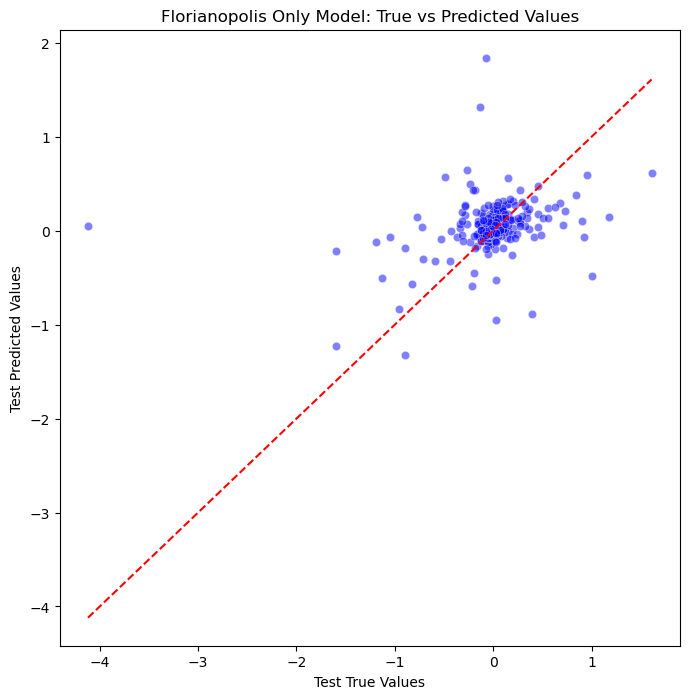

In [731]:
eval_model(model_XGB_flori_no_room_city, flori_x_train_no_room_city, flori_x_test_no_room_city, flori_y_train, flori_y_test, "Florianopolis Only Model")

In [ ]:
# TODO 
# AAA Find research/paper on how to finetune with XGBoost
# A investigate feature importance for florianopolis model
# B do the same done for florianopolice but for Rende (has only 1 room), then for the 2 others with 1 hot encoding the room
# https://arxiv.org/abs/1909.07218 ??
# https://dl.acm.org/doi/pdf/10.1145/2939672.2939785 ??

# B train per city models. Then compare in a table the
# 1) general model
# 2) per city model
# 3) multi task model (common + fine tune per city). Go with the one that did the best

In [ ]:
import xgboost as xgb

# Step 1: Train the global model with an initial learning rate
global_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
global_model.fit(X_train_full, y_train_full)

# Step 2: Fine-tune for a specific city with a smaller learning rate
city_model = xgb.XGBRegressor(**global_model.get_params(), learning_rate=0.01)  # Reduced learning rate
city_model.fit(X_train_city, y_train_city, xgb_model=global_model)  # Continue training

## 9. Calculate a results DF

In [1039]:
columns = [
    'Model', 
    'Florianopolis-Train', 
    'Florianopolis-Test',
    'Nanjing-Train', 
    'Nanjing-Test', 
    'Rende-Train', 
    'Rende-Test', 
    'Sao Paulo-Train', 
    'Sao Paulo-Test', 
    'All-Train', 
    'All-Test', 
    'Description'
]


In [84]:

def rmse(y, y_pred):
    mse =  mean_squared_error(y, y_pred)
    return np.sqrt(mse)

eval_metrics = {
    # "RMSE": rmse,
    "MAE": mean_absolute_error,
    "R2": r2_score,
    }

def eval_model_on_data(model, x, y, metric_name, evaluation_title):
    y_pred = model.predict(x)
    res =  eval_metrics[metric_name](y, y_pred)

    print(f"Evaluating {metric_name} of {evaluation_title}")
    print(f"metric: {res:.3f}")

    return round(res, 3)

In [83]:

def add_model_metric_result(results_df, model, data_dict, metric_name, model_name, model_description):
    row_num = len(results_df)

    for dataname, (data_x, data_y) in data_dict.items():
        results_df.loc[row_num, f"{dataname}"] = eval_model_on_data(model, data_x, data_y, metric_name, f"{model_name}: {dataname}")

    results_df.loc[row_num,'Model'] = f"{model_name} - {metric_name}"
    results_df.loc[row_num,'Description'] = model_description

    return results_df
    # new_row = {
    #     'Florianopolis-Train': 0.9,
    #     'Florianopolis-Test': 0.85,
    #     'Nanjing-Train': 0.92,
    #     'Nanjing-Test': 0.87,
    #     'Rende-Train': 0.88,
    #     'Rende-Test': 0.86,
    #     'SP-Train': 0.91,
    #     'SP-Test': 0.89,
    #     'All-Train': 0.9,
    #     'All-Test': 0.88
    # }
    # results_df.loc[row_num] = new_row

def add_model_results(results_df, model, data_dict, model_name, model_description):
    for metric_name in eval_metrics.keys():
        add_model_metric_result(results_df, model, data_dict, metric_name, model_name, model_description)


In [44]:
cities = {'Florianopolis', 'Nanjing', 'Rende', 'Sao Paulo'}      
def get_city_data(city,x,y):
    city_x = x[x['City'] == city_encode_mapping[city]]
    city_y = y[x['City'] == city_encode_mapping[city]]
    return city_x, city_y


In [51]:
# get_train_test_sets_for_city("Florianopolis", x_train, x_test, y_train, y_test)

def get_data_dict(x_train, x_test, y_train, y_test, cities=cities):
    data_dict = {}        
    for city in cities:
        data_dict[f"{city}-Train"] = get_city_data(city, x_train, y_train)
        data_dict[f"{city}-Test"] = get_city_data(city, x_test, y_test)
    data_dict["All-Train"] = x_train, y_train
    data_dict["All-Test"] = x_test, y_test
    return data_dict

### Paper Model - Original

In [1056]:
results_df = pd.DataFrame(columns=columns)


In [1057]:
original_model_data_dict = get_data_dict(x_train_paper, x_test_paper, y_train_paper, y_test_paper)

In [1058]:
add_model_results(results_df, model_XGB_original, original_model_data_dict, "Original Paper Model", "Reproduce model from paper with no changes")

Evaluating MAE of Original Paper Model: Sao Paulo-Train
metric: 0.121
Evaluating MAE of Original Paper Model: Sao Paulo-Test
metric: 0.175
Evaluating MAE of Original Paper Model: Nanjing-Train
metric: 0.123
Evaluating MAE of Original Paper Model: Nanjing-Test
metric: 0.250
Evaluating MAE of Original Paper Model: Rende-Train
metric: 0.131
Evaluating MAE of Original Paper Model: Rende-Test
metric: 0.188
Evaluating MAE of Original Paper Model: Florianopolis-Train
metric: 0.102
Evaluating MAE of Original Paper Model: Florianopolis-Test
metric: 0.208
Evaluating MAE of Original Paper Model: All-Train
metric: 0.122
Evaluating MAE of Original Paper Model: All-Test
metric: 0.182
Evaluating R2 of Original Paper Model: Sao Paulo-Train
metric: 0.831
Evaluating R2 of Original Paper Model: Sao Paulo-Test
metric: 0.404
Evaluating R2 of Original Paper Model: Nanjing-Train
metric: 0.899
Evaluating R2 of Original Paper Model: Nanjing-Test
metric: 0.602
Evaluating R2 of Original Paper Model: Rende-Train


In [1059]:
results_df.head()

Model Florianopolis-Train Florianopolis-Test  \
0  Original Paper Model - MAE               0.102              0.208   
1   Original Paper Model - R2               0.852              0.169   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.123         0.25       0.131      0.188           0.121   
1         0.899        0.602       0.873      0.595           0.831   

  Sao Paulo-Test All-Train All-Test  \
0          0.175     0.122    0.182   
1          0.404     0.847    0.466   

                                  Description  
0  Reproduce model from paper with no changes  
1  Reproduce model from paper with no changes

### Paper Model - Clean

In [ ]:
# model_XGB_stratified_clean, x_train, x_test, y_train, y_test, "Paper Model + Stratified + Clean"

In [1061]:
clean_stratified_model_data_dict = get_data_dict(x_train, x_test, y_train, y_test)

In [1062]:
add_model_results(results_df, model_XGB_stratified_clean, clean_stratified_model_data_dict, "Paper Model Clean", "Model methodology used in paper, with two changes: 1) Clean data. 2) Stratify split on city")

Evaluating MAE of Paper Model Clean: Sao Paulo-Train
metric: 0.123
Evaluating MAE of Paper Model Clean: Sao Paulo-Test
metric: 0.172
Evaluating MAE of Paper Model Clean: Nanjing-Train
metric: 0.133
Evaluating MAE of Paper Model Clean: Nanjing-Test
metric: 0.291
Evaluating MAE of Paper Model Clean: Rende-Train
metric: 0.135
Evaluating MAE of Paper Model Clean: Rende-Test
metric: 0.204
Evaluating MAE of Paper Model Clean: Florianopolis-Train
metric: 0.106
Evaluating MAE of Paper Model Clean: Florianopolis-Test
metric: 0.222
Evaluating MAE of Paper Model Clean: All-Train
metric: 0.126
Evaluating MAE of Paper Model Clean: All-Test
metric: 0.186
Evaluating R2 of Paper Model Clean: Sao Paulo-Train
metric: 0.783
Evaluating R2 of Paper Model Clean: Sao Paulo-Test
metric: 0.469
Evaluating R2 of Paper Model Clean: Nanjing-Train
metric: 0.876
Evaluating R2 of Paper Model Clean: Nanjing-Test
metric: 0.452
Evaluating R2 of Paper Model Clean: Rende-Train
metric: 0.860
Evaluating R2 of Paper Model Cl

In [1063]:
results_df.head()

Model Florianopolis-Train Florianopolis-Test  \
0  Original Paper Model - MAE               0.102              0.208   
1   Original Paper Model - R2               0.852              0.169   
2     Paper Model Clean - MAE               0.106              0.222   
3      Paper Model Clean - R2               0.851             -0.218   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.123         0.25       0.131      0.188           0.121   
1         0.899        0.602       0.873      0.595           0.831   
2         0.133        0.291       0.135      0.204           0.123   
3         0.876        0.452        0.86      0.588           0.783   

  Sao Paulo-Test All-Train All-Test  \
0          0.175     0.122    0.182   
1          0.404     0.847    0.466   
2          0.172     0.126    0.186   
3          0.469     0.815    0.489   

                                         Description  
0         Reproduce model from paper with no changes  
1         Reproduce model from paper with no changes  
2  Model methodology used in paper, with two chan...  
3  Model methodology used in paper, with two chan...

### Encode Data, Improve HyperParams tuning

In [1613]:
def get_city_encoded_data(city,x,y,required_cols):
    city_data_x, city_data_y = get_city_data(city, x, y)
    city_data_x = pd.get_dummies(city_data_x, columns=['Room_ID', 'City'], prefix=['Room_', 'City_'], dtype=float)
    city_data_x = city_data_x.rename(columns={f'City__{k}': f'City__{v}' for k, v in city_reverse_encode_mapping.items()})    

    required_room_columns = [f"Room__{i}" for i in range(18)]
    required_city_columns = [f"City__{v}" for v in city_encode_mapping.keys()]
    for col in required_room_columns + required_city_columns:
        if col not in city_data_x.columns:
            city_data_x[col] = 0.0 
    # print(city_data_x.columns)
    city_data_x = city_data_x[required_cols]
    return city_data_x, city_data_y

def get_general_encoded_data(x,y,required_cols):
    x = pd.get_dummies(x, columns=['Room_ID', 'City'], prefix=['Room_', 'City_'], dtype=float)
    x = x.rename(columns={f'City__{k}': f'City__{v}' for k, v in city_reverse_encode_mapping.items()})    
    x = x[required_cols]
    return x, y

def get_and_encode_data_dict(x_train, x_test, y_train, y_test, required_cols, cities=cities):
    data_dict = {}        
    for city in cities:
        data_dict[f"{city}-Train"] = get_city_encoded_data(city, x_train, y_train,required_cols)
        data_dict[f"{city}-Test"] = get_city_encoded_data(city, x_test, y_test,required_cols)
    data_dict["All-Train"] = get_general_encoded_data(x_train, y_train,required_cols)
    data_dict["All-Test"] = get_general_encoded_data(x_test, y_test,required_cols)
    return data_dict

In [303]:
x_train_encoded = onehot_encode_city_room(x_train)
x_test_encoded = onehot_encode_city_room(x_test)

In [1104]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_V1_encoded = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0288, 
                            n_estimators=1200,
                            subsample=0.725,
                            colsample_bytree= 0.87
                            )
model_XGB_V1_encoded.fit(x_train_encoded,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.87, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0288, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

In [1105]:
x_train_encoded = x_train_encoded[x_train_encoded.columns]

In [1109]:
encoded_model_data_dict = get_and_encode_data_dict(x_train, x_test, y_train, y_test, x_train_encoded.columns)

In [1110]:
add_model_results(results_df, model_XGB_V1_encoded, encoded_model_data_dict, "General Model V1", "Improved general model: Better hyper parameters selection, 1-hot encoding for cities and rooms")

Evaluating MAE of General Model V1: Sao Paulo-Train
metric: 0.041
Evaluating MAE of General Model V1: Sao Paulo-Test
metric: 0.140
Evaluating MAE of General Model V1: Nanjing-Train
metric: 0.038
Evaluating MAE of General Model V1: Nanjing-Test
metric: 0.248
Evaluating MAE of General Model V1: Rende-Train
metric: 0.055
Evaluating MAE of General Model V1: Rende-Test
metric: 0.194
Evaluating MAE of General Model V1: Florianopolis-Train
metric: 0.032
Evaluating MAE of General Model V1: Florianopolis-Test
metric: 0.199
Evaluating MAE of General Model V1: All-Train
metric: 0.044
Evaluating MAE of General Model V1: All-Test
metric: 0.158
Evaluating R2 of General Model V1: Sao Paulo-Train
metric: 0.982
Evaluating R2 of General Model V1: Sao Paulo-Test
metric: 0.575
Evaluating R2 of General Model V1: Nanjing-Train
metric: 0.992
Evaluating R2 of General Model V1: Nanjing-Test
metric: 0.561
Evaluating R2 of General Model V1: Rende-Train
metric: 0.981
Evaluating R2 of General Model V1: Rende-Test


In [1112]:
results_df.head(20)

Model Florianopolis-Train Florianopolis-Test  \
0  Original Paper Model - MAE               0.102              0.208   
1   Original Paper Model - R2               0.852              0.169   
2     Paper Model Clean - MAE               0.106              0.222   
3      Paper Model Clean - R2               0.851             -0.218   
4      General Model V1 - MAE               0.032              0.199   
5       General Model V1 - R2               0.988             -0.113   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.123         0.25       0.131      0.188           0.121   
1         0.899        0.602       0.873      0.595           0.831   
2         0.133        0.291       0.135      0.204           0.123   
3         0.876        0.452        0.86      0.588           0.783   
4         0.038        0.248       0.055      0.194           0.041   
5         0.992        0.561       0.981      0.605           0.982   

  Sao Paulo-Test All-Train All-Test  \
0          0.175     0.122    0.182   
1          0.404     0.847    0.466   
2          0.172     0.126    0.186   
3          0.469     0.815    0.489   
4           0.14     0.044    0.158   
5          0.575     0.982    0.567   

                                         Description  
0         Reproduce model from paper with no changes  
1         Reproduce model from paper with no changes  
2  Model methodology used in paper, with two chan...  
3  Model methodology used in paper, with two chan...  
4  Improved general model: Better hyper parameter...  
5  Improved general model: Better hyper parameter...

In [1114]:
x_train_no_val_encoded = onehot_encode_city_room(x_train_no_val)
x_val_encoded = onehot_encode_city_room(x_val)
model_XGB_V2_encoded = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0288, 
                            n_estimators=1200,
                            subsample=0.725,
                            colsample_bytree= 0.87,
                            early_stopping_rounds=10)
model_XGB_V2_encoded.fit(x_train_no_val_encoded, y_train_no_val, eval_set=[(x_val_encoded, y_val)])

[0]	validation_0-rmse:0.66867
[1]	validation_0-rmse:0.65650
[2]	validation_0-rmse:0.64476
[3]	validation_0-rmse:0.63337
[4]	validation_0-rmse:0.62203
[5]	validation_0-rmse:0.61166
[6]	validation_0-rmse:0.60087
[7]	validation_0-rmse:0.59032
[8]	validation_0-rmse:0.58068
[9]	validation_0-rmse:0.57151
[10]	validation_0-rmse:0.56236
[11]	validation_0-rmse:0.55388
[12]	validation_0-rmse:0.54560
[13]	validation_0-rmse:0.53739
[14]	validation_0-rmse:0.52935
[15]	validation_0-rmse:0.52147
[16]	validation_0-rmse:0.51467
[17]	validation_0-rmse:0.50753
[18]	validation_0-rmse:0.50085
[19]	validation_0-rmse:0.49413
[20]	validation_0-rmse:0.48791
[21]	validation_0-rmse:0.48179
[22]	validation_0-rmse:0.47580
[23]	validation_0-rmse:0.47065
[24]	validation_0-rmse:0.46555
[25]	validation_0-rmse:0.46073
[26]	validation_0-rmse:0.45586
[27]	validation_0-rmse:0.45123
[28]	validation_0-rmse:0.44663
[29]	validation_0-rmse:0.44220
[30]	validation_0-rmse:0.43796
[31]	validation_0-rmse:0.43374
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.87, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0288, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

In [1120]:
add_model_results(results_df, model_XGB_V2_encoded, encoded_model_data_dict, "General Model V2", "Just like general model V1, but with early stopping")

Evaluating MAE of General Model V2: Sao Paulo-Train
metric: 0.086
Evaluating MAE of General Model V2: Sao Paulo-Test
metric: 0.154
Evaluating MAE of General Model V2: Nanjing-Train
metric: 0.105
Evaluating MAE of General Model V2: Nanjing-Test
metric: 0.256
Evaluating MAE of General Model V2: Rende-Train
metric: 0.105
Evaluating MAE of General Model V2: Rende-Test
metric: 0.199
Evaluating MAE of General Model V2: Florianopolis-Train
metric: 0.084
Evaluating MAE of General Model V2: Florianopolis-Test
metric: 0.201
Evaluating MAE of General Model V2: All-Train
metric: 0.091
Evaluating MAE of General Model V2: All-Test
metric: 0.169
Evaluating R2 of General Model V2: Sao Paulo-Train
metric: 0.863
Evaluating R2 of General Model V2: Sao Paulo-Test
metric: 0.526
Evaluating R2 of General Model V2: Nanjing-Train
metric: 0.887
Evaluating R2 of General Model V2: Nanjing-Test
metric: 0.509
Evaluating R2 of General Model V2: Rende-Train
metric: 0.896
Evaluating R2 of General Model V2: Rende-Test


In [1121]:
results_df.head(20)

Model Florianopolis-Train Florianopolis-Test  \
0  Original Paper Model - MAE               0.102              0.208   
1   Original Paper Model - R2               0.852              0.169   
2     Paper Model Clean - MAE               0.106              0.222   
3      Paper Model Clean - R2               0.851             -0.218   
4      General Model V1 - MAE               0.032              0.199   
5       General Model V1 - R2               0.988             -0.113   
6      General Model V2 - MAE               0.084              0.201   
7       General Model V2 - R2               0.845              -0.08   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.123         0.25       0.131      0.188           0.121   
1         0.899        0.602       0.873      0.595           0.831   
2         0.133        0.291       0.135      0.204           0.123   
3         0.876        0.452        0.86      0.588           0.783   
4         0.038        0.248       0.055      0.194           0.041   
5         0.992        0.561       0.981      0.605           0.982   
6         0.105        0.256       0.105      0.199           0.086   
7         0.887        0.509       0.896       0.58           0.863   

  Sao Paulo-Test All-Train All-Test  \
0          0.175     0.122    0.182   
1          0.404     0.847    0.466   
2          0.172     0.126    0.186   
3          0.469     0.815    0.489   
4           0.14     0.044    0.158   
5          0.575     0.982    0.567   
6          0.154     0.091    0.169   
7          0.526     0.874    0.527   

                                         Description  
0         Reproduce model from paper with no changes  
1         Reproduce model from paper with no changes  
2  Model methodology used in paper, with two chan...  
3  Model methodology used in paper, with two chan...  
4  Improved general model: Better hyper parameter...  
5  Improved general model: Better hyper parameter...  
6  Just like general model V1, but with early sto...  
7  Just like general model V1, but with early sto...

In [ ]:
# TODO:
# Wrap a:
# 1) Finetune model
# 2) separated model per each city
# Then calculate their results and add each to a row in the table

### Per-city model

In [1261]:
flori_x_train_finetune = prepare_data_for_finetune(flori_x_train)
flori_x_test_finetune = prepare_data_for_finetune(flori_x_test)
flori_x_train_finetune = flori_x_train_finetune[x_train_common_model.columns]
flori_x_test_finetune = flori_x_test_finetune[x_test_common_model.columns]

In [1264]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
flori_model = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=50,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.2,
    subsample=1.0)#,
    # early_stopping_rounds=15)  # Reduced learning rate


# flori_model.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set= [(flori_x_val_finetune, flori_y_val)])
flori_model.fit(flori_x_train_finetune, flori_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [1268]:
nanging_x_train_finetune = prepare_data_for_finetune_no_city(nanging_x_train)
nanging_x_test_finetune = prepare_data_for_finetune_no_city(nanging_x_test)
nanging_x_train_no_val_finetune = prepare_data_for_finetune_no_city(nanging_x_train_no_val)
nanging_x_val_finetune = prepare_data_for_finetune_no_city(nanging_x_val)

nanging_x_train_finetune = nanging_x_train_finetune[x_train_common_model.columns]
nanging_x_test_finetune = nanging_x_test_finetune[x_train_common_model.columns]
nanging_x_train_no_val_finetune=nanging_x_train_no_val_finetune[x_train_common_model.columns]
nanging_x_val_finetune=nanging_x_val_finetune[x_train_common_model.columns]

In [1281]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
nanging_model = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=283,
    colsample_bytree=1.0,
    learning_rate=0.0168,
    subsample=0.5)
    # early_stopping_rounds=10) 


# nanging_model.fit(nanging_x_train_no_val_finetune, nanging_y_train_no_val, eval_set= [(nanging_x_val_finetune, nanging_y_val)])
nanging_model.fit(nanging_x_train_finetune, nanging_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0168, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=283, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [1279]:
rende_x_train_finetune = prepare_data_for_finetune_no_city(rende_x_train)
rende_x_test_finetune = prepare_data_for_finetune_no_city(rende_x_test)
rende_x_train_no_val_finetune = prepare_data_for_finetune_no_city(rende_x_train_no_val)
rende_x_val_finetune = prepare_data_for_finetune_no_city(rende_x_val)

rende_x_train_finetune = rende_x_train_finetune[x_train_common_model.columns]
rende_x_test_finetune = rende_x_test_finetune[x_train_common_model.columns]
rende_x_train_no_val_finetune=rende_x_train_no_val_finetune[x_train_common_model.columns]
rende_x_val_finetune=rende_x_val_finetune[x_train_common_model.columns]

In [1280]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
rende_model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=800,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0178,
    subsample=0.5) #,
    # early_stopping_rounds=10)  # Reduced learning rate


# rende_model.fit(rende_x_train_no_val_finetune, rende_y_train_no_val, eval_set= [(rende_x_val_finetune, rende_y_val)])
rende_model.fit(rende_x_train_finetune, rende_y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0178, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [1277]:
sp_x_train_finetune = prepare_data_for_finetune_no_city(sp_x_train)
sp_x_test_finetune = prepare_data_for_finetune_no_city(sp_x_test)
sp_x_train_no_val_finetune = prepare_data_for_finetune_no_city(sp_x_train_no_val)
sp_x_val_finetune = prepare_data_for_finetune_no_city(sp_x_val)

sp_x_train_finetune = sp_x_train_finetune[x_train_common_model.columns]
sp_x_test_finetune = sp_x_test_finetune[x_train_common_model.columns]
sp_x_train_no_val_finetune=sp_x_train_no_val_finetune[x_train_common_model.columns]
sp_x_val_finetune=sp_x_val_finetune[x_train_common_model.columns]

In [1278]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
sp_model = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.03598,
    subsample=0.735) #,
    # early_stopping_rounds=10)  # Reduced learning rate


# sp_model.fit(sp_x_train_no_val_finetune, sp_y_train_no_val, eval_set= [(sp_x_val_finetune, sp_y_val)])
sp_model.fit(sp_x_train_finetune, sp_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03598, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [60]:
class CityModelWrapper:
    def __init__(self, models_dict):
        """
        Initialize the wrapper with a dictionary of models, where the key is the city name and
        the value is the trained XGBoost model for that city.

        Parameters:
        models_dict (dict): A dictionary mapping city names to trained XGB models.
        """
        self.models_dict = models_dict

    def predict(self, X):
        """
        Predict using the appropriate model based on the 'City' column in the input DataFrame.

        Parameters:
        X (pd.DataFrame): The input data, including a 'City' column.

        Returns:
        pd.Series: A series of predictions for the input samples.
        """
        if 'City' not in X.columns:
            raise ValueError("Input data must contain a 'City' column.")
        
        predictions = []
        
        # Iterate over each row to route samples to the correct model
        for _, row in X.iterrows():
            city = city_reverse_encode_mapping[row['City']]
            if city not in self.models_dict:
                raise ValueError(f"No model found for city: {city}")
            
            # Get the model for the city and predict for this row (drop 'City' for model input)
            model = self.models_dict[city]
            features = row.drop('City').values.reshape(1, -1)
            pred = model.predict(features)
            predictions.append(pred[0])  # Assuming pred returns a list or array
        
        return pd.Series(predictions)

In [1282]:
# models_dict = {"Florianopolis": flori_model, 
#                "Nanjing": nanging_model, 
#                "Rende": rende_model,
#                "Sao Paulo": sp_model}
models_dict_no_early_stopping = {"Florianopolis": flori_model, 
               "Nanjing": nanging_model, 
               "Rende": rende_model,
               "Sao Paulo": sp_model}
# per_city_model = CityModelWrapper(models_dict)
per_city_model_no_early_stoppin = CityModelWrapper(models_dict_no_early_stopping)

In [62]:
def prepare_data_for_per_city_eval(raw_data):
    raw_data = pd.get_dummies(raw_data, columns=['Room_ID'], prefix=['Room_'], dtype=float)
    return raw_data

In [1169]:
x_train_per_city_model = prepare_data_for_per_city_eval(x_train)

In [1171]:
x_test_per_city_model =prepare_data_for_per_city_eval(x_test)
x_test_per_city_model = x_test_per_city_model[x_train_per_city_model.columns]


In [141]:
def get_per_city_model_data_dict(x_train, x_test, y_train, y_test, cities=cities):
    data_dict = {} 

    x_train_per_city_model = prepare_data_for_per_city_eval(x_train)
    print(x_train_per_city_model.columns)
    x_test_per_city_model = prepare_data_for_per_city_eval(x_test)
    x_test_per_city_model = x_test_per_city_model[x_train_per_city_model.columns]

    data_dict["All-Train"] =x_train_per_city_model, y_train
    data_dict["All-Test"] = x_test_per_city_model, y_test
    
    for city in cities:
        data_dict[f"{city}-Train"] = get_city_data(city, x_train_per_city_model, y_train)
        data_dict[f"{city}-Test"] = get_city_data(city, x_test_per_city_model, y_test)

    for _k, (x,_y) in data_dict.items():
        x = x[x_train_per_city_model.columns]
    return data_dict

In [106]:
per_city_model_data_dict = get_per_city_model_data_dict(x_train, x_test, y_train, y_test)

In [1284]:
# add_model_results(results_df, per_city_model, per_city_model_data_dict, "Per City Model", "Different model for each city, trained separately on this city's data")
add_model_results(results_df, per_city_model_no_early_stoppin, per_city_model_data_dict, "Per City Model- No Early Stopping", "Different model for each city, trained separately on this city's data")

Evaluating MAE of Per City Model- No Early Stopping: All-Train
metric: 0.047
Evaluating MAE of Per City Model- No Early Stopping: All-Test
metric: 0.155
Evaluating MAE of Per City Model- No Early Stopping: Sao Paulo-Train
metric: 0.026
Evaluating MAE of Per City Model- No Early Stopping: Sao Paulo-Test
metric: 0.136
Evaluating MAE of Per City Model- No Early Stopping: Nanjing-Train
metric: 0.082
Evaluating MAE of Per City Model- No Early Stopping: Nanjing-Test
metric: 0.233
Evaluating MAE of Per City Model- No Early Stopping: Rende-Train
metric: 0.098
Evaluating MAE of Per City Model- No Early Stopping: Rende-Test
metric: 0.196
Evaluating MAE of Per City Model- No Early Stopping: Florianopolis-Train
metric: 0.141
Evaluating MAE of Per City Model- No Early Stopping: Florianopolis-Test
metric: 0.201
Evaluating R2 of Per City Model- No Early Stopping: All-Train
metric: 0.960
Evaluating R2 of Per City Model- No Early Stopping: All-Test
metric: 0.573
Evaluating R2 of Per City Model- No Earl

In [1286]:
results_df.to_csv("Results_25_09.csv")

In [1189]:
results_df.head(20)

Model Florianopolis-Train Florianopolis-Test  \
0  Original Paper Model - MAE               0.102              0.208   
1   Original Paper Model - R2               0.852              0.169   
2     Paper Model Clean - MAE               0.106              0.222   
3      Paper Model Clean - R2               0.851             -0.218   
4      General Model V1 - MAE               0.032              0.199   
5       General Model V1 - R2               0.988             -0.113   
6      General Model V2 - MAE               0.084              0.201   
7       General Model V2 - R2               0.845              -0.08   
8        Per City Model - MAE               0.146              0.189   
9         Per City Model - R2               0.628               0.08   

  Nanjing-Train Nanjing-Test Rende-Train Rende-Test Sao Paulo-Train  \
0         0.123         0.25       0.131      0.188           0.121   
1         0.899        0.602       0.873      0.595           0.831   
2         0.133        0.291       0.135      0.204           0.123   
3         0.876        0.452        0.86      0.588           0.783   
4         0.038        0.248       0.055      0.194           0.041   
5         0.992        0.561       0.981      0.605           0.982   
6         0.105        0.256       0.105      0.199           0.086   
7         0.887        0.509       0.896       0.58           0.863   
8          0.11         0.24       0.132      0.205           0.058   
9         0.896        0.568       0.841      0.546           0.895   

  Sao Paulo-Test All-Train All-Test  \
0          0.175     0.122    0.182   
1          0.404     0.847    0.466   
2          0.172     0.126    0.186   
3          0.469     0.815    0.489   
4           0.14     0.044    0.158   
5          0.575     0.982    0.567   
6          0.154     0.091    0.169   
7          0.526     0.874    0.527   
8          0.146     0.078    0.164   
9          0.535      0.87     0.53   

                                         Description  
0         Reproduce model from paper with no changes  
1         Reproduce model from paper with no changes  
2  Model methodology used in paper, with two chan...  
3  Model methodology used in paper, with two chan...  
4  Improved general model: Better hyper parameter...  
5  Improved general model: Better hyper parameter...  
6  Just like general model V1, but with early sto...  
7  Just like general model V1, but with early sto...  
8  Different model for each city, trained separat...  
9  Different model for each city, trained separat...

In [1235]:
rende_train_x_temp, _y = per_city_model_data_dict["Sao Paulo-Train"]
rende_test_x_temp, _y_ =per_city_model_data_dict["Sao Paulo-Test"]

In [1221]:
# rende_train_x_temp_a = rende_train_x_temp.drop(columns=["City"])
# rende_test_x_temp_a = rende_test_x_temp.drop(columns=["City"])
# eval_model(models_dict["Rende"], rende_train_x_temp_a, rende_test_x_temp_a,rende_y_train,rende_y_test,"Rende Model")

In [ ]:
#TODO add the finetune model!!! And thats it!!!

### Finetune Model

In [1253]:
finetune_models_dict = {"Florianopolis": flori_finetune_model, 
               "Nanjing": nanging_finetune_model, 
               "Rende": rende_finetune_model,
               "Sao Paulo": sp_finetune_model}
per_city_finetune_model = CityModelWrapper(finetune_models_dict)

In [1254]:
attempt = per_city_finetune_model.predict(rende_train_x_temp)

In [1255]:
attempt

0       -0.251334
1        1.706596
2       -0.323931
3       -0.875492
4        0.351460
           ...   
23684    0.115832
23685   -0.331455
23686    0.103776
23687    0.026198
23688   -0.084098
Length: 23689, dtype: float32

In [1256]:
add_model_results(results_df, per_city_finetune_model, per_city_model_data_dict, "Per-City Finetune Model", "Each city has its own model, started by being trained on all data, and fine-tuned to this City's data")

Evaluating MAE of Per-City Finetune Model: All-Train
metric: 0.106
Evaluating MAE of Per-City Finetune Model: All-Test
metric: 0.180
Evaluating MAE of Per-City Finetune Model: Sao Paulo-Train
metric: 0.104
Evaluating MAE of Per-City Finetune Model: Sao Paulo-Test
metric: 0.166
Evaluating MAE of Per-City Finetune Model: Nanjing-Train
metric: 0.111
Evaluating MAE of Per-City Finetune Model: Nanjing-Test
metric: 0.269
Evaluating MAE of Per-City Finetune Model: Rende-Train
metric: 0.116
Evaluating MAE of Per-City Finetune Model: Rende-Test
metric: 0.204
Evaluating MAE of Per-City Finetune Model: Florianopolis-Train
metric: 0.093
Evaluating MAE of Per-City Finetune Model: Florianopolis-Test
metric: 0.209
Evaluating R2 of Per-City Finetune Model: All-Train
metric: 0.858
Evaluating R2 of Per-City Finetune Model: All-Test
metric: 0.497
Evaluating R2 of Per-City Finetune Model: Sao Paulo-Train
metric: 0.845
Evaluating R2 of Per-City Finetune Model: Sao Paulo-Test
metric: 0.487
Evaluating R2 of 

In [1259]:
results_df.to_csv("Results_24_09.csv")

## Finetune model Model: No Early Stopping

In [1449]:
finetune_models_dict_no_early_stopping = {"Florianopolis": flori_finetune_model_no_early_stopping, 
               "Nanjing": nanging_finetune_model_no_early_stopping, 
               "Rende": rende_finetune_model_no_early_stopping,
               "Sao Paulo": sp_finetune_model_no_early_stopping}
per_city_finetune_model_no_early_stopping = CityModelWrapper(finetune_models_dict_no_early_stopping)

In [1450]:
add_model_results(results_df, per_city_finetune_model_no_early_stopping, per_city_model_data_dict, "Per-City Finetune Model - No Early Stopping", "Each city has its own model, started by being trained on all data, and fine-tuned to this City's data")

Evaluating MAE of Per-City Finetune Model - No Early Stopping: All-Train
metric: 0.084
Evaluating MAE of Per-City Finetune Model - No Early Stopping: All-Test
metric: 0.169
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Sao Paulo-Train
metric: 0.067
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Sao Paulo-Test
metric: 0.151
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Nanjing-Train
metric: 0.131
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Nanjing-Test
metric: 0.269
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Rende-Train
metric: 0.127
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Rende-Test
metric: 0.201
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Florianopolis-Train
metric: 0.116
Evaluating MAE of Per-City Finetune Model - No Early Stopping: Florianopolis-Test
metric: 0.209
Evaluating R2 of Per-City Finetune Model - No Early Stopping: All-Train
metric: 0.904
Evalu

In [1473]:
flori_x_train_general_model, flori_y_train_general_model = get_city_data("Florianopolis", x_train, y_train)
flori_x_test_general_model, flori_y_test_general_model = get_city_data("Florianopolis", x_test, y_test)


Evaluating Model
Improved general model
TEST -  mse: 0.14857 | rmse: 0.38545 | mae: 0.18992 | r2: 0.07049
TRAIN -  mse: 0.0987 | rmse: 0.3142 | mae: 0.1589 | r2: 0.5450


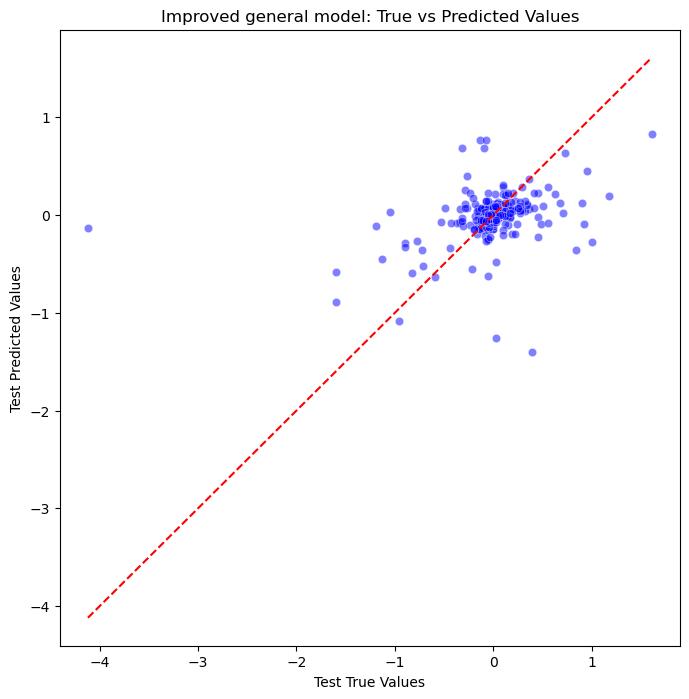

In [1485]:
eval_model(model_XGB_flori, flori_x_train_general_model, flori_x_test_general_model, flori_y_train_general_model, flori_y_test_general_model, "Improved general model")

In [1479]:
%conda install graphviz python-graphviz

782623.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1



## Package Plan ##

  environment location: /Users/user/anaconda3

  added / updated specs:
    - graphviz
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.2   |       hecd8cb5_0         128 KB
    cairo-1.16.0               |       h3ce6f7e_5        1013 KB
    certifi-2024.8.30          |  py311hecd8cb5_0         165 KB
    expat-2.6.3                |       h6d0c2b6_0         151 KB
    font-ttf-de

<Axes: >

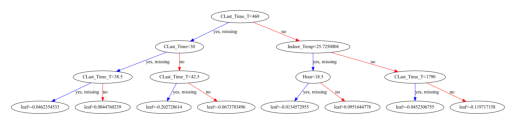

In [1483]:
from xgboost import plot_tree
plot_tree(booster=model_XGB_flori, num_trees=3, axes=(10,20))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

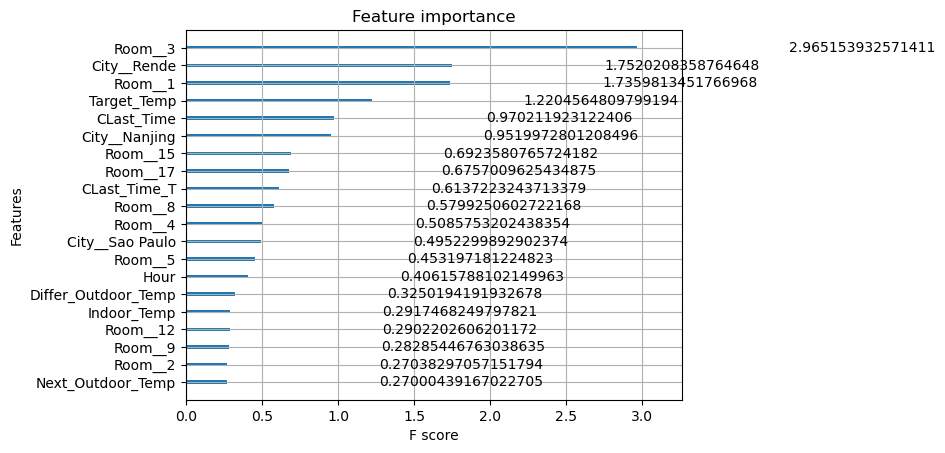

In [1493]:
xgb.plot_importance(model_XGB_V1_encoded, importance_type='gain', max_num_features=20)

## Should we use Florianopolis Data?

### Random seed 2023

In [1494]:
flori_x, flori_y = x[x['City']== city_encode_mapping['Florianopolis']], y[x['City']== city_encode_mapping['Florianopolis']]

new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y = train_test_split(
                                                    flori_x, 
                                                    flori_y,
                                                    test_size=0.2,
                                                    random_state=2023)



In [1496]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2023), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(new_flori_train_x, new_flori_train_y)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.013503521198143345), ('max_depth', 3), ('n_estimators', 475), ('subsample', 1.0)])


In [1502]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
flori_model_23 = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=475,
    colsample_bytree=0.5, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0135,
    subsample=1.0)#,
    # early_stopping_rounds=15)  # Reduced learning rate


# flori_model.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set= [(flori_x_val_finetune, flori_y_val)])
flori_model_23.fit(new_flori_train_x, new_flori_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0135, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=475, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Florianopolis model, different random seed
TEST -  mse: 0.18451 | rmse: 0.42955 | mae: 0.19095 | r2: 0.23916
TRAIN -  mse: 0.0979 | rmse: 0.3129 | mae: 0.1545 | r2: 0.4999


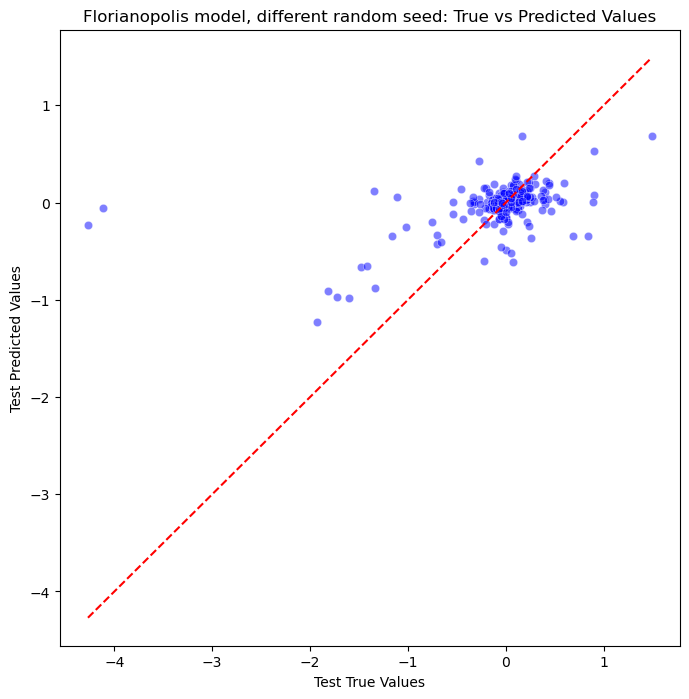

In [1498]:
eval_model(flori_model_23, new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y, "Florianopolis model, different random seed")

### Random seed: 13

In [1499]:
new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y = train_test_split(
                                                    flori_x, 
                                                    flori_y,
                                                    test_size=0.2,
                                                    random_state=13)

In [1500]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=13), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(new_flori_train_x, new_flori_train_y)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.007548974718614489), ('max_depth', 3), ('n_estimators', 465), ('subsample', 1.0)])


In [1503]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
flori_model_13 = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=465,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0075,
    subsample=1.0)#,
    # early_stopping_rounds=15)  # Reduced learning rate


# flori_model.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set= [(flori_x_val_finetune, flori_y_val)])
flori_model_13.fit(new_flori_train_x, new_flori_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0075, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=465, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Florianopolis model, different random seed
TEST -  mse: 0.14934 | rmse: 0.38644 | mae: 0.21231 | r2: 0.13816
TRAIN -  mse: 0.1109 | rmse: 0.3330 | mae: 0.1619 | r2: 0.4809


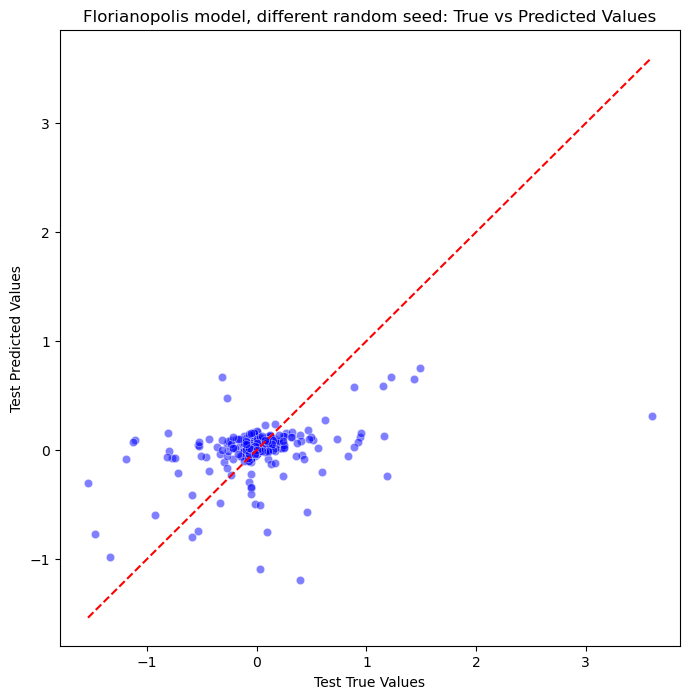

In [1504]:
eval_model(flori_model_13, new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y, "Florianopolis model, different random seed")

### Random seed = 123

In [1505]:
new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y = train_test_split(
                                                    flori_x, 
                                                    flori_y,
                                                    test_size=0.2,
                                                    random_state=123)

In [1506]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=123), 
                    { 
                    'max_depth': Integer(3, 10), 
                    'n_estimators': Integer(50, 500), 
                    'learning_rate': (0.005, 0.2, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=8)
opt.fit(new_flori_train_x, new_flori_train_y)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01912962501511305), ('max_depth', 3), ('n_estimators', 225), ('subsample', 0.9385825658609603)])


In [1508]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
flori_model_123 = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=225,
    colsample_bytree=0.5, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0191,
    subsample=0.94)#,
    # early_stopping_rounds=15)  # Reduced learning rate


# flori_model.fit(flori_x_train_no_val_finetune, flori_y_train_no_val, eval_set= [(flori_x_val_finetune, flori_y_val)])
flori_model_123.fit(new_flori_train_x, new_flori_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0191, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=225, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
Florianopolis model, different random seed
TEST -  mse: 0.18951 | rmse: 0.43532 | mae: 0.22224 | r2: 0.12763
TRAIN -  mse: 0.1009 | rmse: 0.3176 | mae: 0.1579 | r2: 0.5020


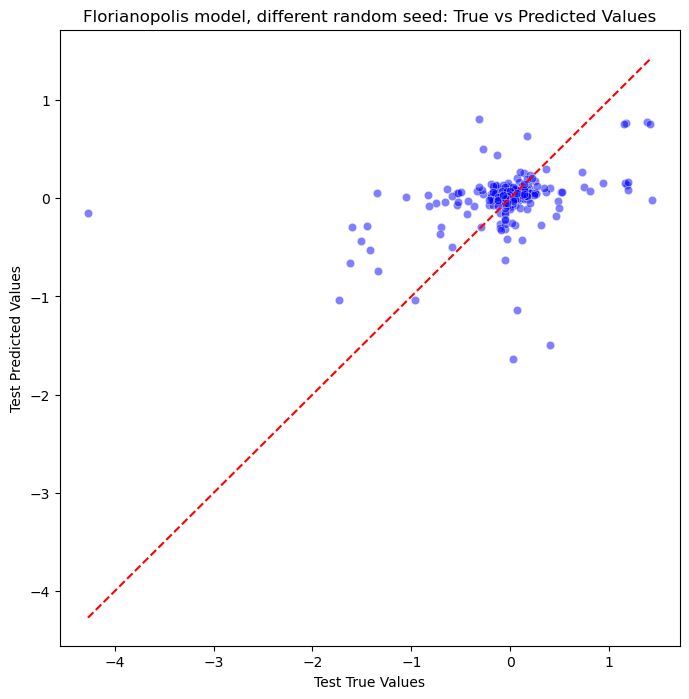

In [1509]:
eval_model(flori_model_123, new_flori_train_x, new_flori_test_x, new_flori_train_y, new_flori_test_y, "Florianopolis model, different random seed")

In [1519]:
filtered_data.columns

Index(['ID', 'Date_Time', 'AC_Status', 'Window_Status', 'CLast_Time',
       'CLast_Time_T', 'WLast_Time', 'WLast_Time_T', 'Indoor_Temp',
       'Indoor_RH', 'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed',
       'Month', 'Hour', 'Room_ID', 'Study_ID', 'City', 'Next_Indoor_Temp',
       'Next_Indoor_RH', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Differ_Indoor_Temp', 'Target_Temp'],
      dtype='object')

In [1520]:
flori_full_data = filtered_data[filtered_data['City']== city_encode_mapping['Florianopolis']]

In [1525]:
len(flori_full_data)

1526

In [1512]:
flori_full_data.Room_ID.unique()

array([], dtype=int64)

## General Model - Without Florianopolis Data!!

In [304]:
x_train_encoded_no_flori = x_train_encoded[x_train_encoded.City__Florianopolis == 0 ].drop(columns=["City__Florianopolis", "Room__0"])
x_test_encoded_no_flori = x_test_encoded[x_test_encoded.City__Florianopolis == 0].drop(columns=["City__Florianopolis", "Room__0"])

y_train_no_flori = y_train[x_train_encoded.City__Florianopolis == 0 ]
y_test_no_flori = y_test[x_test_encoded.City__Florianopolis == 0 ]

In [305]:
x_train_encoded_no_flori.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'City__Nanjing', 'City__Rende', 'City__Sao Paulo',
       'Room__1', 'Room__2', 'Room__3', 'Room__4', 'Room__5', 'Room__6',
       'Room__7', 'Room__8', 'Room__9', 'Room__10', 'Room__11', 'Room__12',
       'Room__13', 'Room__14', 'Room__15', 'Room__16', 'Room__17'],
      dtype='object')

In [1529]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 11), 
                    'n_estimators': Integer(100, 1200), 
                    'learning_rate': (0.01, 0.35, 'log-uniform'),
                    'subsample': (0.5, 1.0, 'uniform'), 
                    'colsample_bytree': (0.5, 1.0, 'uniform')},  
                    random_state=2022,
                    scoring='r2',
                    n_iter=40,
                    cv=5)
opt.fit(x_train_encoded_no_flori, y_train_no_flori)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('colsample_bytree', 0.8999020003232077), ('learning_rate', 0.027567002872746858), ('max_depth', 10), ('n_estimators', 1200), ('subsample', 0.6288753509075617)])


In [306]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_V1_encoded_no_flori = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=10, 
                            learning_rate=0.0276, 
                            n_estimators=1200,
                            subsample=0.6289,
                            colsample_bytree= 0.9
                            )
model_XGB_V1_encoded_no_flori.fit(x_train_encoded_no_flori,y_train_no_flori)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0276, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

Evaluating Model
General model, Without Florianopolis Data
TEST -  mse: 0.10517 | rmse: 0.32430 | mae: 0.15860 | r2: 0.57949
TRAIN -  mse: 0.0049 | rmse: 0.0698 | mae: 0.0464 | r2: 0.9803


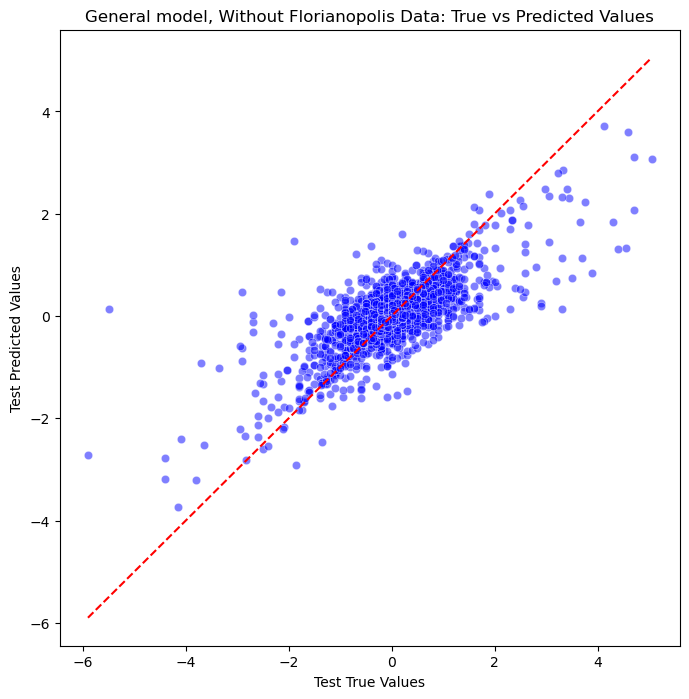

In [307]:
eval_model(model_XGB_V1_encoded_no_flori, x_train_encoded_no_flori, x_test_encoded_no_flori, y_train_no_flori, y_test_no_flori, "General model, Without Florianopolis Data")

## Calculate Top Results DF

### Paper Original Model, Evaluated on paper data without Florianopolis

In [1574]:
x_train_paper_no_flori = x_train_paper[x_train_paper['City'] != city_encode_mapping["Florianopolis"]]
x_test_paper_no_flori = x_test_paper[x_test_paper['City'] != city_encode_mapping["Florianopolis"]]

y_train_paper_no_flori = y_train_paper[x_train_paper['City'] != city_encode_mapping["Florianopolis"]]
y_test_paper_no_flori = y_test_paper[x_test_paper['City'] != city_encode_mapping["Florianopolis"]]



In [1575]:
columns_3_cities = [
    'Model', 
    'Nanjing-Train', 
    'Nanjing-Test', 
    'Rende-Train', 
    'Rende-Test', 
    'Sao Paulo-Train', 
    'Sao Paulo-Test', 
    'All-Train', 
    'All-Test', 
    'Description'
]

In [1576]:
results_df_3_cities = pd.DataFrame(columns=columns_3_cities)


In [50]:
cities_3 = {"Nanjing", "Rende", "Sao Paulo"}


original_model_data_dict_3_cities = get_data_dict(x_train_paper_no_flori, x_test_paper_no_flori, y_train_paper_no_flori, y_test_paper_no_flori, cities_3)

NameError: name 'get_data_dict' is not defined

In [1580]:
add_model_results(results_df_3_cities, model_XGB_original, original_model_data_dict_3_cities, "Original Paper Model", "Evaluate Reproduced model from paper, only on data without Florianopolis")

Sao Paulo-Train
[-0.0335638  -0.1459616  -0.18794735 ...  0.03502932 -0.23175478
 -0.02980537]
Evaluating MAE of Original Paper Model: Sao Paulo-Train
metric: 0.121
Sao Paulo-Test
[-0.41315147 -0.09073798 -0.00974901 ... -0.13759409 -0.13665886
 -0.15473658]
Evaluating MAE of Original Paper Model: Sao Paulo-Test
metric: 0.175
Nanjing-Train
[ 0.09657246 -0.21144453 -0.32736623 ... -0.10686821 -0.55582327
 -0.08274377]
Evaluating MAE of Original Paper Model: Nanjing-Train
metric: 0.123
Nanjing-Test
[-1.20042711e-01  7.57476613e-02  1.42212167e-01 -1.99448362e-01
  2.78141594e+00 -1.64063901e-01 -5.08313142e-02  2.22320095e-01
 -6.48834854e-02 -1.31193325e-01  5.42841852e-01 -4.40461129e-01
 -9.49561521e-02  5.66762686e-01  6.05622888e-01 -1.25449285e-01
 -6.46870136e-01 -1.45413995e-01  2.14014221e-02  4.01845664e-01
 -1.93786696e-01 -3.03877860e-01 -3.65457386e-01  2.26745933e-01
  9.18429717e-02 -2.32172936e-01 -2.16427445e-01 -5.00615478e-01
 -6.21091604e-01  4.43866067e-02  6.0342764

In [1581]:
results_df_3_cities.head()

Model Nanjing-Train Nanjing-Test Rende-Train  \
0  Original Paper Model - MAE         0.123         0.25       0.131   
1   Original Paper Model - R2         0.899        0.602       0.873   

  Rende-Test Sao Paulo-Train Sao Paulo-Test All-Train All-Test  \
0      0.188           0.121          0.175     0.123    0.181   
1      0.595           0.831          0.404     0.847    0.476   

                                         Description  
0  Evaluate Reproduced model from paper, only on ...  
1  Evaluate Reproduced model from paper, only on ...

### Paper Methodology, Clean data Paper without Florianopolis

In [161]:
x_train_no_flori = x_train[x_train['City'] != city_encode_mapping["Florianopolis"]]
x_test_no_flori = x_test[x_test['City'] != city_encode_mapping["Florianopolis"]]

y_train_no_flori = y_train[x_train['City'] != city_encode_mapping["Florianopolis"]]
y_test_no_flori = y_test[x_test['City'] != city_encode_mapping["Florianopolis"]]

In [1585]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train_no_flori, y_train_no_flori)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.2236886285624558), ('max_depth', 5), ('n_estimators', 500)])


In [1586]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB_clean_no_flori = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.2237, 
                            n_estimators=500)
model_XGB_clean_no_flori.fit(x_train_no_flori, y_train_no_flori)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2237, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

In [1588]:
clean_stratified_model_data_dict_no_flori = get_data_dict(x_train_no_flori, x_test_no_flori, y_train_no_flori, y_test_no_flori, cities=cities_3)
add_model_results(results_df_3_cities, model_XGB_clean_no_flori, clean_stratified_model_data_dict_no_flori, "Paper Model Clean", "Model methodology used in paper, with 2 changes: 1) Clean data. 2) Stratify split on city")

Sao Paulo-Train
[-0.19404057  1.0661647  -0.61877567 ...  0.01267064  0.05602422
 -0.06009058]
Evaluating MAE of Paper Model Clean: Sao Paulo-Train
metric: 0.116
Sao Paulo-Test
[-0.20804314  0.1227491   0.26763138 ...  0.33234176 -0.14253591
  0.11625649]
Evaluating MAE of Paper Model Clean: Sao Paulo-Test
metric: 0.174
Nanjing-Train
[-0.18748203 -0.33910257 -0.1878197  ... -0.16280216  0.25628847
 -0.5686153 ]
Evaluating MAE of Paper Model Clean: Nanjing-Train
metric: 0.112
Nanjing-Test
[ 3.22923660e-02 -3.81597370e-01  6.87398553e-01 -4.87729341e-01
  7.35246837e-01 -4.00438637e-01  1.71506763e-01 -4.06968683e-01
  5.04676104e-01 -1.15679771e-01 -8.87932956e-01  8.89284760e-02
  1.95590109e-01  1.51891056e-02 -8.69531929e-02  1.68873575e-02
 -7.27849752e-02 -9.01965916e-01  1.59231436e+00 -8.18125844e-01
  8.48087296e-02 -7.13039577e-01  3.19546670e-01 -8.71952549e-02
 -5.91605186e-01  1.01091325e-01 -7.41662145e-01 -4.56330836e-01
 -3.27042490e-01  1.85628254e-02  1.86113507e-01  4.

In [1596]:
# results_df_3_cities.to_csv("results_3_cities_29_09.csv")

### General Model - V1 - Without Florianopolis

In [56]:
results_df_no_flori = pd.read_csv("results_3_cities_29_09.csv")
results_df_no_flori.head()

Unnamed: 0                       Model  Nanjing-Train  Nanjing-Test  \
0           0  Original Paper Model - MAE          0.123         0.250   
1           1   Original Paper Model - R2          0.899         0.602   
2           3     Paper Model Clean - MAE          0.112         0.289   
3           4      Paper Model Clean - R2          0.914         0.465   

   Rende-Train  Rende-Test  Sao Paulo-Train  Sao Paulo-Test  All-Train  \
0        0.131       0.188            0.121           0.175      0.123   
1        0.873       0.595            0.831           0.404      0.847   
2        0.126       0.202            0.116           0.174      0.118   
3        0.881       0.579            0.811           0.464      0.840   

   All-Test                                        Description  
0     0.181  Evaluate Reproduced model from paper, only on ...  
1     0.476  Evaluate Reproduced model from paper, only on ...  
2     0.185  Model methodology used in paper, with 2 change...  
3     0.500  Model methodology used in paper, with 2 change...

In [1614]:
encoded_model_data_dict_no_flori = get_and_encode_data_dict(x_train_no_flori, x_test_no_flori, y_train_no_flori, y_test_no_flori, x_train_encoded_no_flori.columns, cities_3)

In [1625]:
add_model_results(results_df_no_flori, model_XGB_V1_encoded_no_flori, encoded_model_data_dict_no_flori, "General Model V1", "Improved general model: Better hyper parameters selection, 1-hot encoding for cities and rooms, trained on 3 cities data")

Evaluating MAE of General Model V1: Sao Paulo-Train
metric: 0.044
Evaluating MAE of General Model V1: Sao Paulo-Test
metric: 0.141
Evaluating MAE of General Model V1: Nanjing-Train
metric: 0.041
Evaluating MAE of General Model V1: Nanjing-Test
metric: 0.251
Evaluating MAE of General Model V1: Rende-Train
metric: 0.057
Evaluating MAE of General Model V1: Rende-Test
metric: 0.200
Evaluating MAE of General Model V1: All-Train
metric: 0.046
Evaluating MAE of General Model V1: All-Test
metric: 0.159
Evaluating R2 of General Model V1: Sao Paulo-Train
metric: 0.980
Evaluating R2 of General Model V1: Sao Paulo-Test
metric: 0.581
Evaluating R2 of General Model V1: Nanjing-Train
metric: 0.990
Evaluating R2 of General Model V1: Nanjing-Test
metric: 0.551
Evaluating R2 of General Model V1: Rende-Train
metric: 0.980
Evaluating R2 of General Model V1: Rende-Test
metric: 0.583
Evaluating R2 of General Model V1: All-Train
metric: 0.980
Evaluating R2 of General Model V1: All-Test
metric: 0.579


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

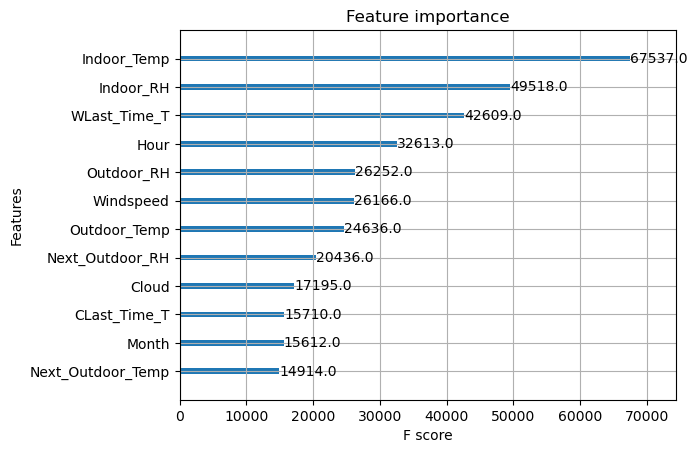

In [309]:
xgb.plot_importance(model_XGB_V1_encoded_no_flori, importance_type='weight', max_num_features=12)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

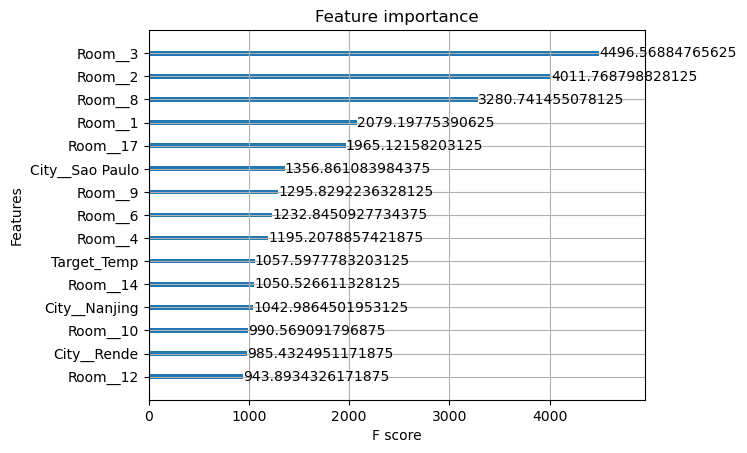

In [313]:
xgb.plot_importance(model_XGB_V1_encoded_no_flori, importance_type='cover', max_num_features=15)

In [ ]:
xgb.plot_importance(model_XGB_V1_encoded_no_flori, importance_type='cover', max_num_features=15)

In [300]:
eval_model(model_XGB_V1_encoded_no_flori, x_train_encoded_no_flori, x_test_encoded_no_flori, y_train_no_flori, y_test_no_flori, "General model, Without Florianopolis Data")

NameError: name 'model_XGB_V1_encoded_no_flori' is not defined

In [1627]:
# results_df_no_flori.to_csv("results_3_cities_3_models.csv")

In [156]:
results_df_no_flori_1 = pd.read_csv("results_3_cities_3_models.csv")
len(results_df_no_flori_1)

6

### Per City Model

In [113]:
sp_x_train_finetune_1 = prepare_data_for_finetune_no_city(sp_x_train)
sp_x_test_finetune_1 = prepare_data_for_finetune_no_city(sp_x_test)

nanging_x_train_finetune_1 = prepare_data_for_finetune_no_city(nanging_x_train)
nanging_x_test_finetune_1 = prepare_data_for_finetune_no_city(nanging_x_test)

rende_x_train_finetune_1 = prepare_data_for_finetune_no_city(rende_x_train)
rende_x_test_finetune_1 = prepare_data_for_finetune_no_city(rende_x_test)


sp_x_train_finetune_1 = sp_x_train_finetune_1.drop(columns=["Room__0"])
sp_x_test_finetune_1 = sp_x_test_finetune_1[sp_x_train_finetune_1.columns]
nanging_x_train_finetune_1 = nanging_x_train_finetune_1[sp_x_train_finetune_1.columns]
nanging_x_test_finetune_1 = nanging_x_test_finetune_1[sp_x_train_finetune_1.columns]
rende_x_train_finetune_1 = rende_x_train_finetune_1[sp_x_train_finetune_1.columns]
rende_x_test_finetune_1 = rende_x_test_finetune_1[sp_x_train_finetune_1.columns]

In [102]:
len(sp_x_train_finetune_1)

23689

In [144]:
per_city_model_data_dict_no_flori = get_per_city_model_data_dict(x_train_no_flori, x_test_no_flori, y_train_no_flori, y_test_no_flori, cities_3)

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'City', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Target_Temp', 'Room__1', 'Room__2', 'Room__3',
       'Room__4', 'Room__5', 'Room__6', 'Room__7', 'Room__8', 'Room__9',
       'Room__10', 'Room__11', 'Room__12', 'Room__13', 'Room__14', 'Room__15',
       'Room__16', 'Room__17'],
      dtype='object')


In [149]:
nanging_x_train_1, nanging_y_train_1 = per_city_model_data_dict_no_flori["Nanjing-Train"]
sp_x_train_1, sp_y_train_1 = per_city_model_data_dict_no_flori["Sao Paulo-Train"]
rende_x_train_1, rende_y_train_1 = per_city_model_data_dict_no_flori["Rende-Train"]

nanging_x_train_1 = nanging_x_train_1.drop(columns=["City"])
sp_x_train_1 = sp_x_train_1.drop(columns=["City"])
rende_x_train_1 = rende_x_train_1.drop(columns=["City"])



In [150]:
nanging_x_train_1.columns

Index(['AC_Status', 'Window_Status', 'CLast_Time', 'CLast_Time_T',
       'WLast_Time', 'WLast_Time_T', 'Indoor_Temp', 'Indoor_RH',
       'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed', 'Month',
       'Hour', 'Next_Outdoor_Temp', 'Next_Outdoor_RH', 'Differ_Outdoor_Temp',
       'Target_Temp', 'Room__1', 'Room__2', 'Room__3', 'Room__4', 'Room__5',
       'Room__6', 'Room__7', 'Room__8', 'Room__9', 'Room__10', 'Room__11',
       'Room__12', 'Room__13', 'Room__14', 'Room__15', 'Room__16', 'Room__17'],
      dtype='object')

In [151]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
nanging_model_1 = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=283,
    colsample_bytree=1.0,
    learning_rate=0.0168,
    subsample=0.5)
    # early_stopping_rounds=10) 


# nanging_model.fit(nanging_x_train_no_val_finetune, nanging_y_train_no_val, eval_set= [(nanging_x_val_finetune, nanging_y_val)])
nanging_model_1.fit(nanging_x_train_1, nanging_y_train_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0168, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=283, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [152]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
rende_model_1 = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=800,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.0178,
    subsample=0.5) #,
    # early_stopping_rounds=10)  # Reduced learning rate


# rende_model.fit(rende_x_train_no_val_finetune, rende_y_train_no_val, eval_set= [(rende_x_val_finetune, rende_y_val)])
rende_model_1.fit(rende_x_train_1, rende_y_train_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0178, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [153]:
# Step 2: Fine-tune for a specific city with a smaller learning rate
sp_model_1 = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    colsample_bytree=1.0, # Need to check all columns because there are many extra 0 rooms 
    learning_rate=0.03598,
    subsample=0.735) #,
    # early_stopping_rounds=10)  # Reduced learning rate


# sp_model.fit(sp_x_train_no_val_finetune, sp_y_train_no_val, eval_set= [(sp_x_val_finetune, sp_y_val)])
sp_model_1.fit(sp_x_train_1, sp_y_train_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03598, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluating Model
SP model
TEST -  mse: 0.08620 | rmse: 0.29359 | mae: 0.13568 | r2: 0.58569
TRAIN -  mse: 0.0013 | rmse: 0.0367 | mae: 0.0256 | r2: 0.9934


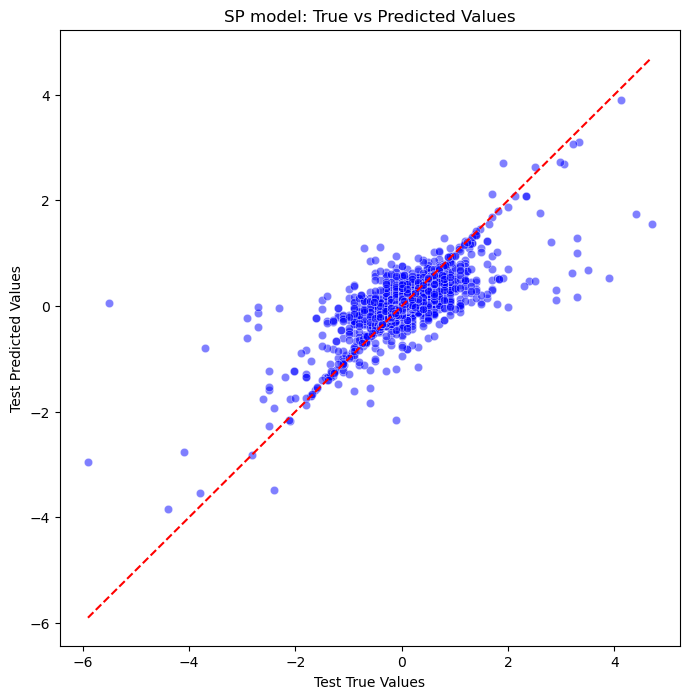

In [114]:
eval_model(sp_model_1, sp_x_train_1, sp_x_test_finetune_1, sp_y_train, sp_y_test, "SP model")

<Axes: title={'center': 'General Model: Feature importance - Gain'}, xlabel='F score', ylabel='Features'>

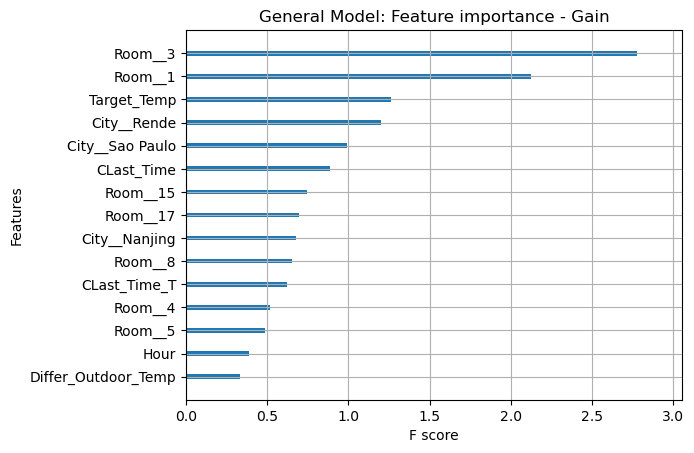

In [326]:
xgb.plot_importance(model_XGB_V1_encoded_no_flori, importance_type='gain', max_num_features=15, title="General Model: Feature importance - Gain", show_values=False)

<Axes: title={'center': 'General Model: Feature importance - Cover'}, xlabel='F score', ylabel='Features'>

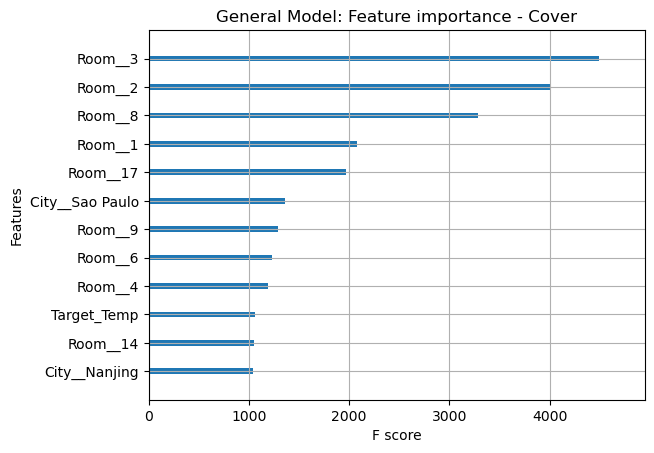

In [336]:
xgb.plot_importance(model_XGB_V1_encoded_no_flori, importance_type='cover', max_num_features=12, title="General Model: Feature importance - Cover", show_values=False)

In [154]:
models_dict_per_city = {
               "Nanjing": nanging_model_1, 
               "Rende": rende_model_1,
               "Sao Paulo": sp_model_1}
# per_city_model = CityModelWrapper(models_dict)
per_city_model_no_flori = CityModelWrapper(models_dict_per_city)

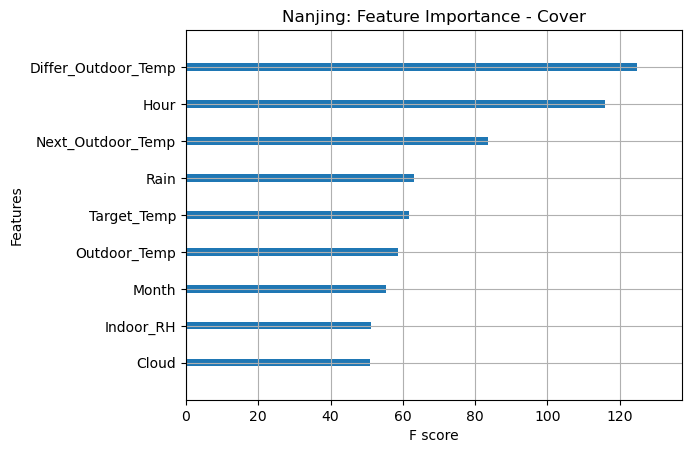

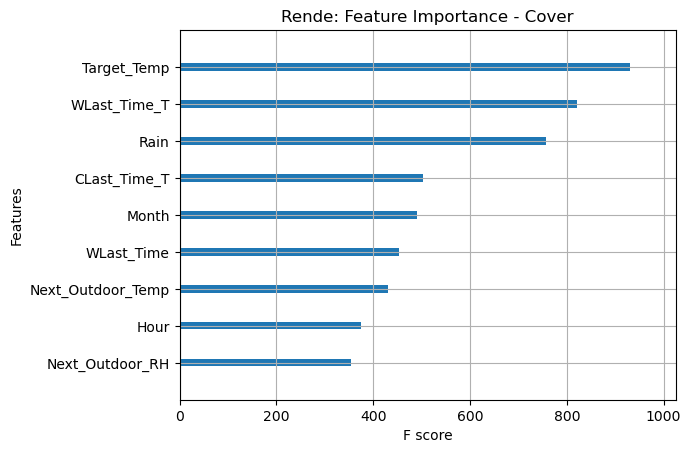

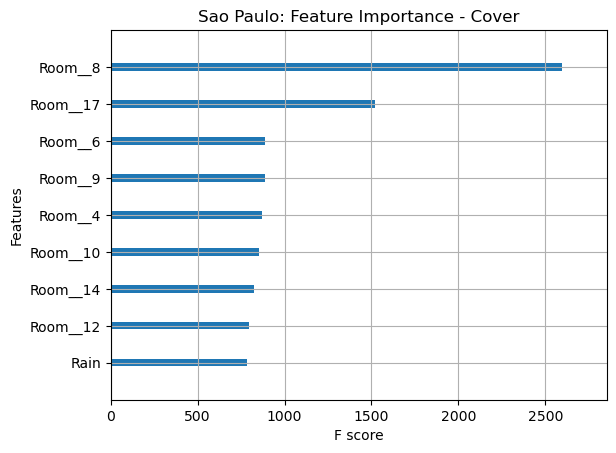

In [343]:
for k,v in models_dict_per_city.items():
    xgb.plot_importance(v, importance_type="cover", max_num_features=9, title=f"{k}: Feature Importance - Cover", show_values=False)

In [345]:
len(sp_x_train.Room_ID.unique())

14

In [86]:
# x_train_per_city_model =prepare_data_for_per_city_eval(x_train)
# x_test_per_city_model =prepare_data_for_per_city_eval(x_test)

# x_test_per_city_model = x_test_per_city_model[x_train_per_city_model.columns]

In [157]:
# add_model_results(results_df, per_city_model, per_city_model_data_dict, "Per City Model", "Different model for each city, trained separately on this city's data")
add_model_results(results_df_no_flori_1, per_city_model_no_flori, per_city_model_data_dict_no_flori, "Per City Model- No Early Stopping", "Different model for each city, trained separately on this city's data without Florianopolis")

Evaluating MAE of Per City Model- No Early Stopping: All-Train
metric: 0.043
Evaluating MAE of Per City Model- No Early Stopping: All-Test
metric: 0.153
Evaluating MAE of Per City Model- No Early Stopping: Rende-Train
metric: 0.098
Evaluating MAE of Per City Model- No Early Stopping: Rende-Test
metric: 0.196
Evaluating MAE of Per City Model- No Early Stopping: Sao Paulo-Train
metric: 0.026
Evaluating MAE of Per City Model- No Early Stopping: Sao Paulo-Test
metric: 0.136
Evaluating MAE of Per City Model- No Early Stopping: Nanjing-Train
metric: 0.082
Evaluating MAE of Per City Model- No Early Stopping: Nanjing-Test
metric: 0.233
Evaluating R2 of Per City Model- No Early Stopping: All-Train
metric: 0.971
Evaluating R2 of Per City Model- No Early Stopping: All-Test
metric: 0.587
Evaluating R2 of Per City Model- No Early Stopping: Rende-Train
metric: 0.932
Evaluating R2 of Per City Model- No Early Stopping: Rende-Test
metric: 0.589
Evaluating R2 of Per City Model- No Early Stopping: Sao Pa

In [158]:
results_df_no_flori_1.head(20)

Unnamed: 0.1  Unnamed: 0                                    Model  \
0           0.0         0.0               Original Paper Model - MAE   
1           1.0         1.0                Original Paper Model - R2   
2           2.0         3.0                  Paper Model Clean - MAE   
3           3.0         4.0                   Paper Model Clean - R2   
4           4.0         NaN                   General Model V1 - MAE   
5           5.0         NaN                    General Model V1 - R2   
6           NaN         NaN  Per City Model- No Early Stopping - MAE   
7           NaN         NaN   Per City Model- No Early Stopping - R2   

   Nanjing-Train  Nanjing-Test  Rende-Train  Rende-Test  Sao Paulo-Train  \
0          0.123         0.250        0.131       0.188            0.121   
1          0.899         0.602        0.873       0.595            0.831   
2          0.112         0.289        0.126       0.202            0.116   
3          0.914         0.465        0.881       0.579            0.811   
4          0.041         0.251        0.057       0.200            0.044   
5          0.990         0.551        0.980       0.583            0.980   
6          0.082         0.233        0.098       0.196            0.026   
7          0.954         0.581        0.932       0.589            0.993   

   Sao Paulo-Test  All-Train  All-Test  \
0           0.175      0.123     0.181   
1           0.404      0.847     0.476   
2           0.174      0.118     0.185   
3           0.464      0.840     0.500   
4           0.141      0.046     0.159   
5           0.581      0.980     0.579   
6           0.136      0.043     0.153   
7           0.586      0.971     0.587   

                                         Description  
0  Evaluate Reproduced model from paper, only on ...  
1  Evaluate Reproduced model from paper, only on ...  
2  Model methodology used in paper, with 2 change...  
3  Model methodology used in paper, with 2 change...  
4  Improved general model: Better hyper parameter...  
5  Improved general model: Better hyper parameter...  
6  Different model for each city, trained separat...  
7  Different model for each city, trained separat...

In [159]:
results_df_no_flori_1.to_csv("final results No Florianopolis 29_09.csv")

In [94]:
results_df_no_flori_1.head(10)

Unnamed: 0.1  Unnamed: 0                                    Model  \
0           0.0         0.0               Original Paper Model - MAE   
1           1.0         1.0                Original Paper Model - R2   
2           2.0         3.0                  Paper Model Clean - MAE   
3           3.0         4.0                   Paper Model Clean - R2   
4           4.0         NaN                   General Model V1 - MAE   
5           5.0         NaN                    General Model V1 - R2   
6           NaN         NaN  Per City Model- No Early Stopping - MAE   
7           NaN         NaN   Per City Model- No Early Stopping - R2   

   Nanjing-Train  Nanjing-Test  Rende-Train  Rende-Test  Sao Paulo-Train  \
0          0.123         0.250        0.131       0.188            0.121   
1          0.899         0.602        0.873       0.595            0.831   
2          0.112         0.289        0.126       0.202            0.116   
3          0.914         0.465        0.881       0.579            0.811   
4          0.041         0.251        0.057       0.200            0.044   
5          0.990         0.551        0.980       0.583            0.980   
6          0.082         0.233        0.098       0.196            0.189   
7          0.954         0.581        0.932       0.589            0.372   

   Sao Paulo-Test  All-Train  All-Test  \
0           0.175      0.123     0.181   
1           0.404      0.847     0.476   
2           0.174      0.118     0.185   
3           0.464      0.840     0.500   
4           0.141      0.046     0.159   
5           0.581      0.980     0.579   
6           0.245      0.165     0.234   
7           0.063      0.590     0.264   

                                         Description  
0  Evaluate Reproduced model from paper, only on ...  
1  Evaluate Reproduced model from paper, only on ...  
2  Model methodology used in paper, with 2 change...  
3  Model methodology used in paper, with 2 change...  
4  Improved general model: Better hyper parameter...  
5  Improved general model: Better hyper parameter...  
6  Different model for each city, trained separat...  
7  Different model for each city, trained separat...

In [346]:
import pickle

for k,v in models_dict_per_city.items():
    city_file_name = f"XGB_{k}"
    # save
    pickle.dump(v, open(city_file_name, "wb"))

In [347]:
sp_x_train_1.to_csv("final_models_data_example_sp.csv")